In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import myscutils.myscutils as mscu

Running Scanpy 1.3.7 on 2019-09-04 12:01.
Dependencies: anndata==0.6.17 numpy==1.15.4 scipy==1.2.0 pandas==0.23.4 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 1.3.7 on 2019-09-04 12:01.
Dependencies: anndata==0.6.17 numpy==1.15.4 scipy==1.2.0 pandas==0.23.4 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [149]:
adata = sc.read_h5ad("./data/final_293t/filt_norm2_293t.h5ad")

In [150]:
adata

AnnData object with n_obs × n_vars = 11447 × 5430 
    obs: 'batch', 'library_id', 'fraction_mito', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_symbols', 'gene_ids', 'n_cells', 'n_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [151]:
data_cc = adata.copy()

In [152]:
genes_df = pd.read_csv("./data/known_plus_regev.csv", index_col=0)
s_genes= list(genes_df[genes_df['phase'] == 'S'].index.values)
g2m_genes = list(genes_df[(genes_df['phase'] == 'G2') | (genes_df['phase'] == 'G2/M')].index.values)
g1_genes = list(genes_df[(genes_df['phase'] == 'G1') | (genes_df['phase'] == 'M/G1')].index.values)

In [153]:
print(len(g1_genes))
print(len(s_genes))
print(len(g2m_genes))

14
41
62


In [154]:
print(set(data_cc.var.index).intersection(g1_genes))
print(set(data_cc.var.index).intersection(s_genes))
print(set(data_cc.var.index).intersection(g2m_genes))

{'ENSG00000150630', 'ENSG00000184481', 'ENSG00000147133'}
{'ENSG00000101868', 'ENSG00000051180', 'ENSG00000129173', 'ENSG00000139618', 'ENSG00000092470', 'ENSG00000138764'}
{'ENSG00000112742', 'ENSG00000080986', 'ENSG00000156970', 'ENSG00000169679', 'ENSG00000158402', 'ENSG00000114346', 'ENSG00000117650', 'ENSG00000092140', 'ENSG00000123485'}


In [155]:
K = set().union(*[g1_genes, s_genes, g2m_genes])
K = list(set(data_cc.var.index).intersection(K))

In [156]:
len(K)

18

In [157]:
data_cc = data_cc[:,list(K)]

In [158]:
mscu.my_score_genes_cell_cycle_improved(data_cc,g1_genes,s_genes,g2m_genes)

computing score 'S_score'
    finished (0:00:00.32) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:00.03) --> added
    'G2M_score', score of gene set (adata.obs)
computing score 'G1_score'
    finished (0:00:00.02) --> added
    'G1_score', score of gene set (adata.obs)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


... storing 'phase' as categorical


saving figure to file ./figures/pca_293t_cc_score_phase.pdf


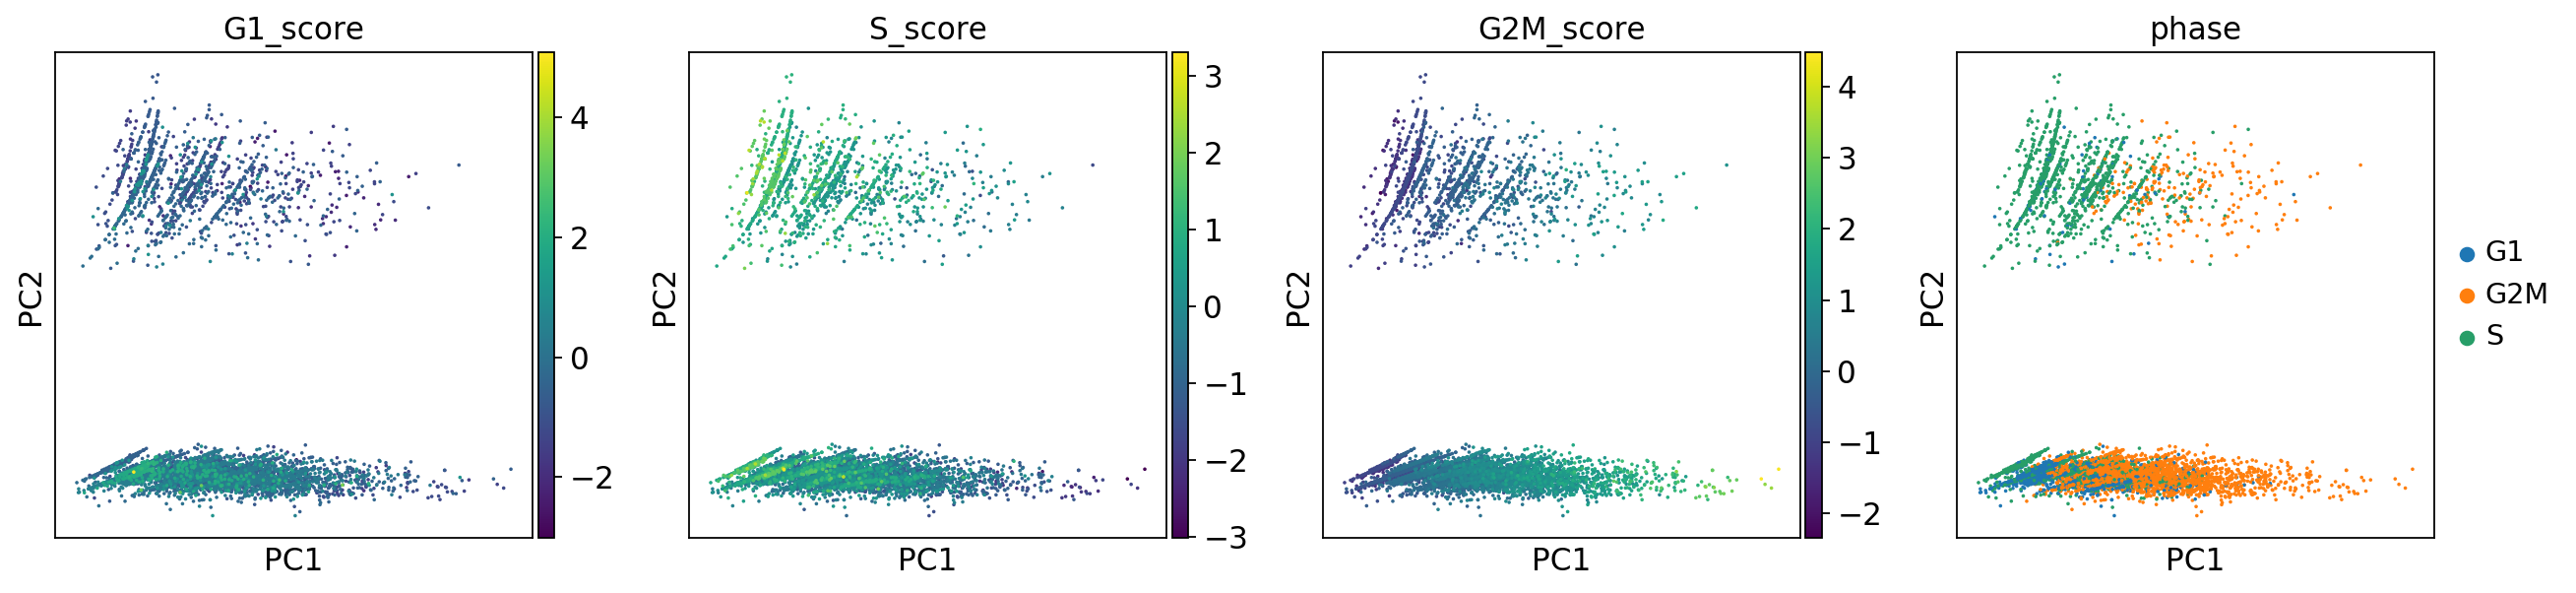

saving figure to file ./figures/pca_293t_batch.pdf


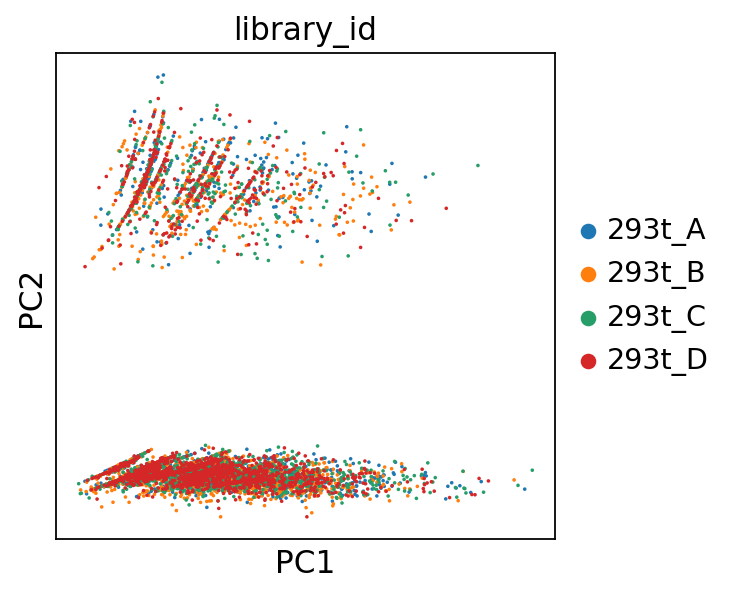

In [159]:
sc.tl.pca(data_cc)
sc.pl.pca_scatter(data_cc, color=[ 'G1_score', 'S_score','G2M_score','phase'], components=['1,2'],save="_293t_cc_score_phase.pdf")
sc.pl.pca_scatter(data_cc, color=[ 'library_id'], components=['1,2'],save="_293t_batch.pdf")

saving figure to file ./figures/pca_293t_cc_count_genes_mito_batch.pdf


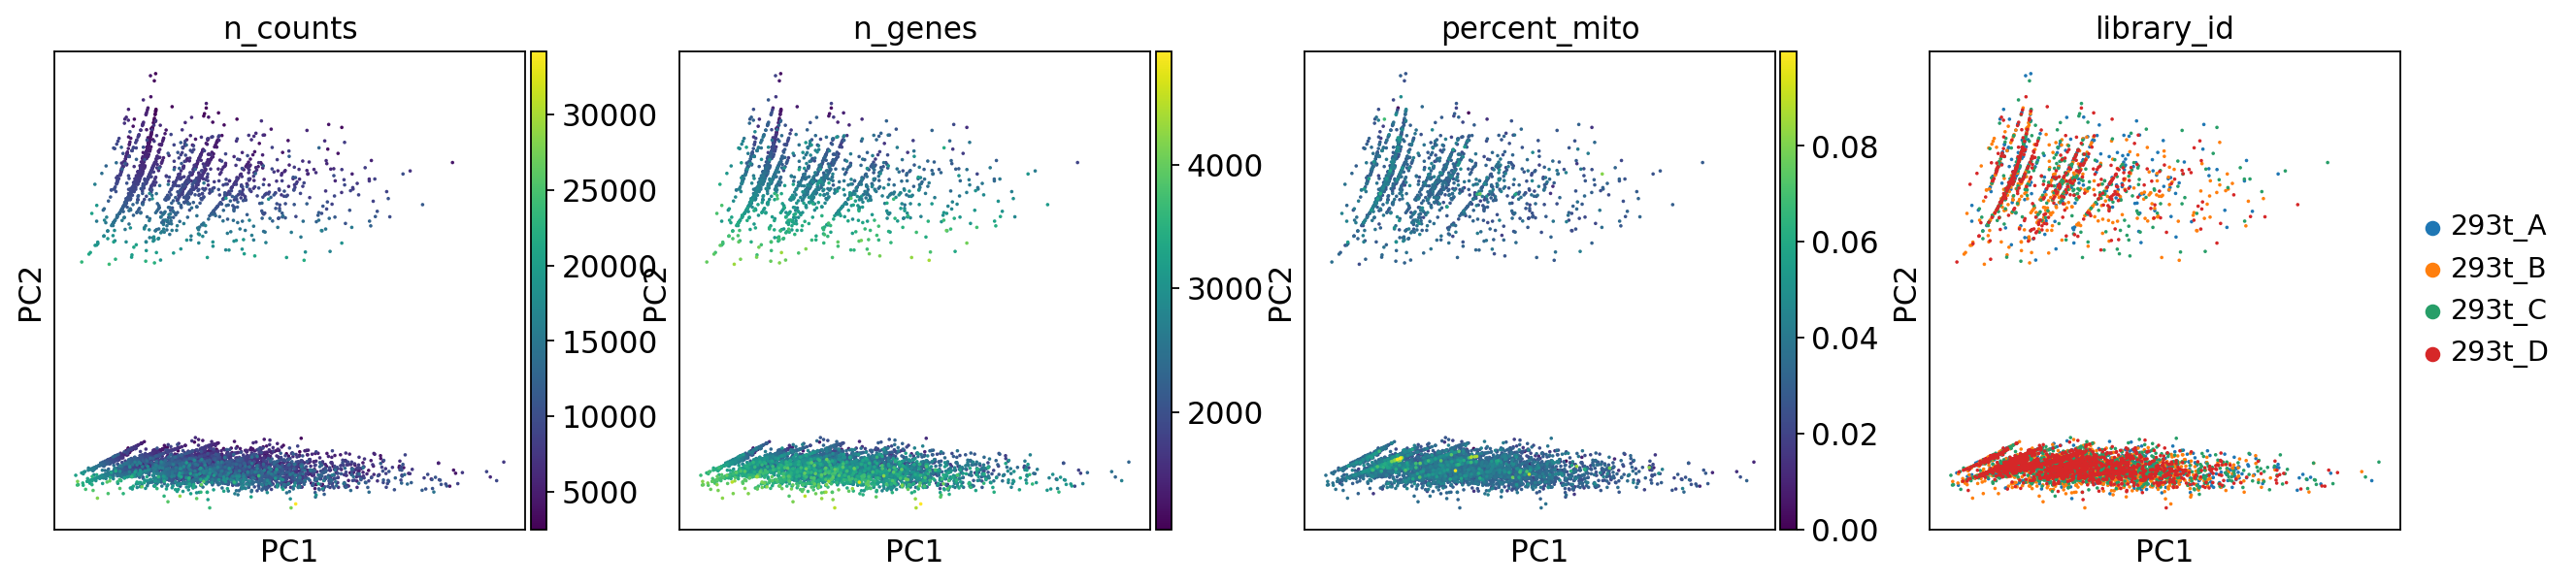

In [161]:
sc.pl.pca_scatter(data_cc, color=['n_counts', 'n_genes','percent_mito','library_id'], components=['1,2'], save="_293t_cc_count_genes_mito_batch.pdf")

In [18]:
data_cc.obs.head()

batch library_id  fraction_mito  n_counts  n_genes  \
index                                                                 
AAACATACACTGGT-0     0     293t_A       0.026788    9630.0     2973   
AAACATACAGACTC-0     0     293t_A       0.024273    4572.0     1621   
AAACATTGACCAAC-0     0     293t_A       0.037578   12453.0     3008   
AAACATTGAGGCGA-0     0     293t_A       0.032676    8018.0     2509   
AAACATTGGGACTT-0     0     293t_A       0.039494   14151.0     3019   

                  percent_mito   S_score  G2M_score  G1_score phase  
index                                                                
AAACATACACTGGT-0      0.026791  0.385208   0.677992  0.324983   G2M  
AAACATACAGACTC-0      0.024278  0.871659  -0.747732 -0.643095     S  
AAACATTGACCAAC-0      0.037581  0.033821  -0.352416  0.363689    G1  
AAACATTGAGGCGA-0      0.032676  0.920091  -0.851399  0.302881     S  
AAACATTGGGACTT-0      0.039503 -0.427729   0.078336  0.386970    G1

In [19]:
#scores = data_cc.obs['G0_score']
#keep = (scores<0.7)
#data_bb = data_cc[keep,:].copy()

In [20]:
keep_ind = []
g1_keep = data_cc.obs['G1_score'].sort_values(ascending=False)[:10].mean()*0.6
s_keep = data_cc.obs['S_score'].sort_values(ascending=False)[:10].mean()*0.6
g2m_keep = data_cc.obs['G2M_score'].sort_values(ascending=False)[:10].mean()*0.6
print(g1_keep, s_keep, g2m_keep)
keep_scores = {'G1': g1_keep, 'S': s_keep, 'G2M': g2m_keep }
p_score_l = ['G1_score','S_score','G2M_score']
for index, row in data_cc.obs.iterrows():
    p = row['phase']
    if (row['{}_score'.format(p)] >= keep_scores[p]) and ( (row[p_score_l] >= keep_scores[p]).sum() == 1):
        keep_ind.append(index)

1.7873456954956055 1.6393479824066162 2.0631053924560545


In [21]:
len(keep_ind)

618

In [22]:
data_bb = data_cc[keep_ind,:].copy()

In [32]:
data_bb.obs.phase.value_counts()

G1     356
S      195
G2M     78
Name: phase, dtype: int64

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
saving figure to file ./figures/pca_293t_filter_cc_score_phase.pdf


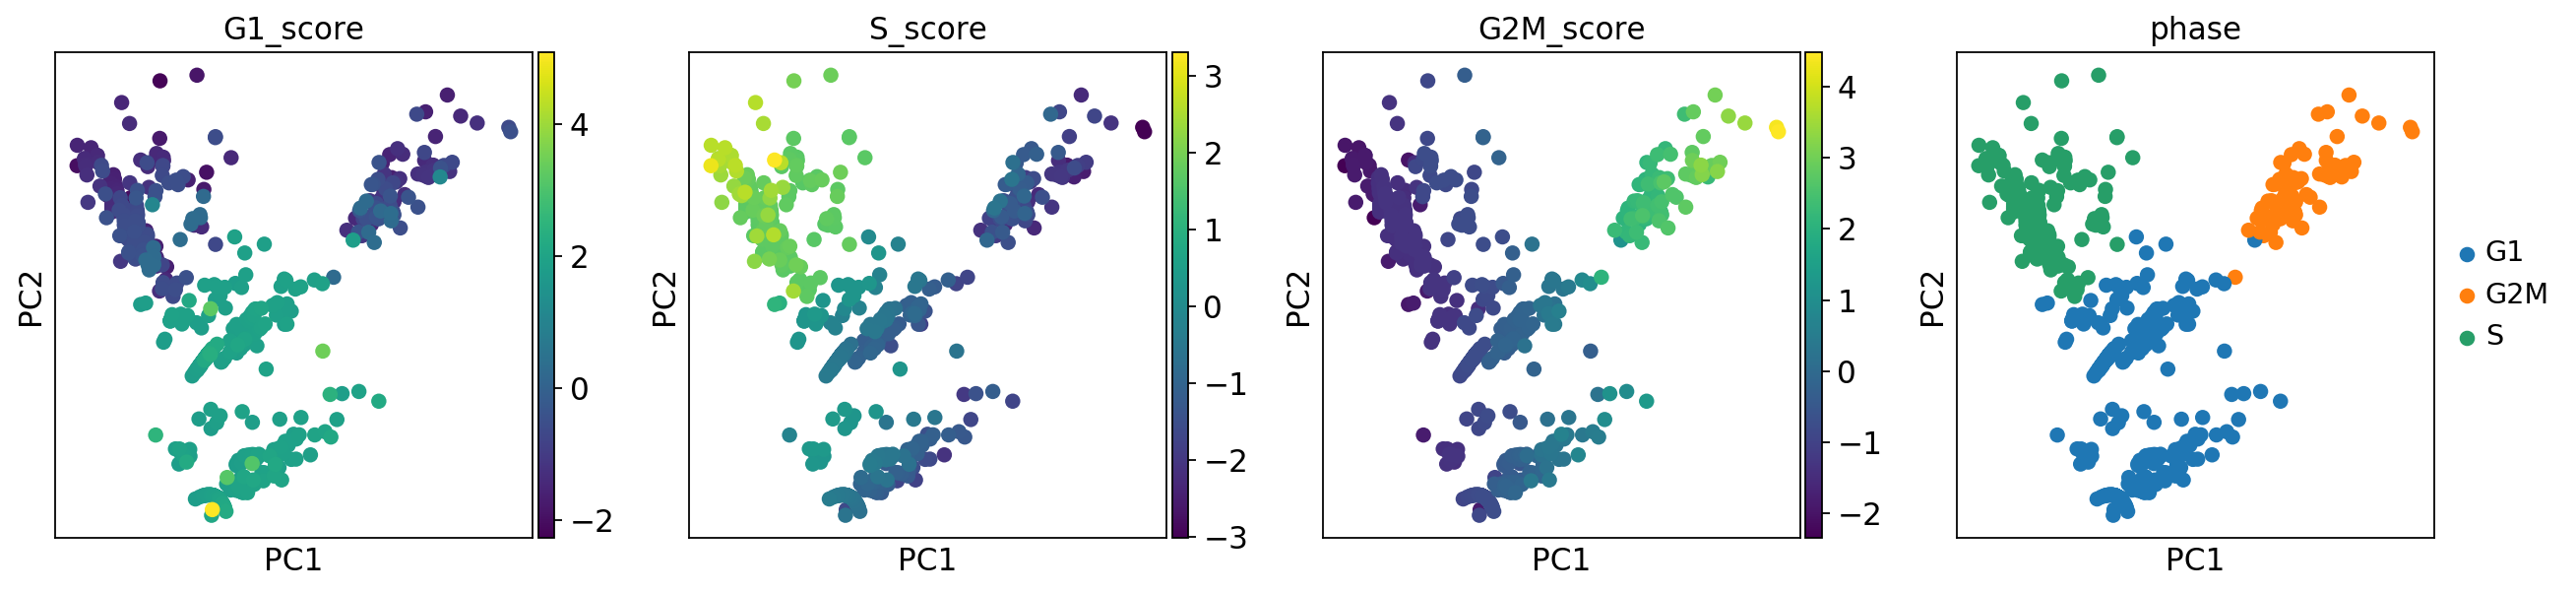

In [23]:
sc.tl.pca(data_bb)
sc.pl.pca_scatter(data_bb, color=[ 'G1_score', 'S_score','G2M_score','phase'], components=['1,2'],save="_293t_filter_cc_score_phase.pdf")

We wish to find an ordering of the cells with respect to their phase angle in the cell cycle. We will use a multivariate statistical method to perform a dimensional reduction on the data. Principal Component Analysis is a known and widely used method for dimensional reduction in large datasets with many variables (REFREFREF). We wish to represent the data in a form such that variation corresponding to the biology of the cell cycle is responsible for as much variance as possible. To achieve this, we filter the data based on known genes with known cyclic expressions. We use the list presented in [refref]. The intersection between the expressed genes in our data set and this list is used in the dimensional reduction. 

We furhter filter the cells by calculating a phase score for each cell. We use the score_genes_cell_cycle from scanpy. This is a re-implementation from the R-package seurat (https://www.nature.com/articles/nbt.3192). The method used is discussed in the method chapter of (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4665007/). We score against a subset of S and G2M genes with a known strong correlation to cyclic behaviour in the respective phases. The G1 score is then calculated by negating the sum of the S and G2M scores for each cell. Each cell is then assigned exactly one of the three phases. A drawback of this method is that we are not able to filter out the cells that are assigned to G1 which are in the resting phase (????). Proceeding, we filter by the phase scores. We keep only the cells that are above a given threshold in exactly one of the three phases. We must find a balance between the score criterion and the resulting population size. 

In [24]:
sc.pp.neighbors(data_bb, n_pcs=3, n_neighbors=20, method="umap")
sc.tl.umap(data_bb)

computing neighbors
    using data matrix X directly
    finished (0:00:07.22) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:03.29) --> added
    'X_umap', UMAP coordinates (adata.obsm)


saving figure to file ./figures/umap.pdf


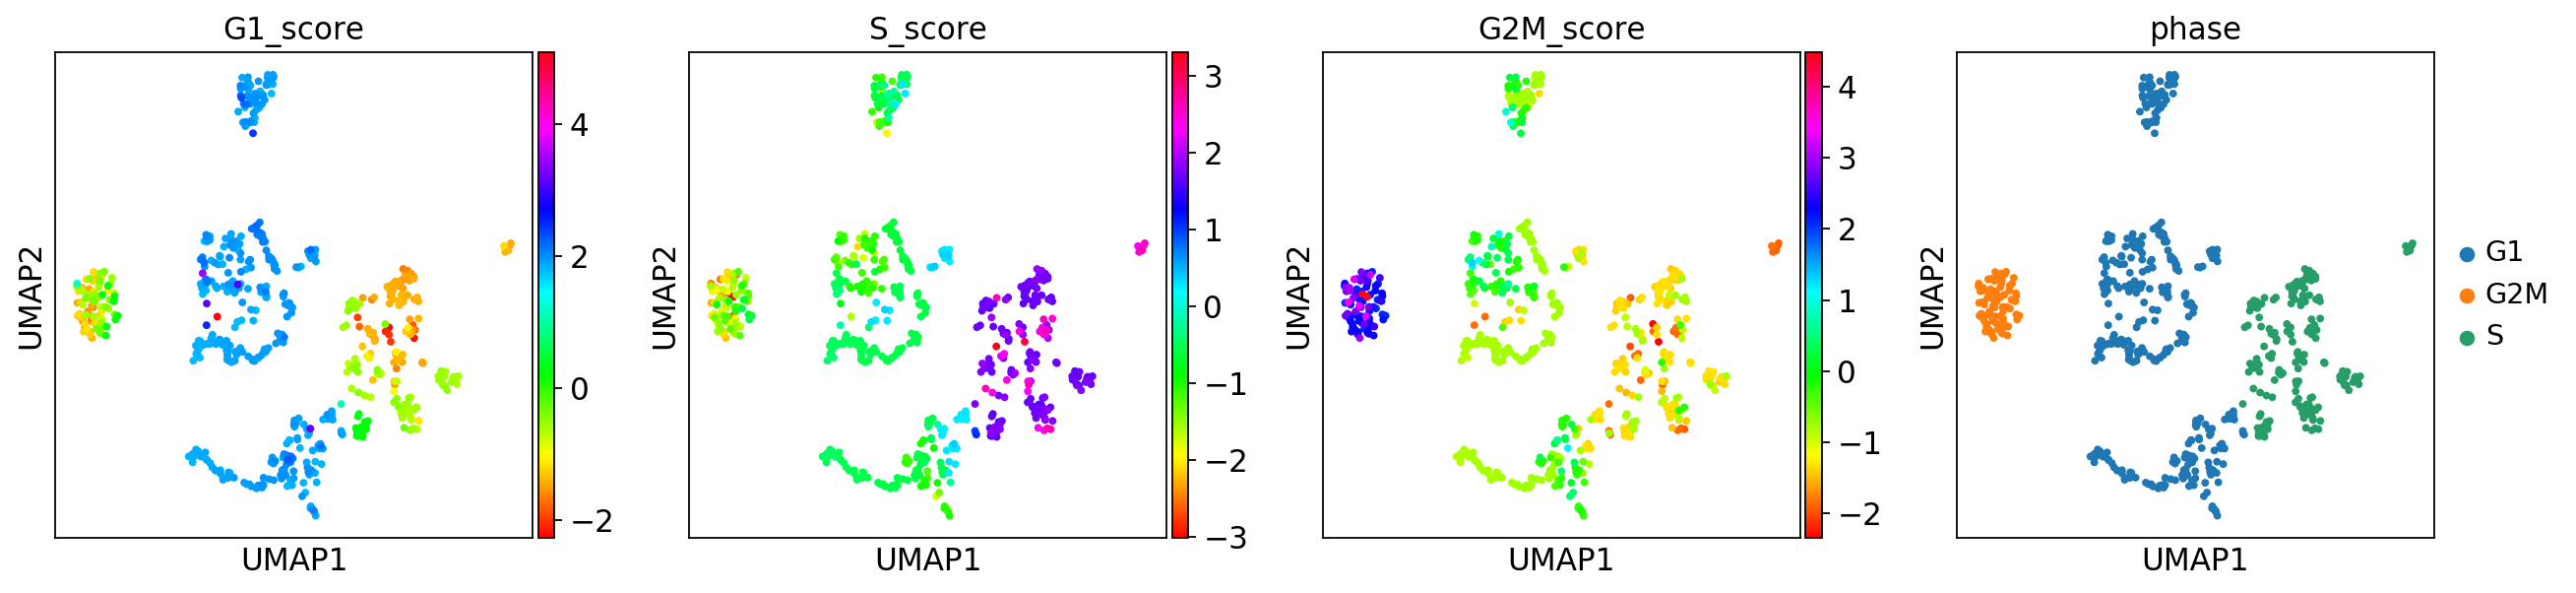

In [25]:
sc.pl.umap(data_bb, color=[ 'G1_score', 'S_score','G2M_score','phase'], s=50, cmap='hsv', save=True)


In [26]:
data_bb

AnnData object with n_obs × n_vars = 618 × 18 
    obs: 'batch', 'library_id', 'fraction_mito', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'G1_score', 'phase'
    var: 'gene_symbols', 'gene_ids', 'n_cells', 'n_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'phase_colors', 'library_id_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

We now find an estimate of the phase angle for each cell. We compute each cells angle with respect to PC1 in the (PC1,PC2) plane. Each cells unit vector in the plane is calculated and we the arctangent of their unit vector components to assign a phase angle in the range (-pi,pi). The cells which are assigned phase angle in the range (-pi,0) are translatadet by 2pi so that each cell now has a phase angle corresponding to one period if we represent the cell cycle on a circle. The cell population is then sorted by their phase angle in this cicular represenation.

The phase boundaries in the ordering are found by subdividing the population into equally sized bins. The retio of cells in each each of the phases are calculated for each bin. The distribution of each phase through the ordering is represented by drawing the line from the ratios of each of the phases. We use the intersection of these lines to find the phase boundaries in the ordering. The ordering is translated such that G2M/G1 boundary starts at order zero. A pseudotime for each cell is found by using the know duration of each cycle measured in hours. Lab experiments show that the human cell cycle has a duration of ~24 hours. Of these 24 hours, approximately 11 hours are spent in G1, 8 hours in S, 4 hours in G2 and lastly 1 hour in M (ref). G2M is then assigned 5 hours by this model. The pseudotime is then found by scaling the phase angles of the cells to the range (0,1), rescaling to the duration of the cycle measured in hours and translating by the accumulated phase boundary measured in hours. The result is a pseudotime for each in the range (0,24) with phase boundaries G2M/G1 = 0h, G1/S = 11h, S/G2M = 19h.

In [27]:
data_bb.obs['angles'] = mscu.compute_angles(data_bb.obsm.X_pca[:,:2])

In [28]:
data_bb = data_bb[data_bb.obs['angles'].argsort(),:]
data_bb.obs['order'] = np.arange(len(data_bb.obs))

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
saving figure to file ./figures/pca.pdf


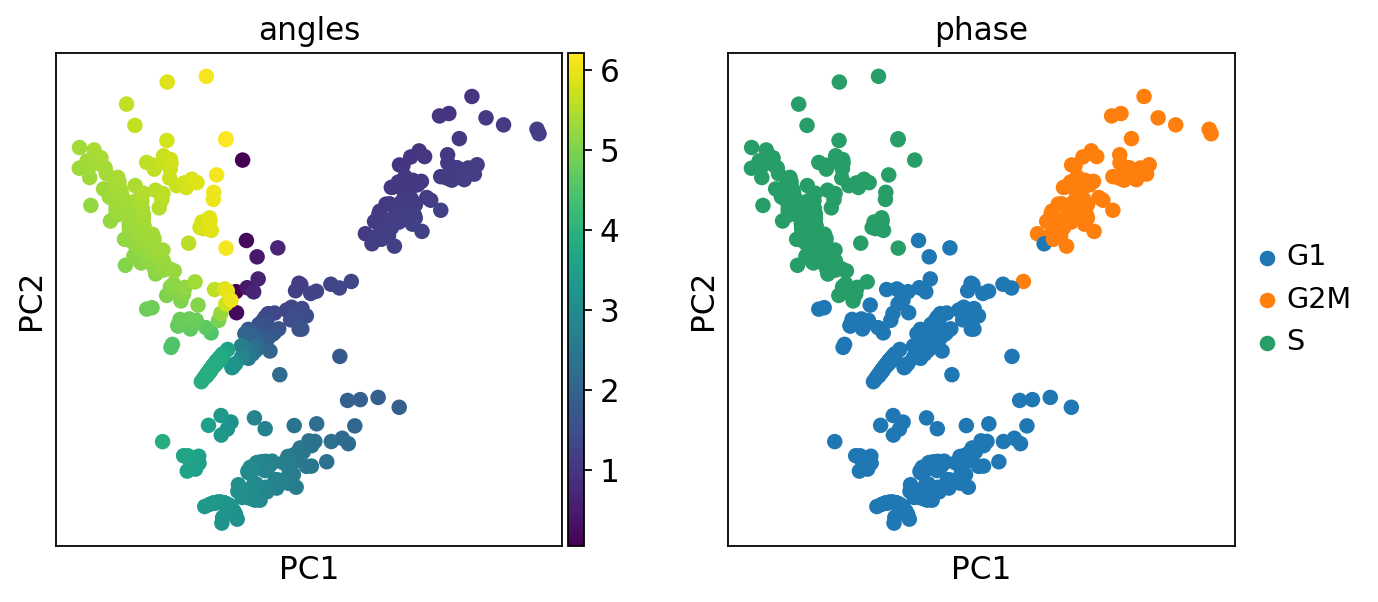

In [29]:
sc.tl.pca(data_bb)
sc.pl.pca_scatter(data_bb, color=[ 'angles', 'phase'], components=['1,2'], save=True)

In [30]:
data_bb[data_bb.obs['phase'] == 'not_assigned',:].obs.head(50)

Empty DataFrame
Columns: [batch, library_id, fraction_mito, n_counts, n_genes, percent_mito, S_score, G2M_score, G1_score, phase, angles, order]
Index: []

saving figure to file ./figures/pca_loadings.pdf


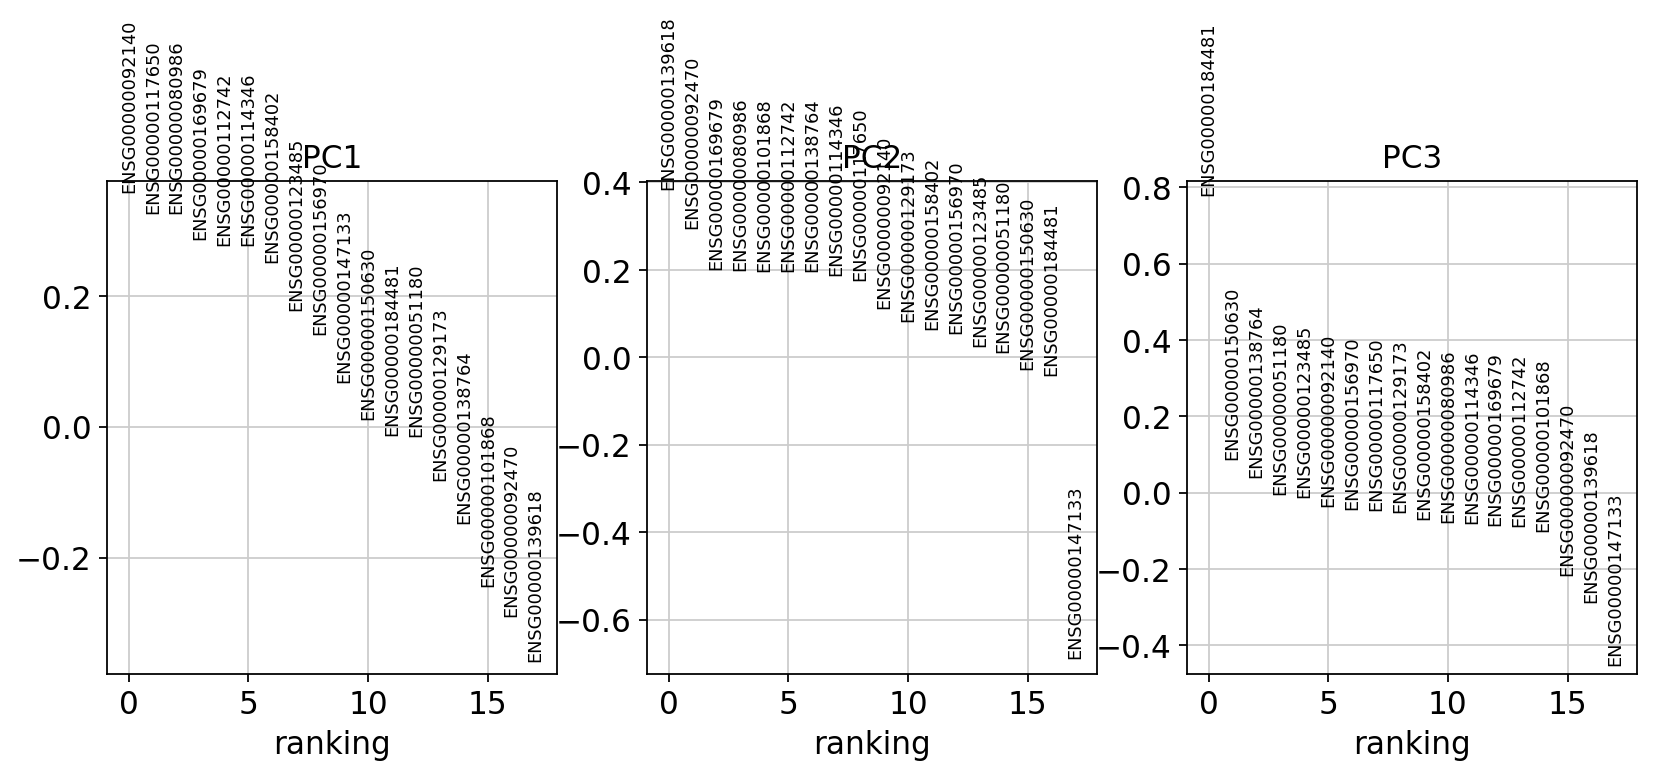

In [31]:
sc.pl.pca_loadings(data_bb, show=True, save=True)


saving figure to file ./figures/umap.pdf


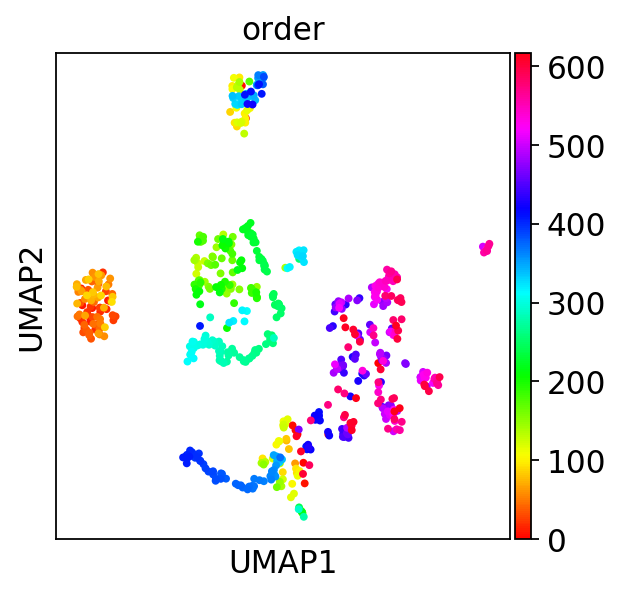

In [32]:
sc.pl.umap(data_bb, color=[ 'order'], s=50, cmap='hsv', save=True)


In [33]:
adata = sc.read_h5ad("./data/final_293t/filt_norm_293t.h5ad")
adata = adata[list(data_bb.obs.index),:].copy()

In [34]:
data_bb.obs.head()
for v in ['S_score','G2M_score','G1_score','angles','phase','order']:
    adata.obs[v] = data_bb.obs[v].copy()
data_bb = adata.copy()

In [35]:
phase_dict = {}
for p in ['G1', 'S', 'G2M']:
    p_cells = data_bb[data_bb.obs['phase'] == p,:].copy()
    angles = p_cells.obs['angles']
    mean_angle = angles.mean()
    if angles.max() - angles.min() > 1.5*np.pi:
        angles[angles > np.pi] -= 2*np.pi
    var_angle = p_cells.obs['angles'].var()
    phase_dict[p] = {'mean': mean_angle, 'variance': var_angle, 'phase': p}
    if mean_angle + 3.2*np.sqrt(var_angle) > 2*np.pi:
        phase_dict['{}-shift'.format(p)] = {'mean': mean_angle-2*np.pi, 'variance': var_angle, 'phase': p}
    elif mean_angle - 3.2*np.sqrt(var_angle) < 0:
        phase_dict['{}-shift'.format(p)] = {'mean': mean_angle+2*np.pi, 'variance': var_angle, 'phase': p}


/mnt/scratch/geiramh/miniconda3/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
phase_dict

{'G1': {'mean': 3.0684993, 'variance': 6.0347567, 'phase': 'G1'},
 'G1-shift': {'mean': -3.2146859804736536,
  'variance': 6.0347567,
  'phase': 'G1'},
 'S': {'mean': 5.3771334, 'variance': 0.0635397, 'phase': 'S'},
 'G2M': {'mean': 1.1211715, 'variance': 0.0041476833, 'phase': 'G2M'}}

In [37]:
import scipy

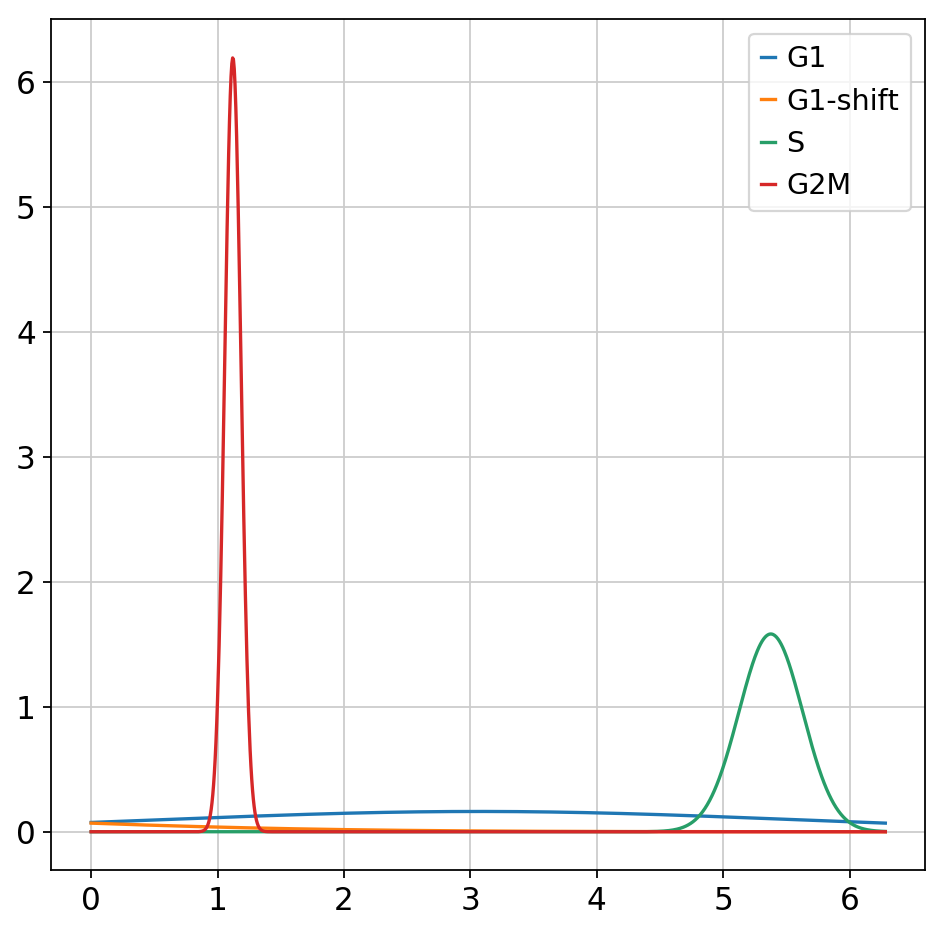

In [38]:
plt.figure(figsize=(7,7))
t = np.linspace(0,2*np.pi,1000)
#t = np.linspace(0,len(data_bb.obs),len(data_bb.obs))
for k,v in phase_dict.items():
    mean = v['mean']
    scale = np.sqrt(v['variance'])
    plt.plot(t,scipy.stats.norm.pdf(t, mean, scale),'-',label=k)
plt.legend()
#plt.savefig("data/nice_plots/pls_phase_angle_dist_orig.png")

In [49]:
#find boundaries and order
# reverse if needed (alpha = 2pi-alpha)
#add 2pi-G2M/G1 boundary alpha to all alphas
#if alpha > 2pi: -= 2pi

In [50]:
g1_mean = phase_dict['G1']['mean']
s_mean = phase_dict['S']['mean']
g2m_mean = phase_dict['G2M']['mean']

In [51]:
#data_bb = data_bb[data_bb.obs['order'].argsort()[::-1],:]
#data_bb.obs['order'] = np.arange(len(data_bb.obs))

/mnt/work/geiramh/part2-single-cell/notebooks/myscutils/myscutils.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  values = count_df.as_matrix(columns=data_bb.obs['phase'].unique())


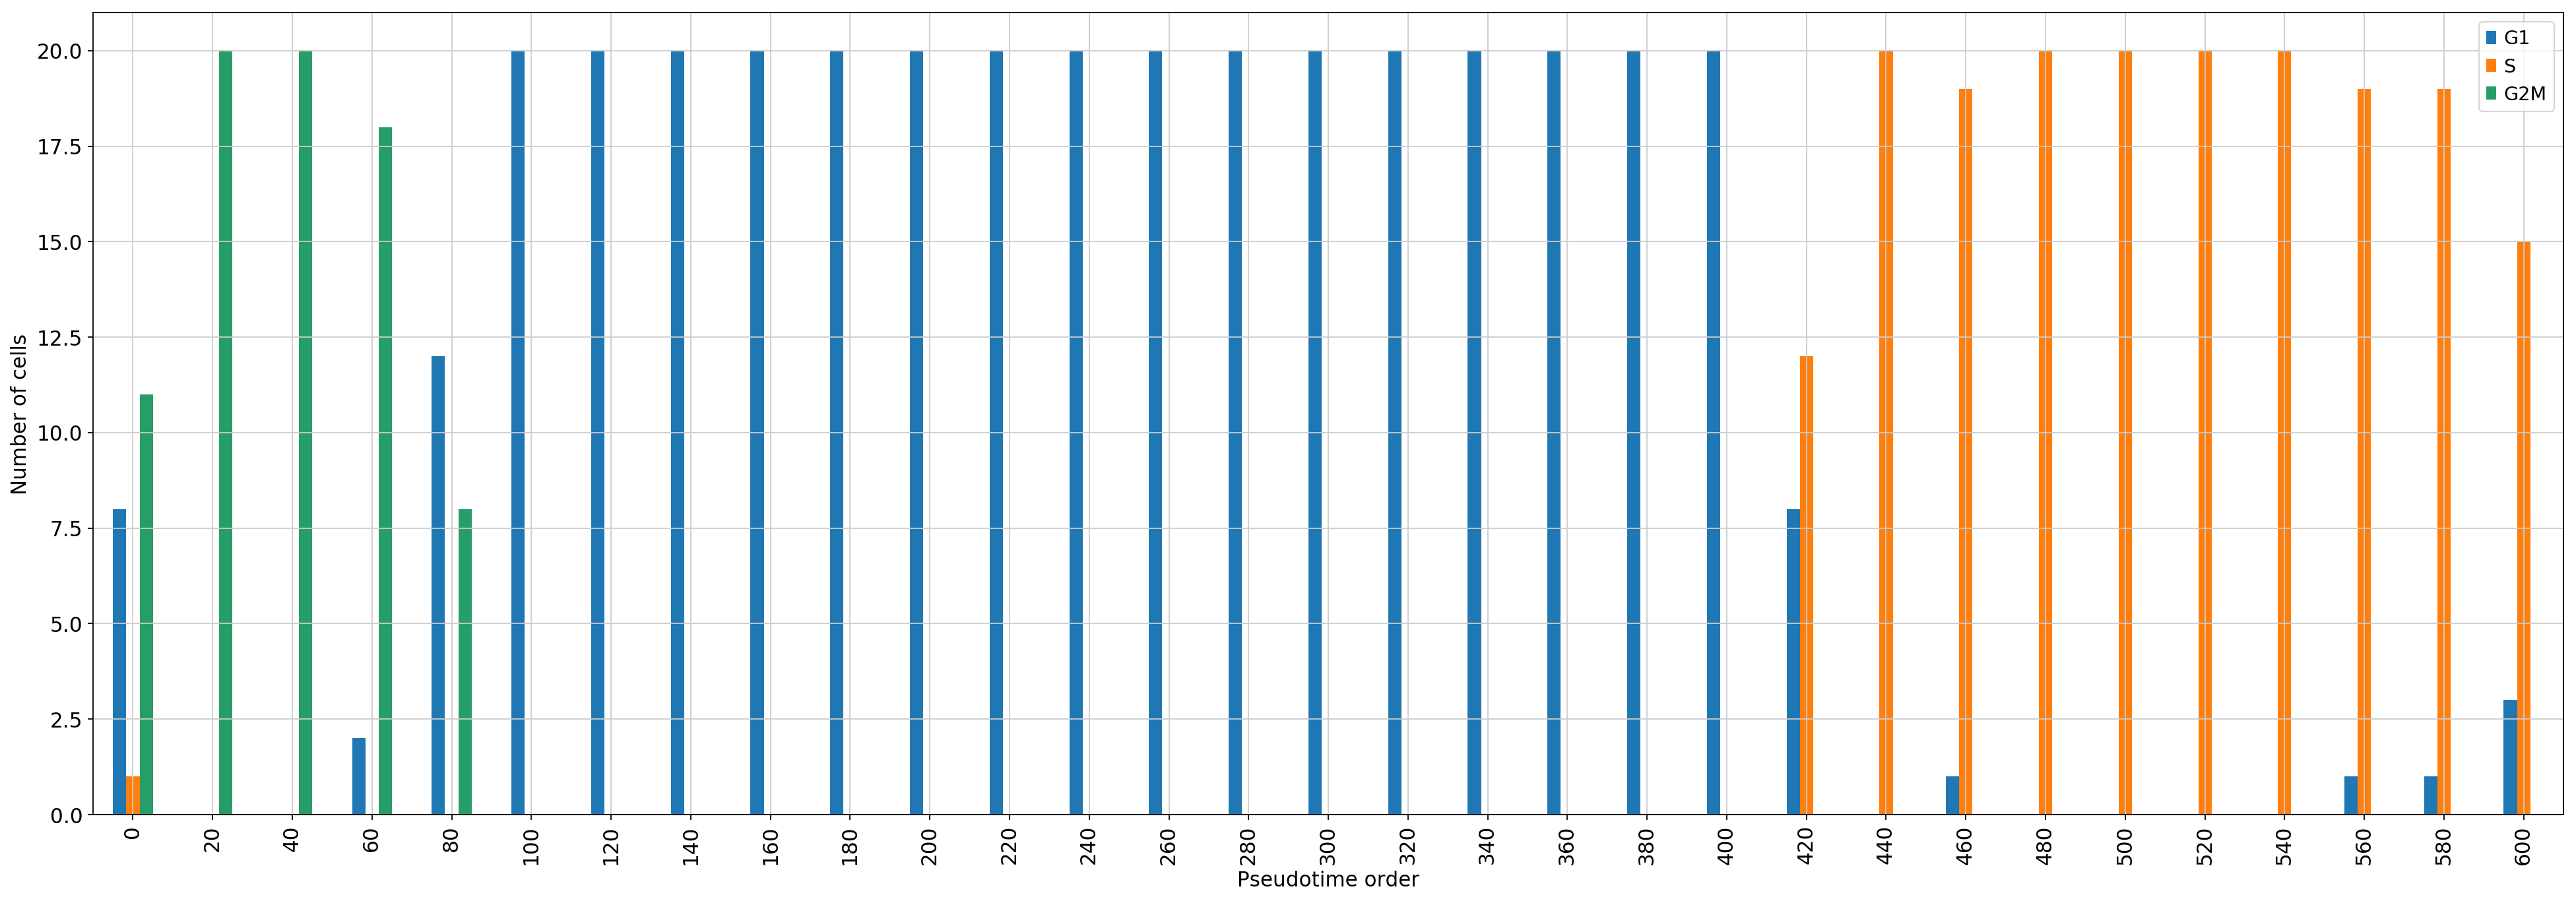

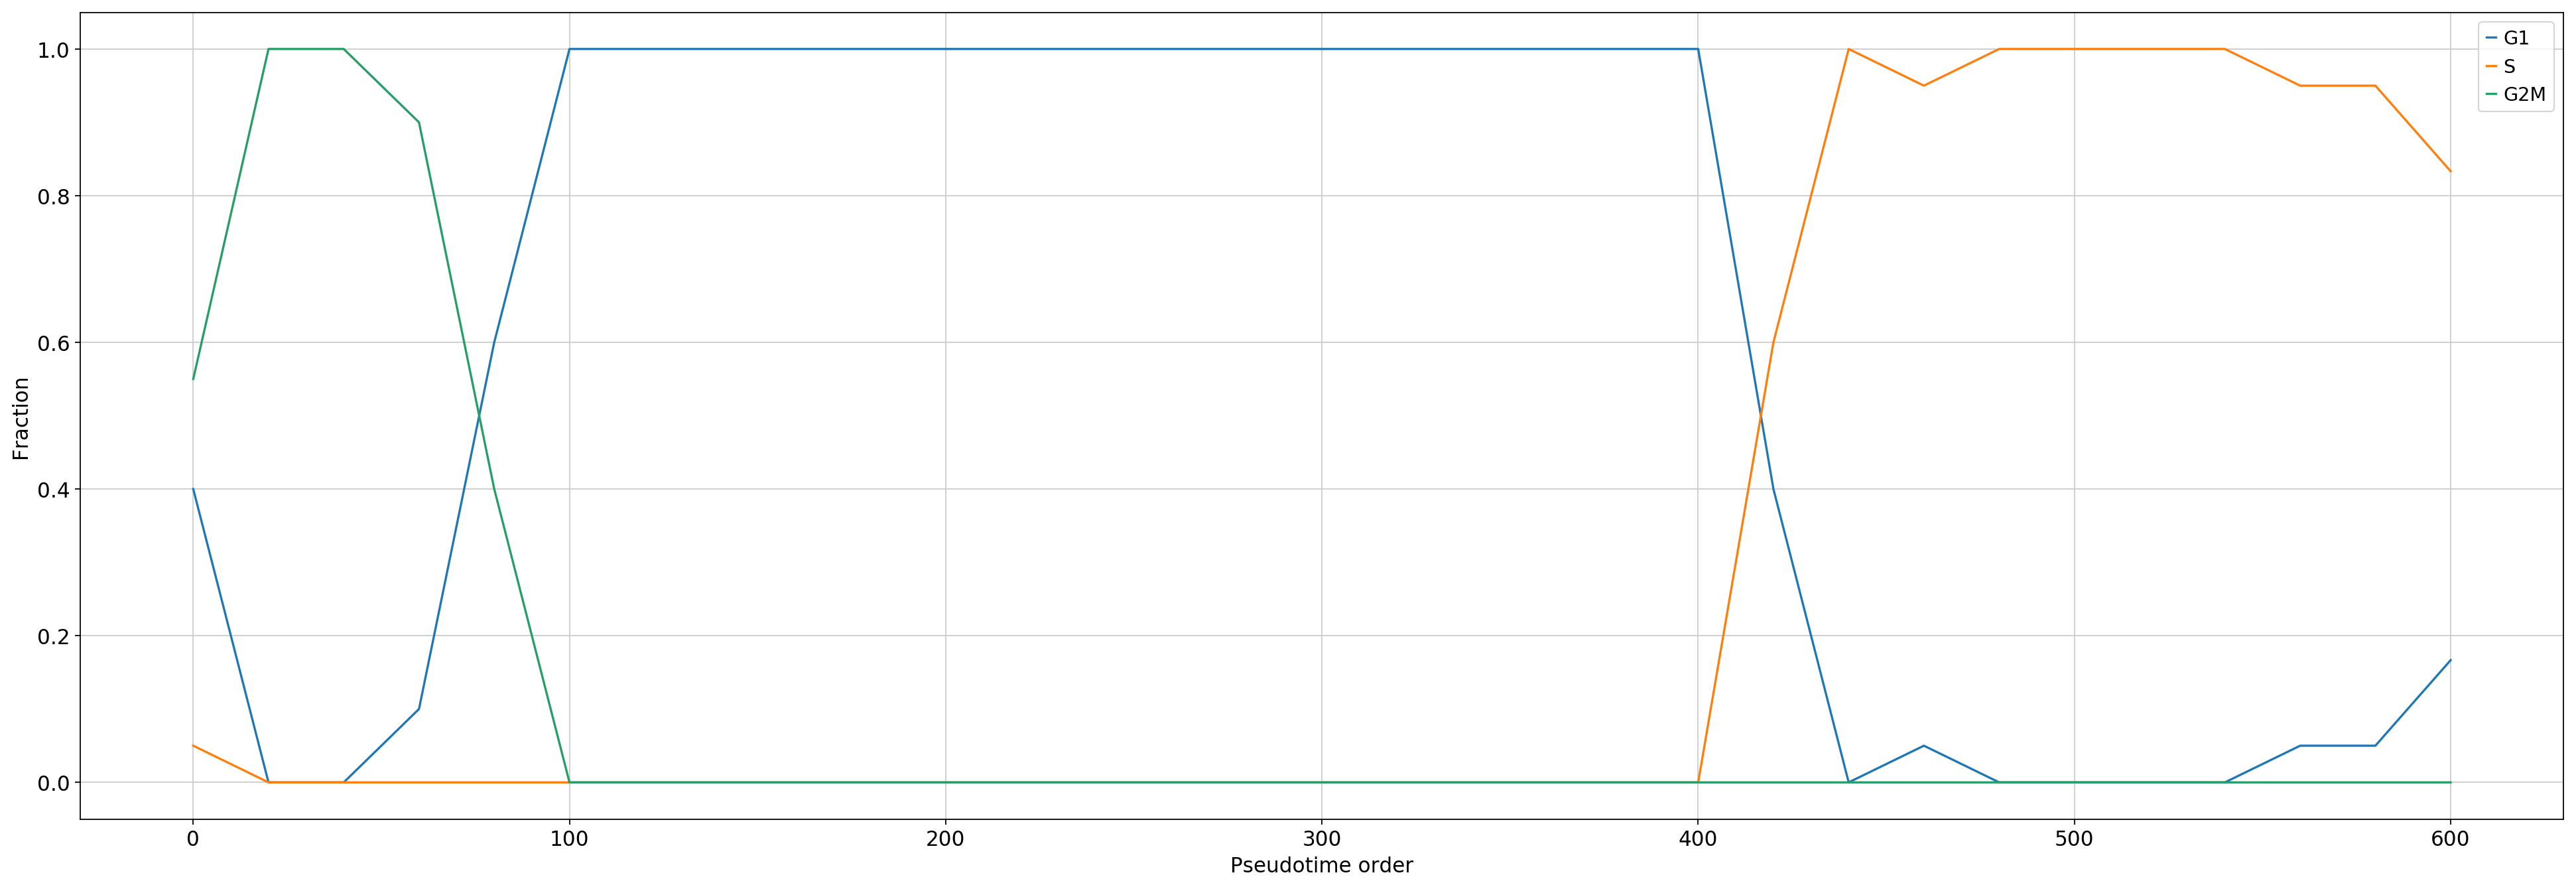

In [39]:
count_df, ratio_df = mscu.plot_phase_bar_dist(data_bb, 20, return_data=True, plot_path="./figures/293t/")

/mnt/work/geiramh/part2-single-cell/notebooks/myscutils/myscutils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data.obs['order'][data.obs['order'] < 0] += len(data.obs)
/mnt/work/geiramh/part2-single-cell/notebooks/myscutils/myscutils.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  values = count_df.as_matrix(columns=data_bb.obs['phase'].unique())


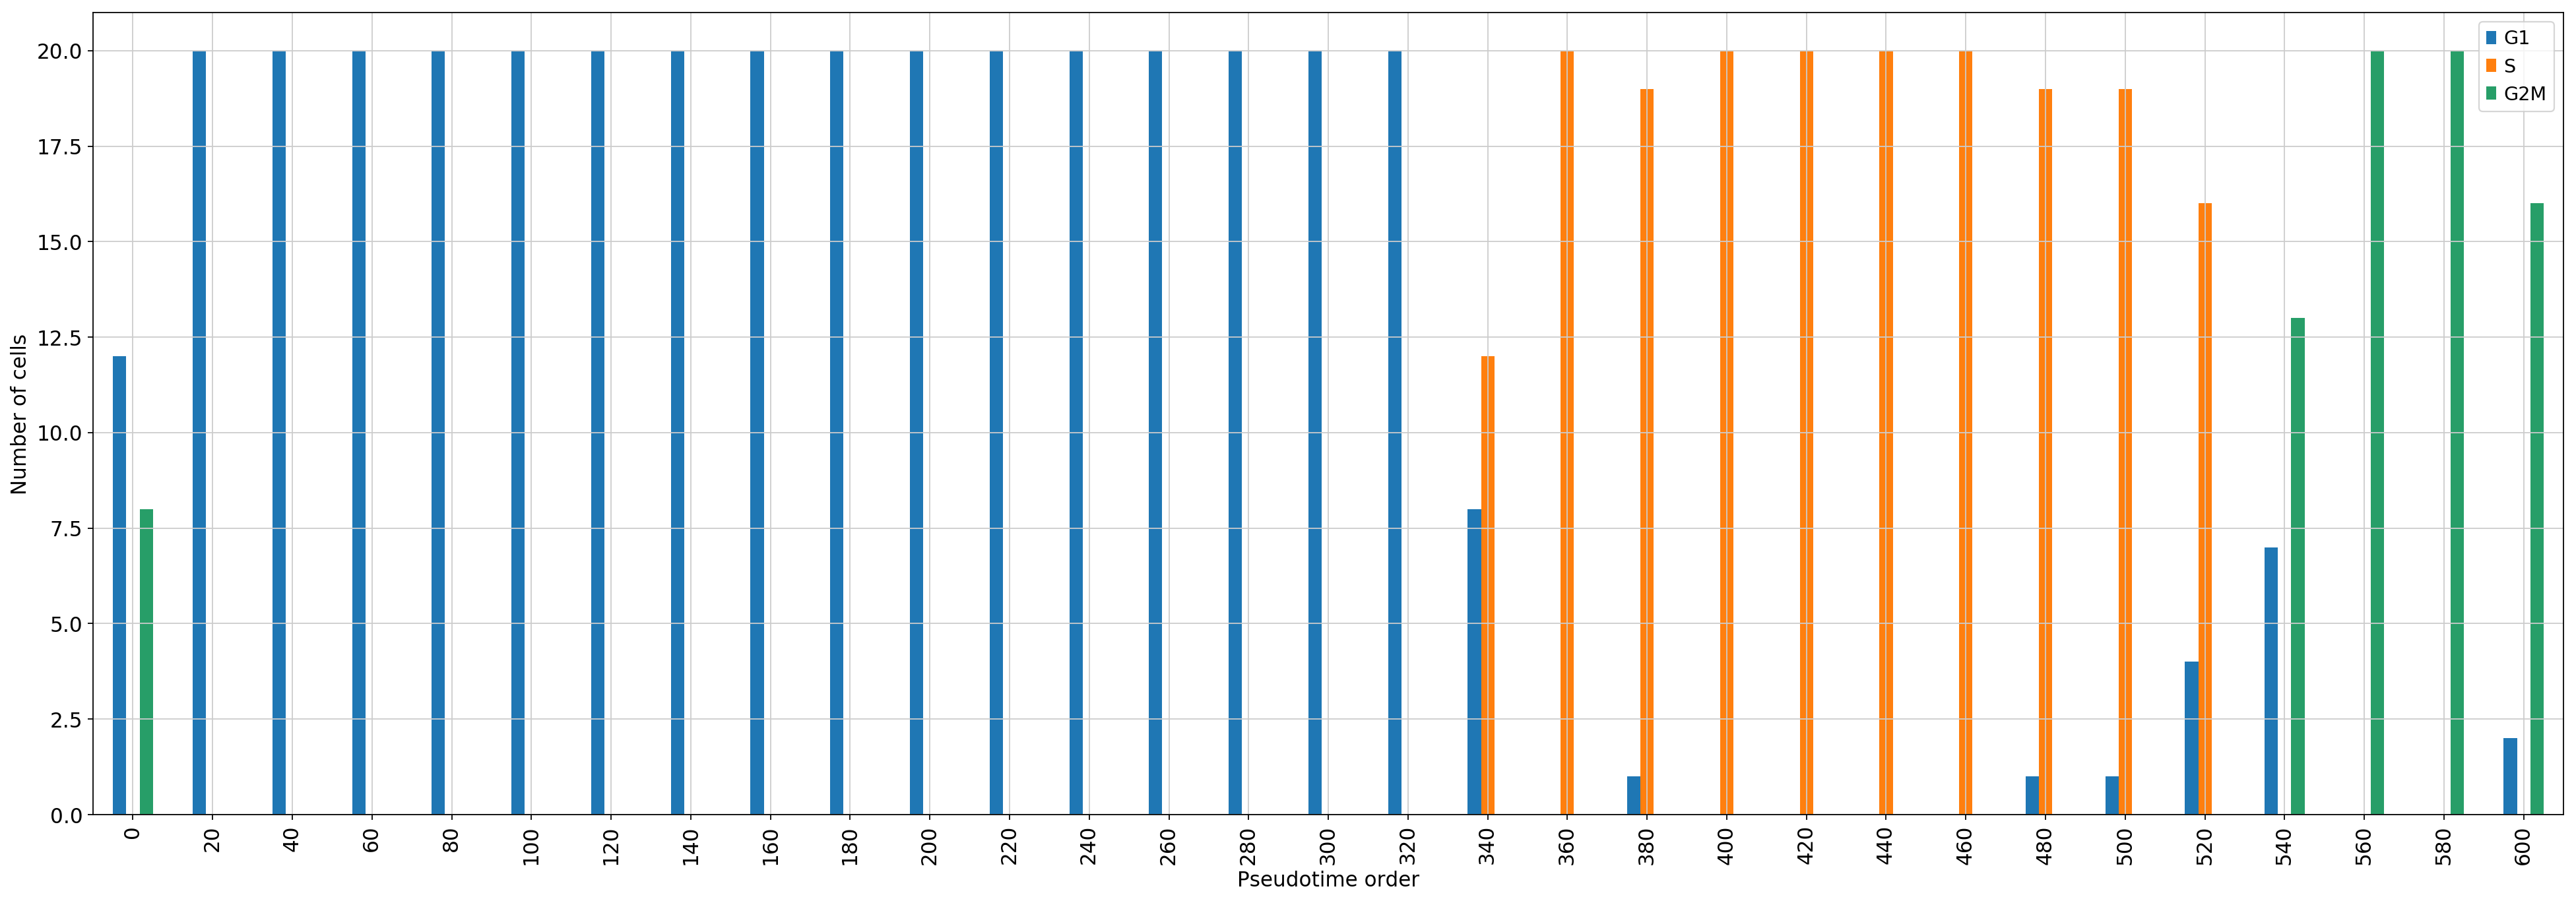

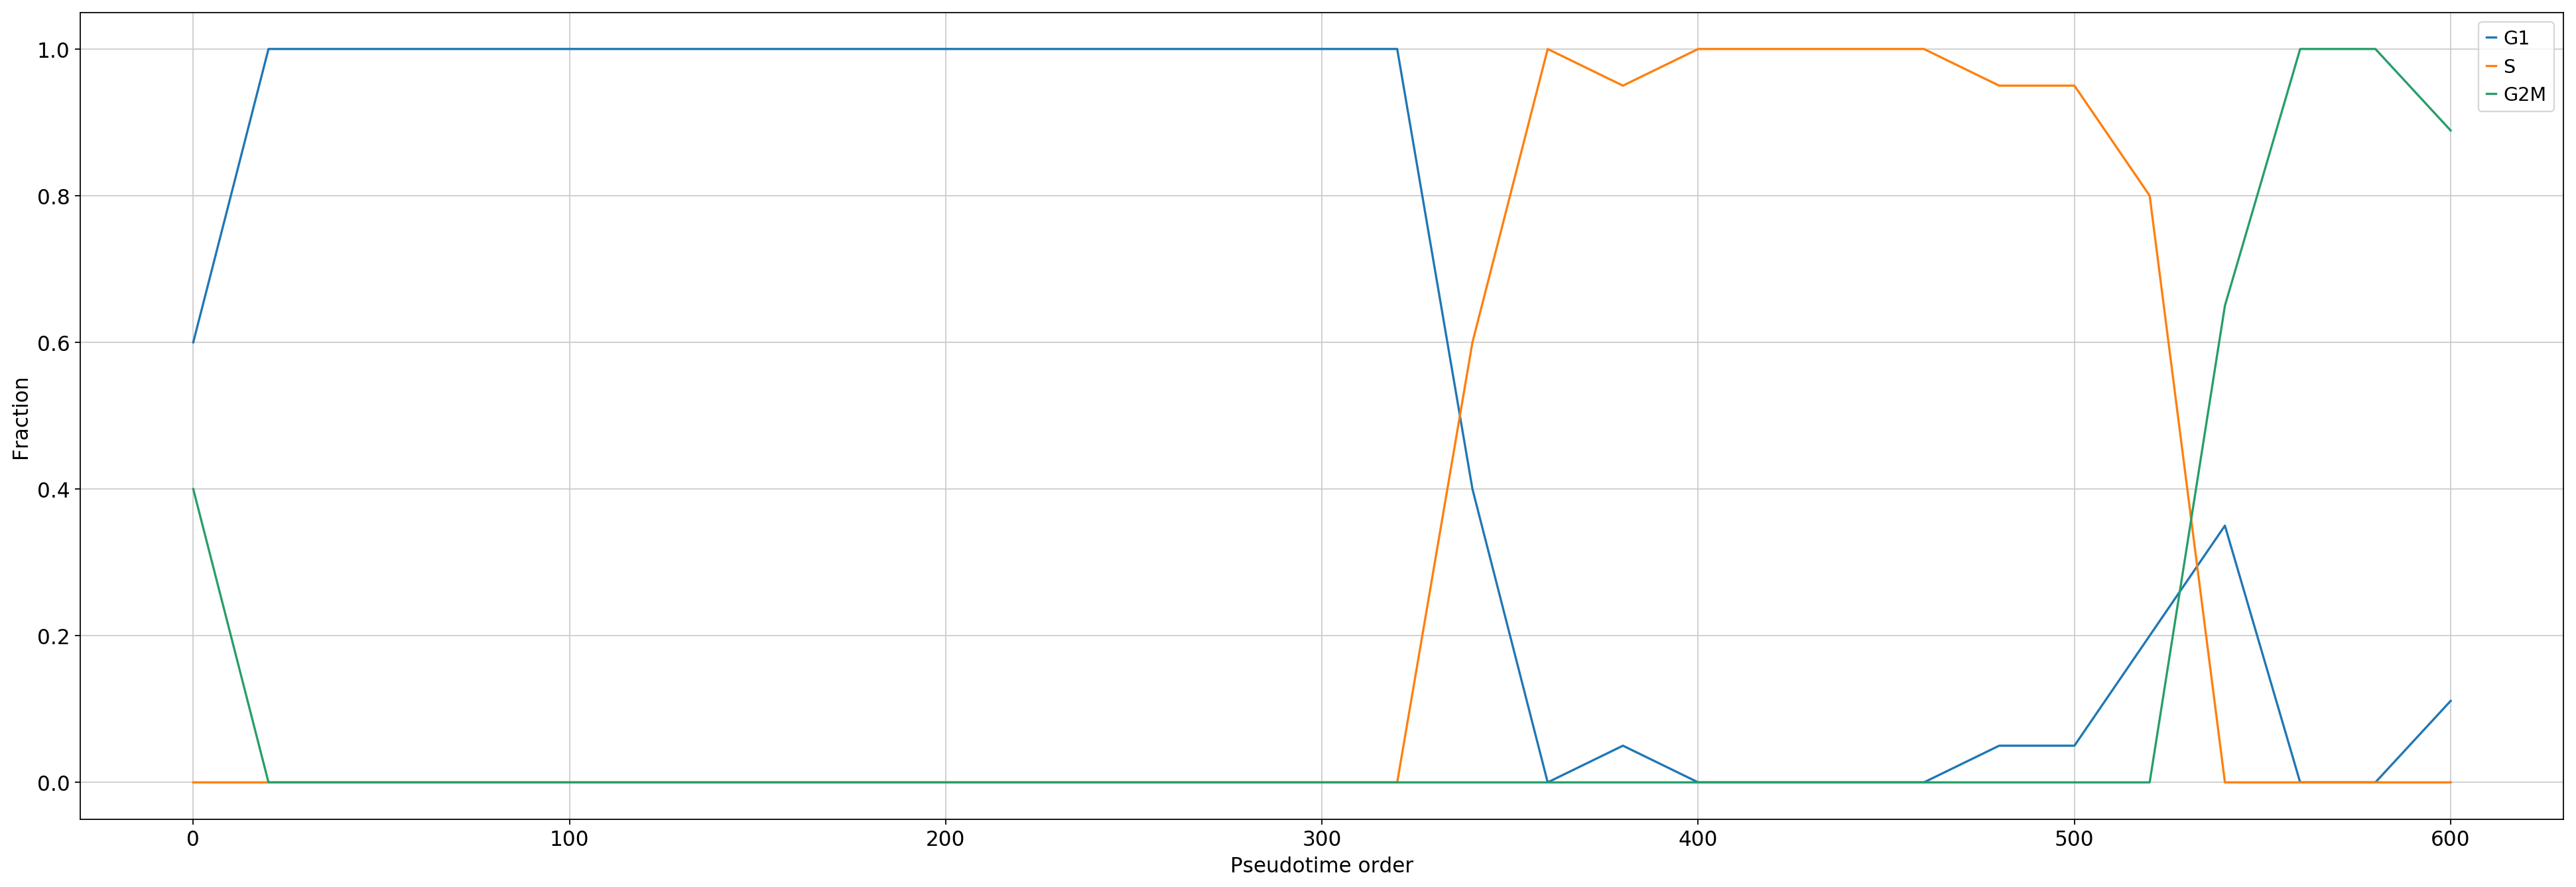

In [41]:
data_bb = mscu.shift_data(data_bb, 5, direction = 'negative', reverse=False)
count_df, ratio_df = mscu.plot_phase_bar_dist(data_bb,20,return_data=True,plot_path="./figures/293t/shifted_dist")

In [42]:
g1_start, s_start, g2m_start = mscu.find_phase_boundaries(data_bb,ratio_df)

In [43]:
print(g1_start,s_start,g2m_start)

0 333 531


In [44]:
data_bb.uns['phase_boundaries'] = {'g1_start': g1_start, 's_start': s_start, 'g2m_start': g2m_start}

In [45]:
data_bb.obs['time'] = mscu.get_times(data_bb)

saving figure to file ./figures/violin.pdf


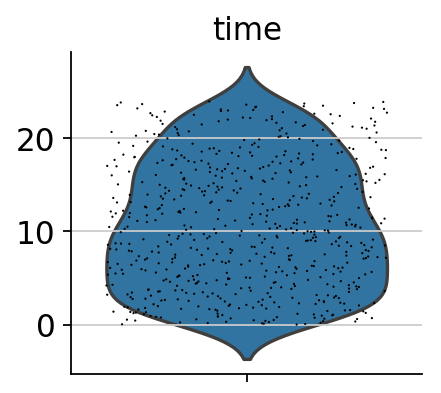

In [46]:
sc.pl.violin(data_bb, ['time'], jitter=0.4, multi_panel=True,save=True)

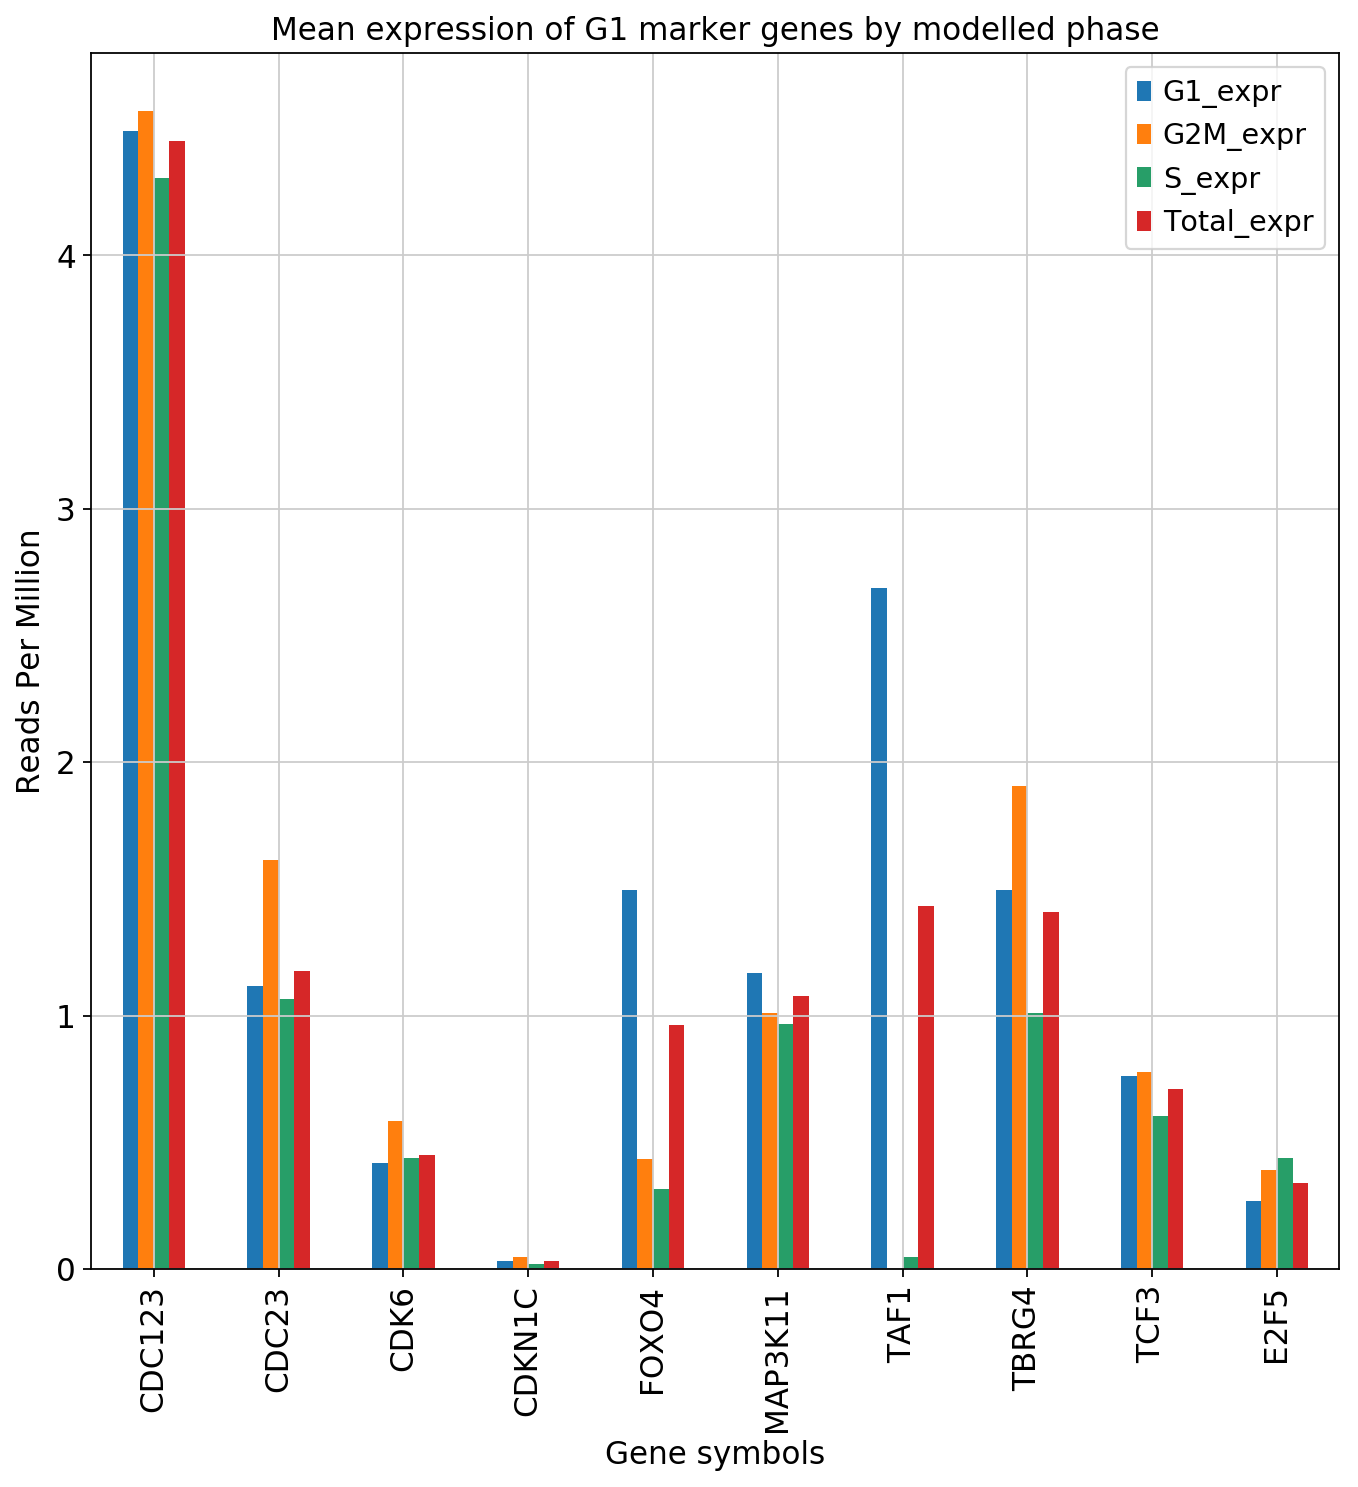

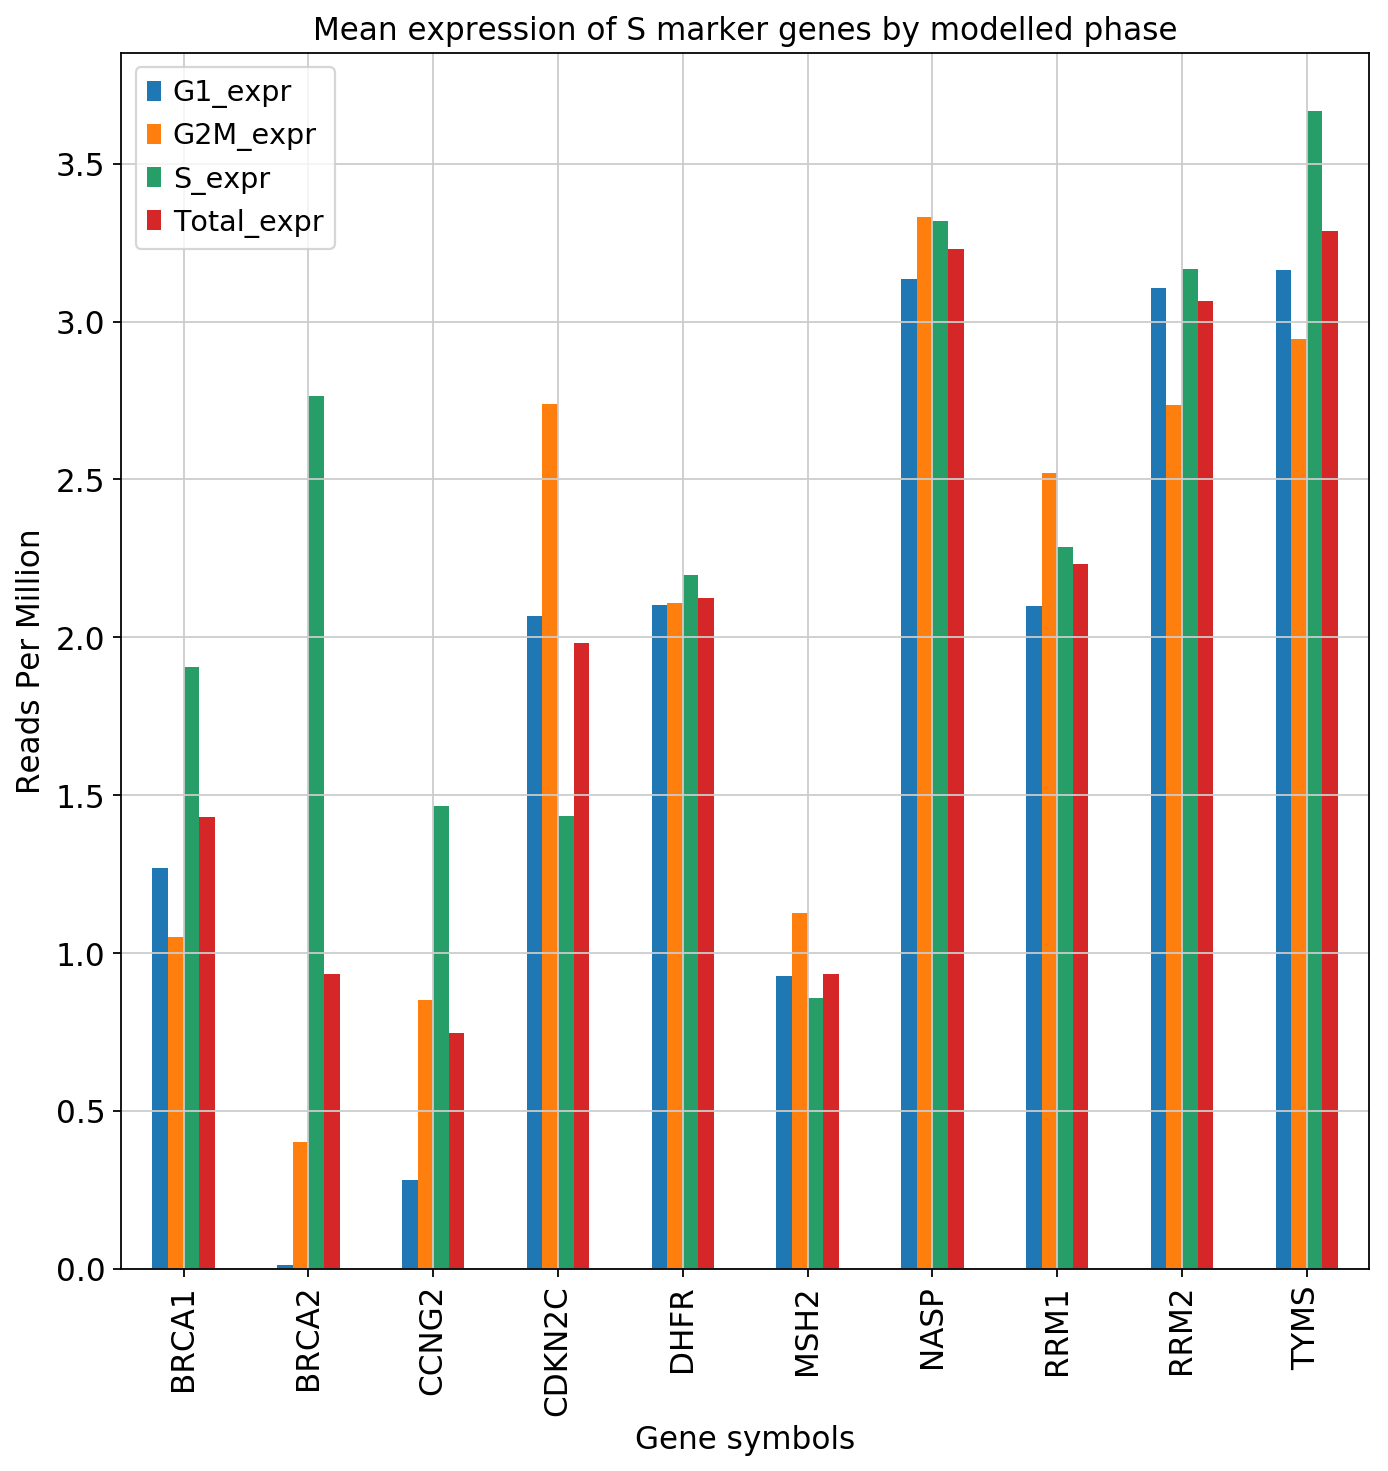

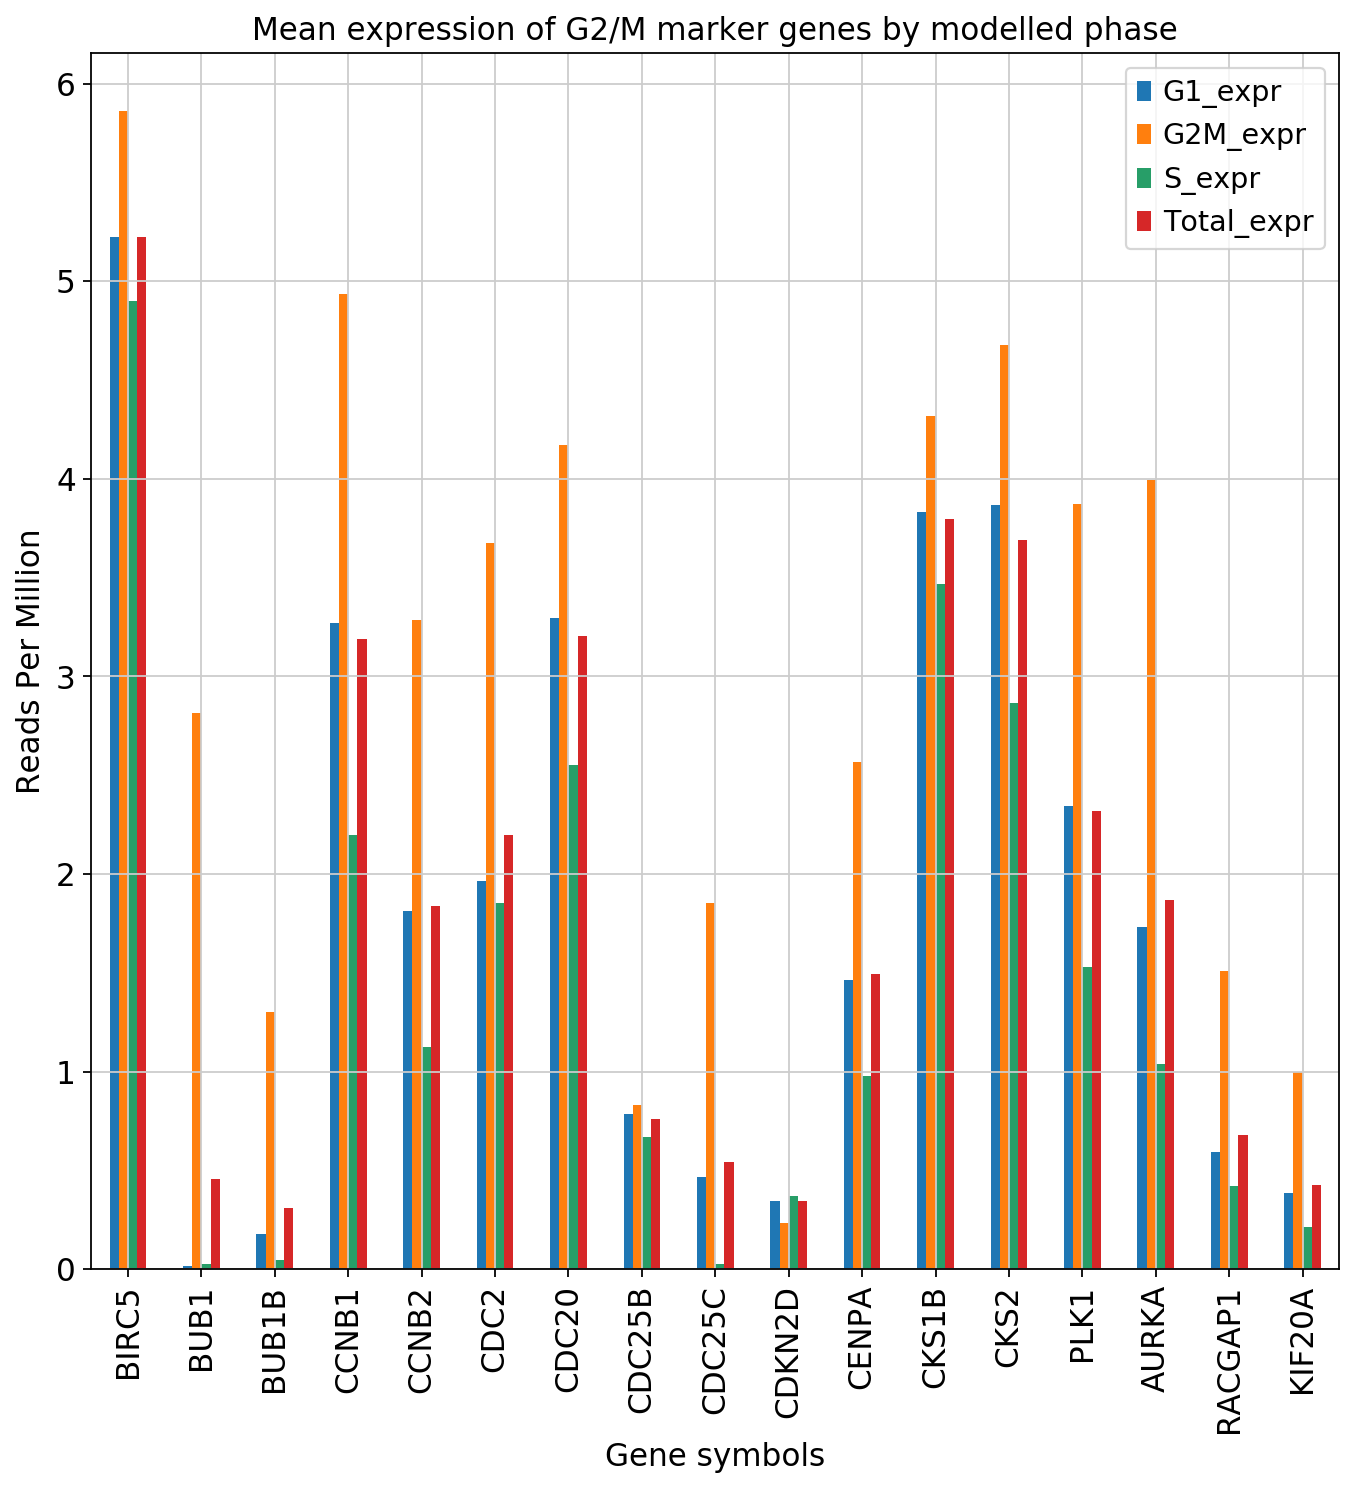

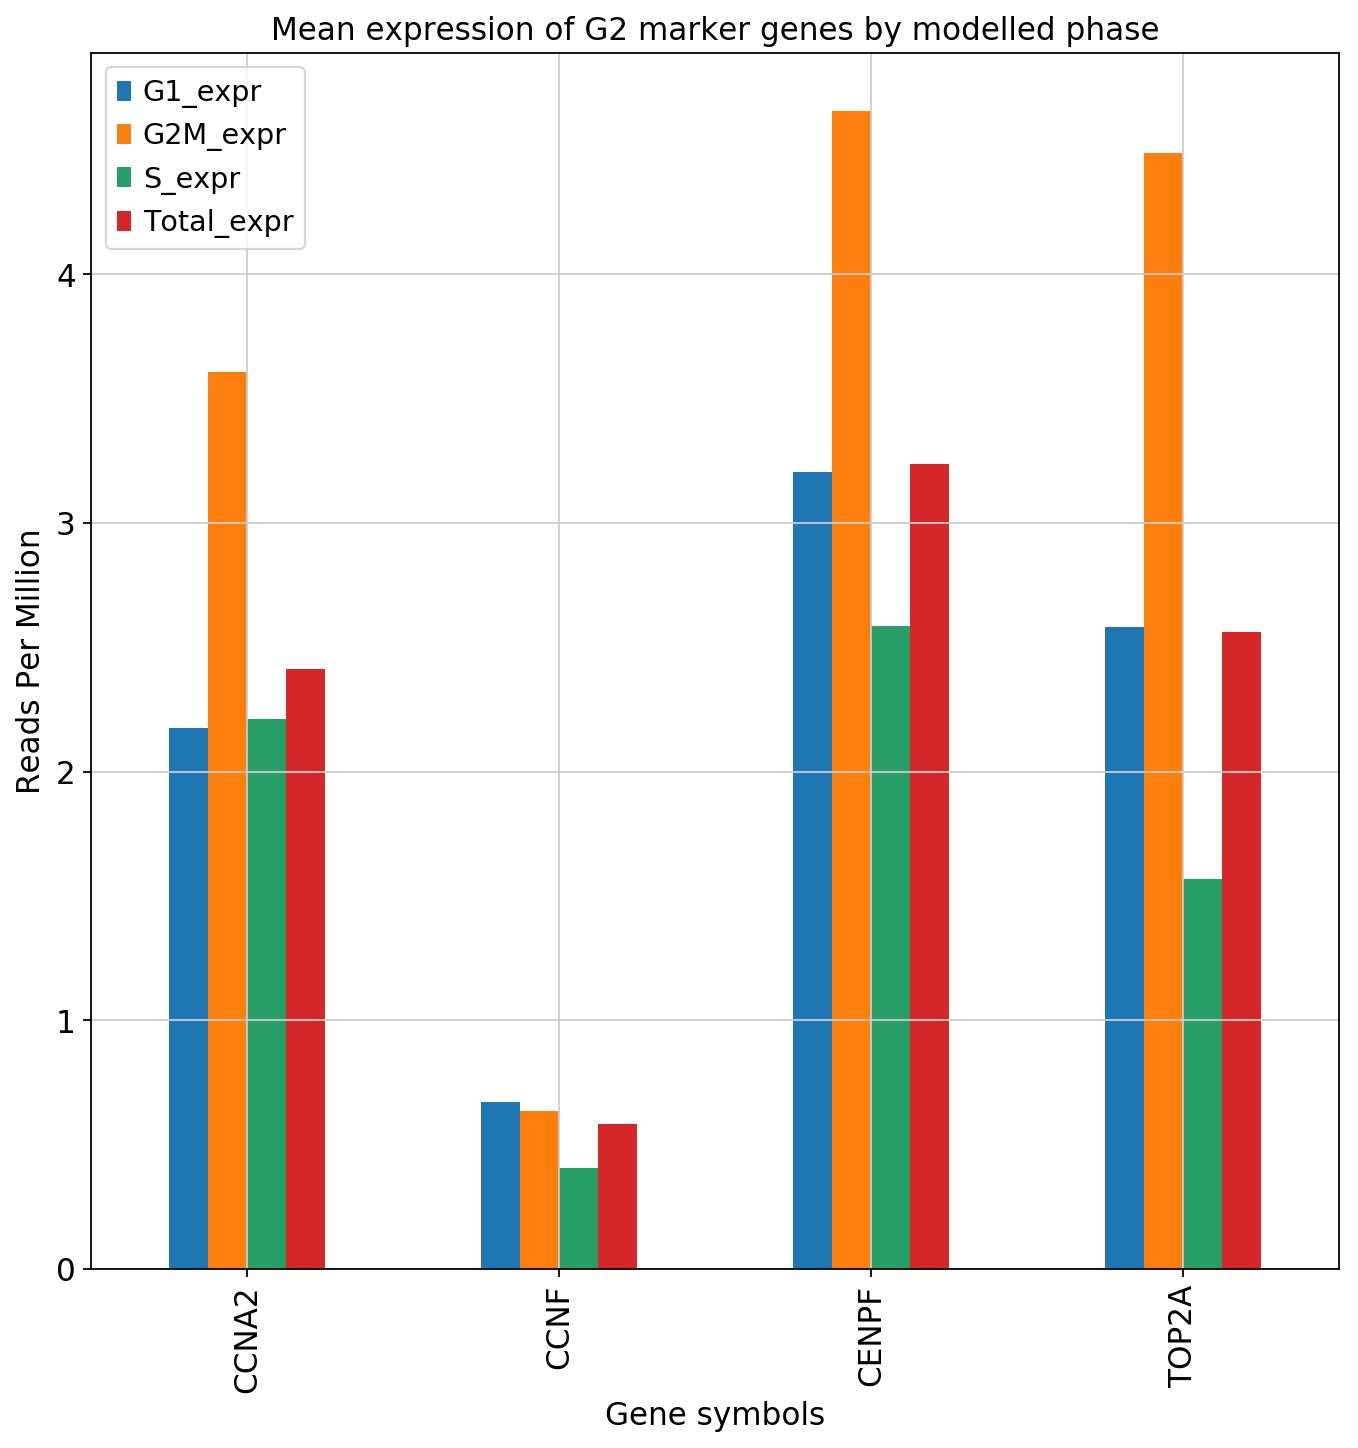

In [66]:
expression_df = mscu.compare_marker_genes_per_phase(data_bb, g1_start, s_start, g2m_start,plot_path="./figures/293t_test/")

In [49]:
#expression_df

In [50]:
mscu.score_ordering(expression_df)

G1
5/10 genes classified correctly
S
5/10 genes classified correctly
G2/M
16/17 genes classified correctly
G2
3/4 genes classified correctly
Total score: 29/41 classified correctly
Total percent 70.73 classified correctly


/mnt/work/geiramh/part2-single-cell/notebooks/myscutils/myscutils.py:229: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expr_mat = p_df[['G1_expr','S_expr','G2M_expr']].as_matrix()


saving figure to file ./figures/scatter.pdf


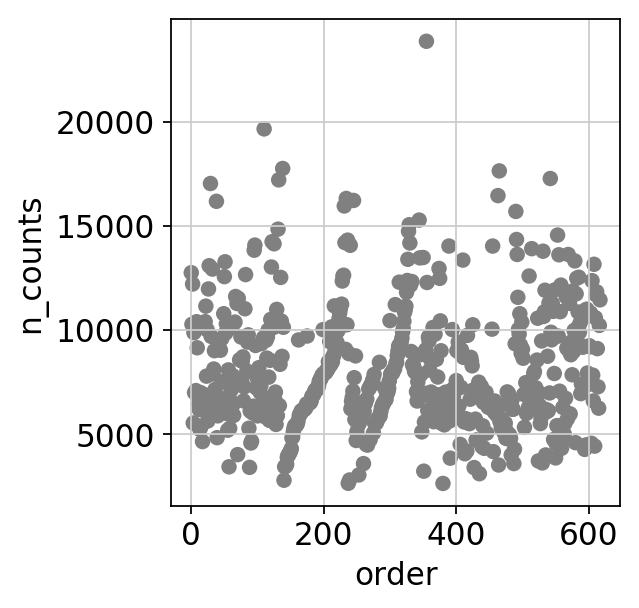

In [51]:
sc.pl.scatter(data_bb,x='order',y='n_counts',save=True)

##Cyclic Gene Expression Model

We now have an ordering of the cells and we wish to model the gene expressions with a model that is continous, cyclic and sufficiently smooth.
We use Smoothing Cubic Splines. Cubic splines consists of piecewise cubic polynomials that are C3 differentiable and continous everywhere. 
Cubic Splines are guided by the specified control points. The control points are pairs of (x,y) values that resulting cubic spline will pass through. 
An Interpolating Cubic Spline will interpolate all the control points specified and minimize the curvature of the piecewise polynomials through the control points.
A Smoothing Cubic Spline is freed from the contstaint of having to pass through the specified controlpoints. This allows us to have less curvature through the data, but maintain 
a unique solution, we must add a constraing. A Smoothing Cubic Spline wil also minimize the squared error through the data points.

We will use the library csaps. A csaps cubic smoothing spline takes a set of control points and a smoothing parameter as input. The smoothing parameter, i,lies between 0 and 1 where i=0 gives the least square straight line through the data and i=1 gives us the interpolating cubic spline through the data. We must find the optimal value for i for our data by specifying an objective function and minimize it over i. 

The control points will be constructed by sampling the mean values of a gene expression on fixed interval through the pseudotime ordering. The resulting mean value will be centered in the fixed interval. 

To make the cubic spline cyclic, that is continous and twice differentiable and the phase boundaries, we make the control points cyclic by copying the gene expression values to the lef (-24,0) and to the right (24,48). To emphasize the model should be continous on the phase boundaries, we will add control points to phase boundary that will have the mean value of the mean expression in the first and the last fixed interval. 

In [52]:
import importlib
import myscutils.myscutils as mscu
importlib.reload(mscu)


Running Scanpy 1.3.7 on 2019-09-04 12:10.
Dependencies: anndata==0.6.17 numpy==1.15.4 scipy==1.2.0 pandas==0.23.4 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


<module 'myscutils.myscutils' from '/mnt/work/geiramh/part2-single-cell/notebooks/myscutils/myscutils.py'>

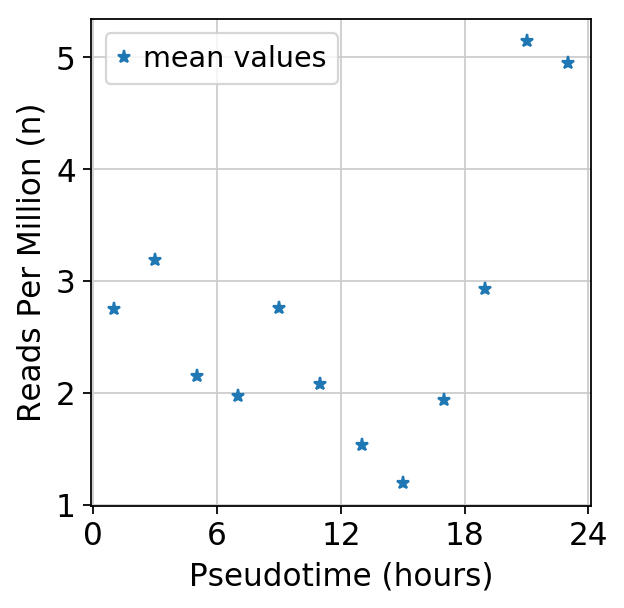

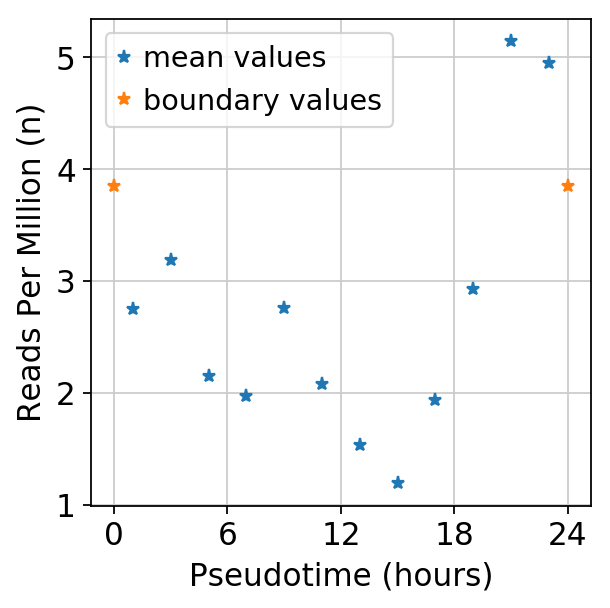

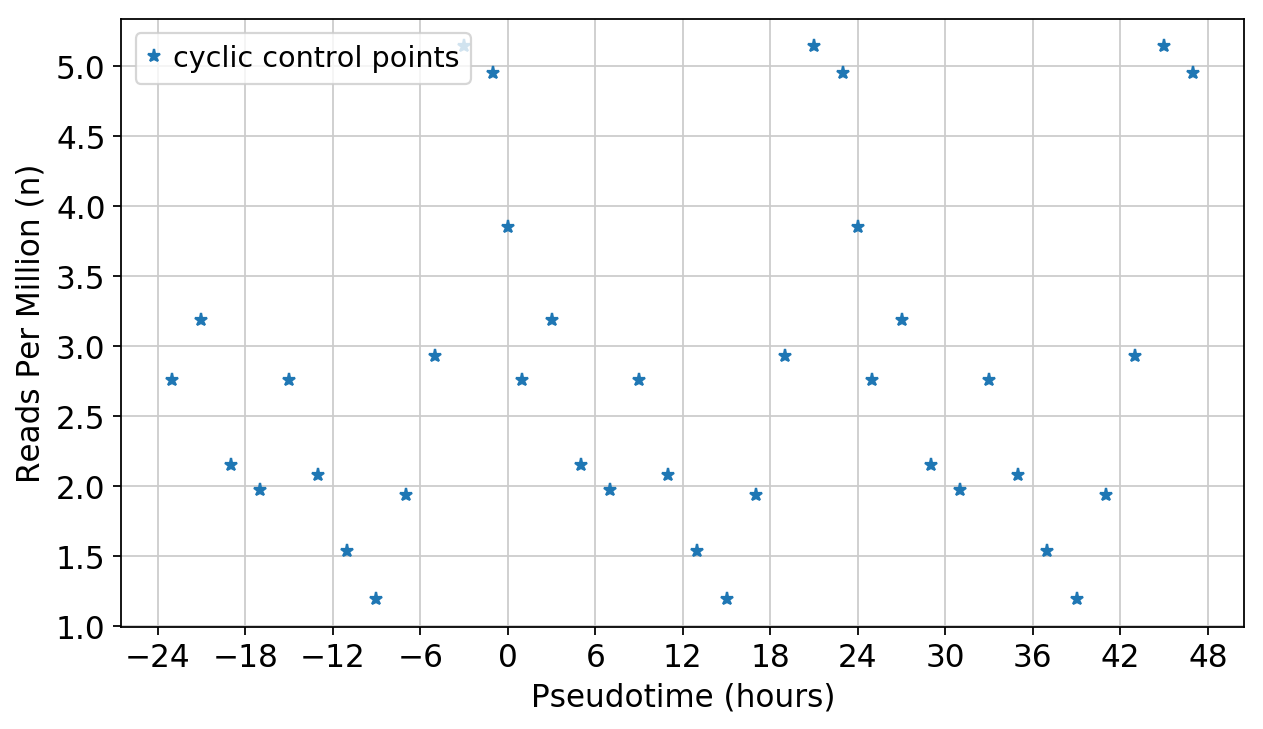

In [71]:
mscu.demo_control_points(data_bb,"ENSG00000131747")

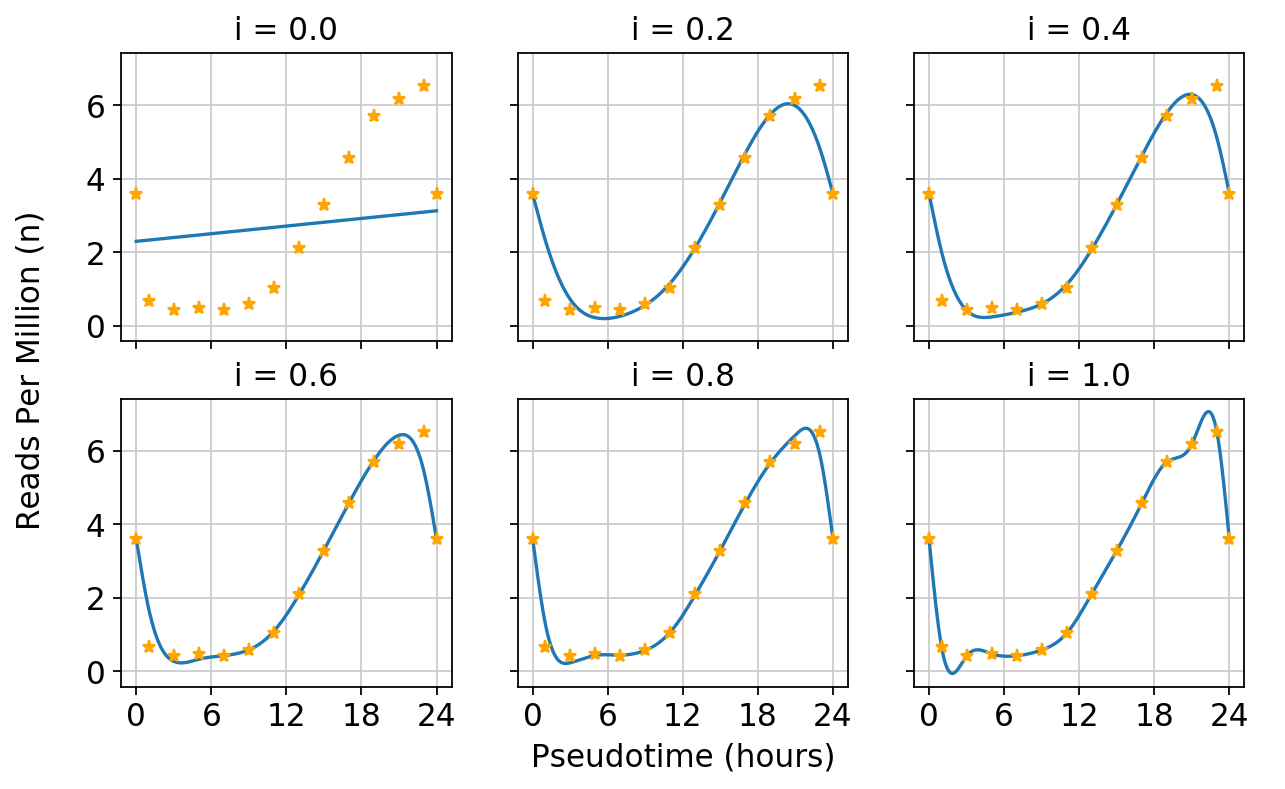

In [41]:
mscu.csaps_demo_smoothing_param(data_bb,"ENSG00000131747")

We want the model to be optimal for genes with a strong cyclic expression. Hence, we choose only a limited subset of genes with very good cyclic profiles and minimize the objective function across this subset.

Calculating for smooth parameter = 0.0
Calculating for smooth parameter = 0.05
Calculating for smooth parameter = 0.1
Calculating for smooth parameter = 0.15000000000000002
Calculating for smooth parameter = 0.2
Calculating for smooth parameter = 0.25
Calculating for smooth parameter = 0.30000000000000004
Calculating for smooth parameter = 0.35000000000000003
Calculating for smooth parameter = 0.4
Calculating for smooth parameter = 0.45
Calculating for smooth parameter = 0.5
Calculating for smooth parameter = 0.55
Calculating for smooth parameter = 0.6000000000000001
Calculating for smooth parameter = 0.65
Calculating for smooth parameter = 0.7000000000000001
Calculating for smooth parameter = 0.75
Calculating for smooth parameter = 0.8
Calculating for smooth parameter = 0.8500000000000001
Calculating for smooth parameter = 0.9
Calculating for smooth parameter = 0.9500000000000001
Calculating for smooth parameter = 1.0


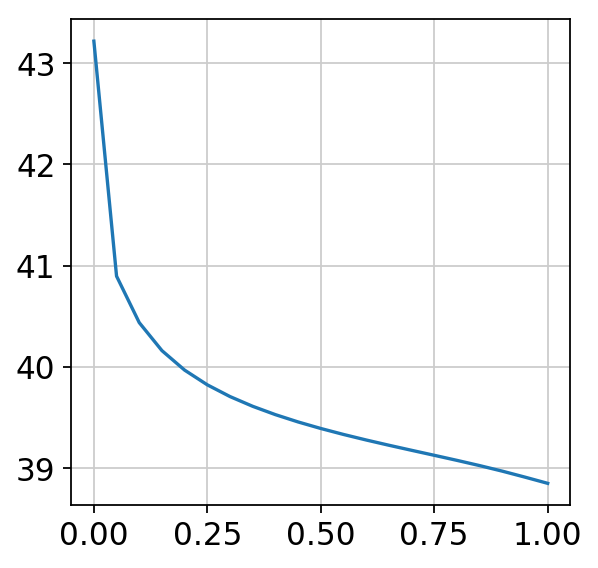

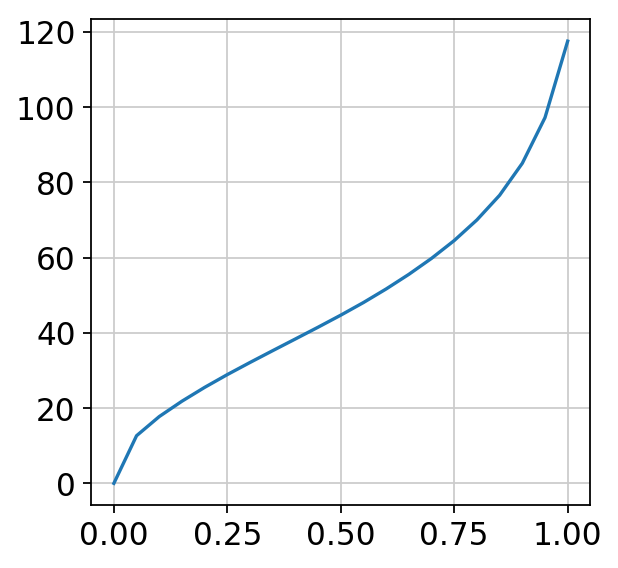

In [54]:
report_df = pd.read_csv("./data/known_plus_regev.csv", index_col=0)
#report_df = pd.read_csv("./data/knownGenes_derived.txt", sep=" ")
#report_df = pd.read_csv("./data/knownGenes_report_plot.txt", sep=" ")
mean_norm = []
mean_sum_curvature = []
for i in np.arange(0,1.05,0.05):
    print("Calculating for smooth parameter = {}".format(i))
    for p in ['S','G2/M','G2','G1']:
        residuals = {}
        p_df = report_df[report_df['phase'] == p]
        ens_list = list(set(list(p_df['Ensembl'])).intersection(list(data_bb.var.index)))
        r = mscu.csaps_error(data_bb, ens_list, csaps_smooth=i, subsample_width=2)
        residuals.update(r)
    res_df = pd.DataFrame.from_dict(residuals,orient='index')
    mean_norm.append(res_df['res_2-norm'].mean())
    mean_sum_curvature.append(res_df['sum_curvature'].mean())
plt.figure()
plt.plot(np.arange(0,1.05,0.05),mean_norm)
plt.figure()
plt.plot(np.arange(0,1.05,0.05),mean_sum_curvature)

In [55]:
i = np.arange(0,1.05,0.05)

In [56]:
### SCALE AND SOLVE 

In [57]:
scaled_mean_norm = np.array([x - np.min(mean_norm) for x in mean_norm])
scaled_mean_norm /= np.max(scaled_mean_norm)

In [58]:
scaled_mean_curve = np.array([x - np.min(mean_sum_curvature) for x in mean_sum_curvature])
scaled_mean_curve /= np.max(scaled_mean_curve)

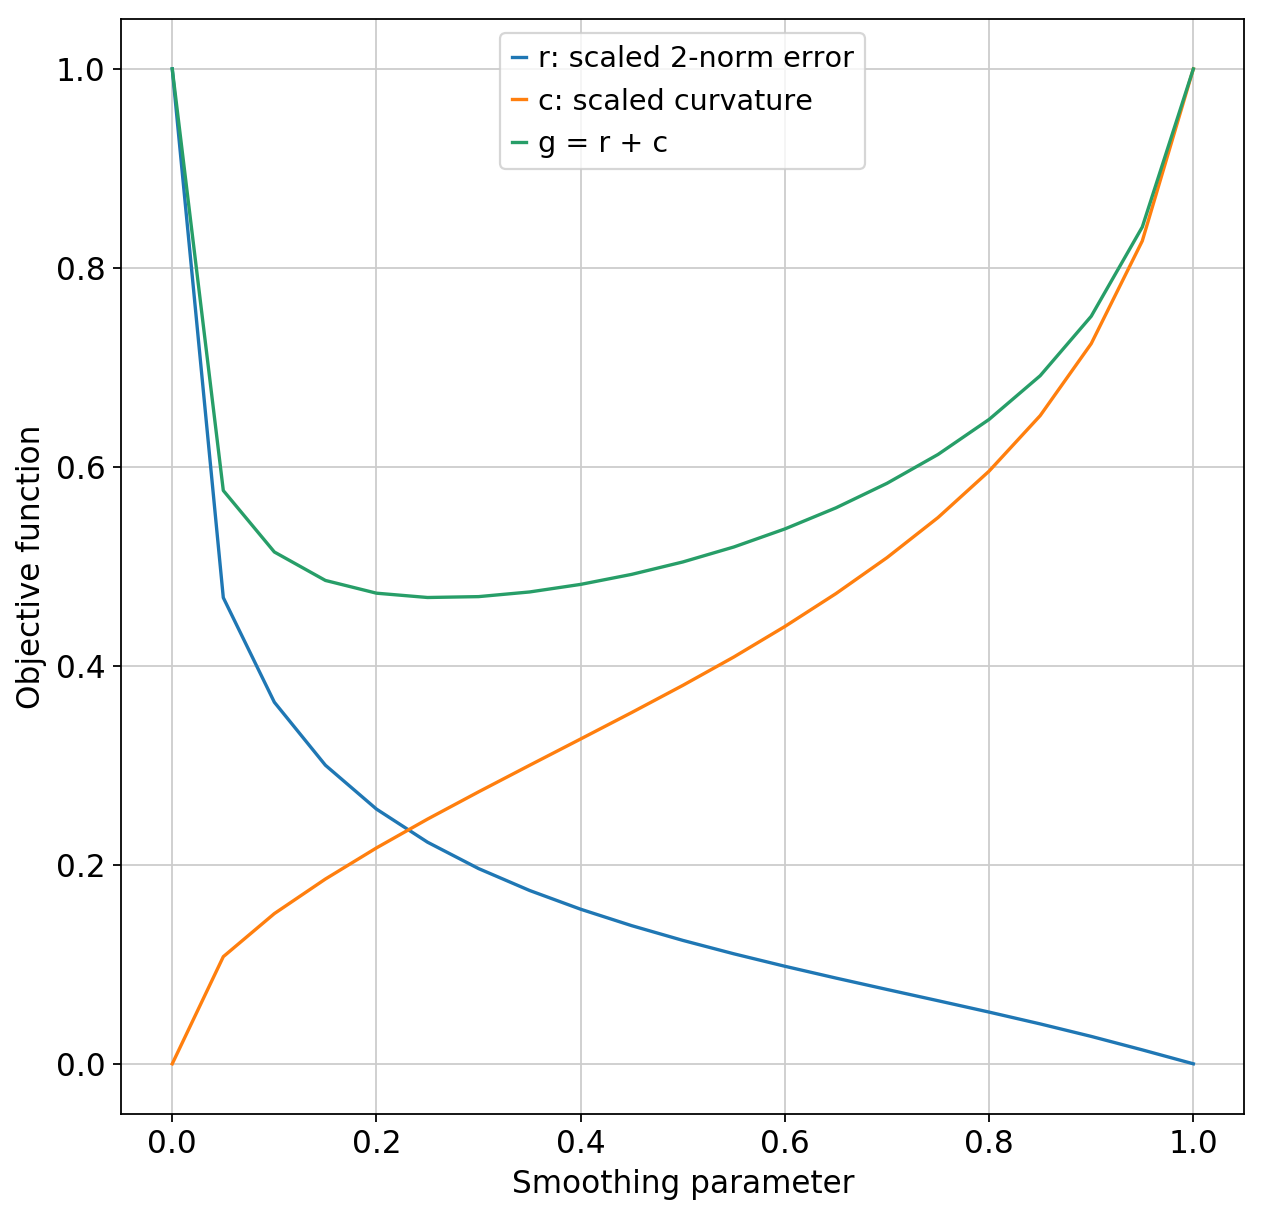

In [59]:
plt.figure(figsize=(9,9))
plt.plot(i,scaled_mean_norm,label='r: scaled 2-norm error')
plt.plot(i,scaled_mean_curve,label='c: scaled curvature')
plt.plot(i,scaled_mean_curve+scaled_mean_norm,label='g = r + c')
plt.xlabel("Smoothing parameter")
plt.ylabel("Objective function")
plt.legend()
plt.savefig("./figures/293t/objective_function.png")

In [60]:
from scipy.interpolate import interp1d
t = np.arange(0,1,0.01)
intp = interp1d(i,scaled_mean_curve+scaled_mean_norm)
opt_smooth = t[np.where(intp(t) == np.min(intp(t)))[0][0]]
print(opt_smooth)


0.25


In [73]:
#opt_smooth += 0.1

Plotting known G1 genes
Plotting known S genes
Plotting known G2/M genes
Plotting known G2 genes


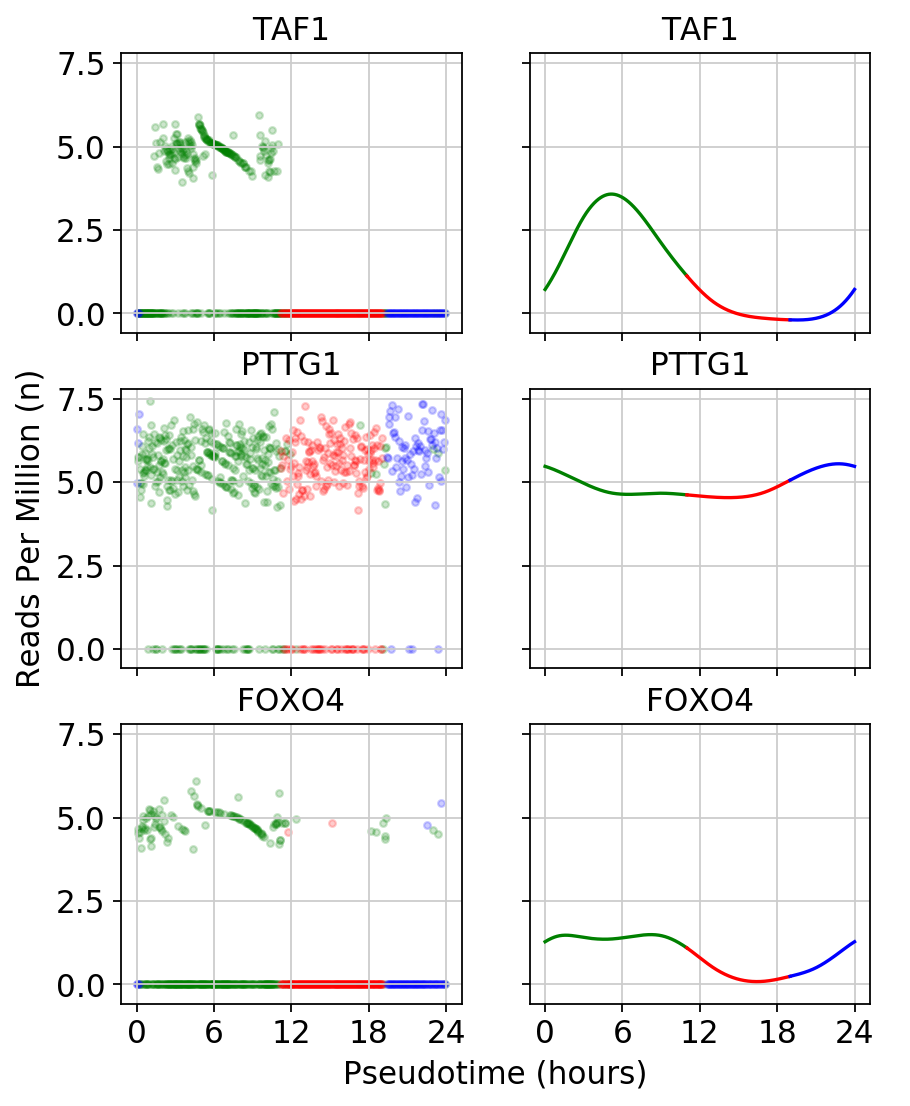

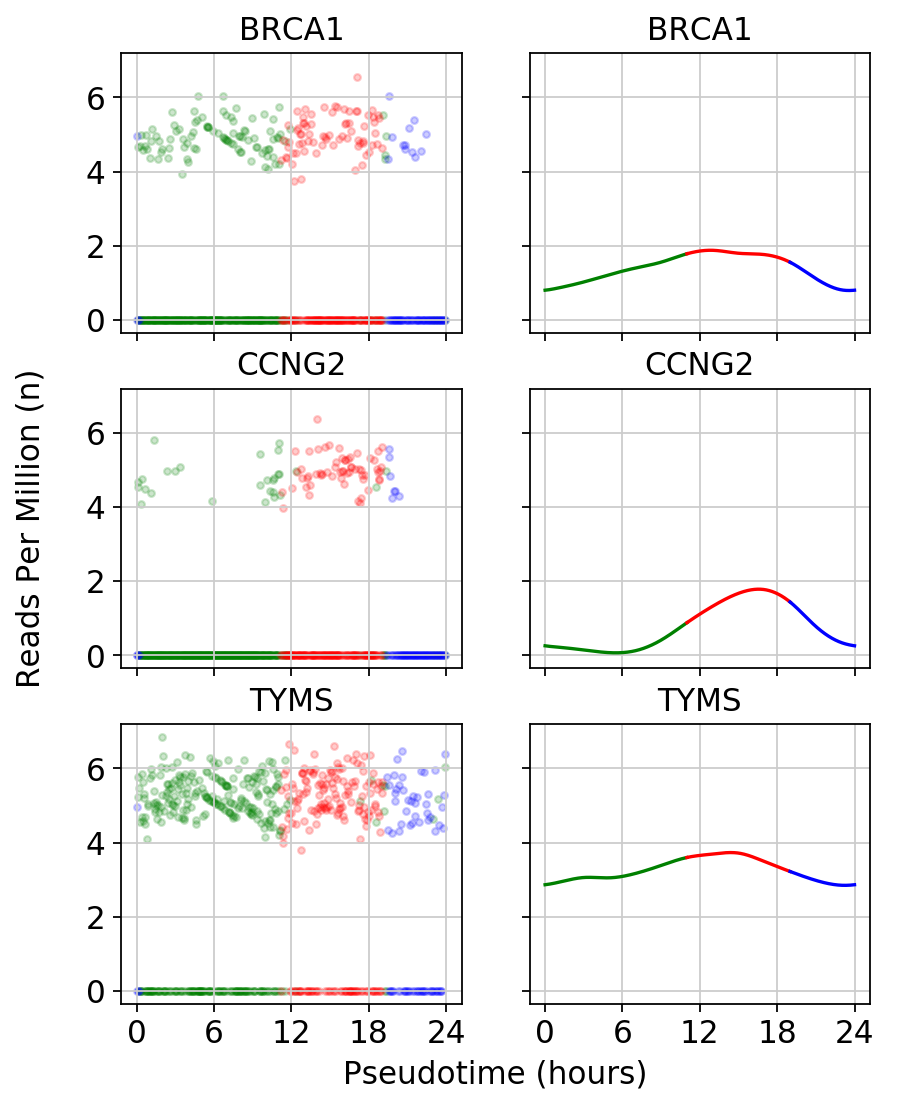

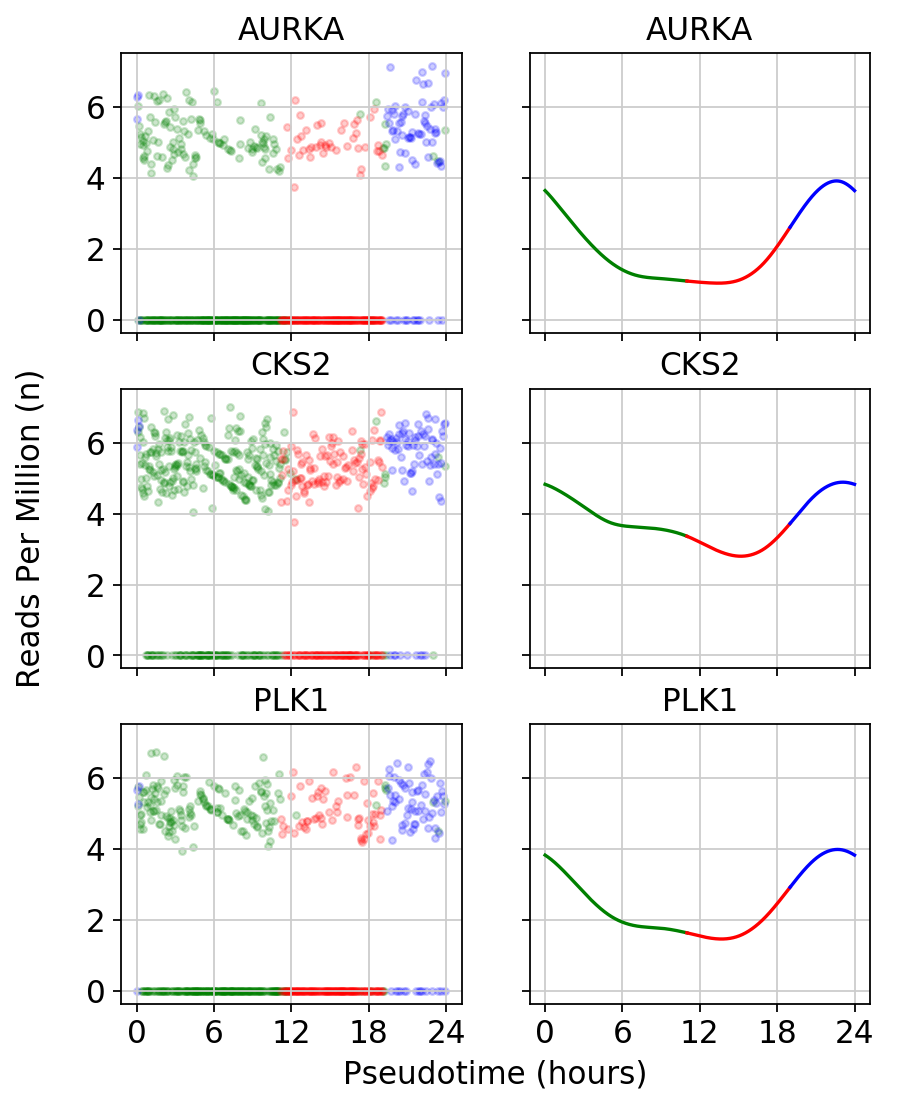

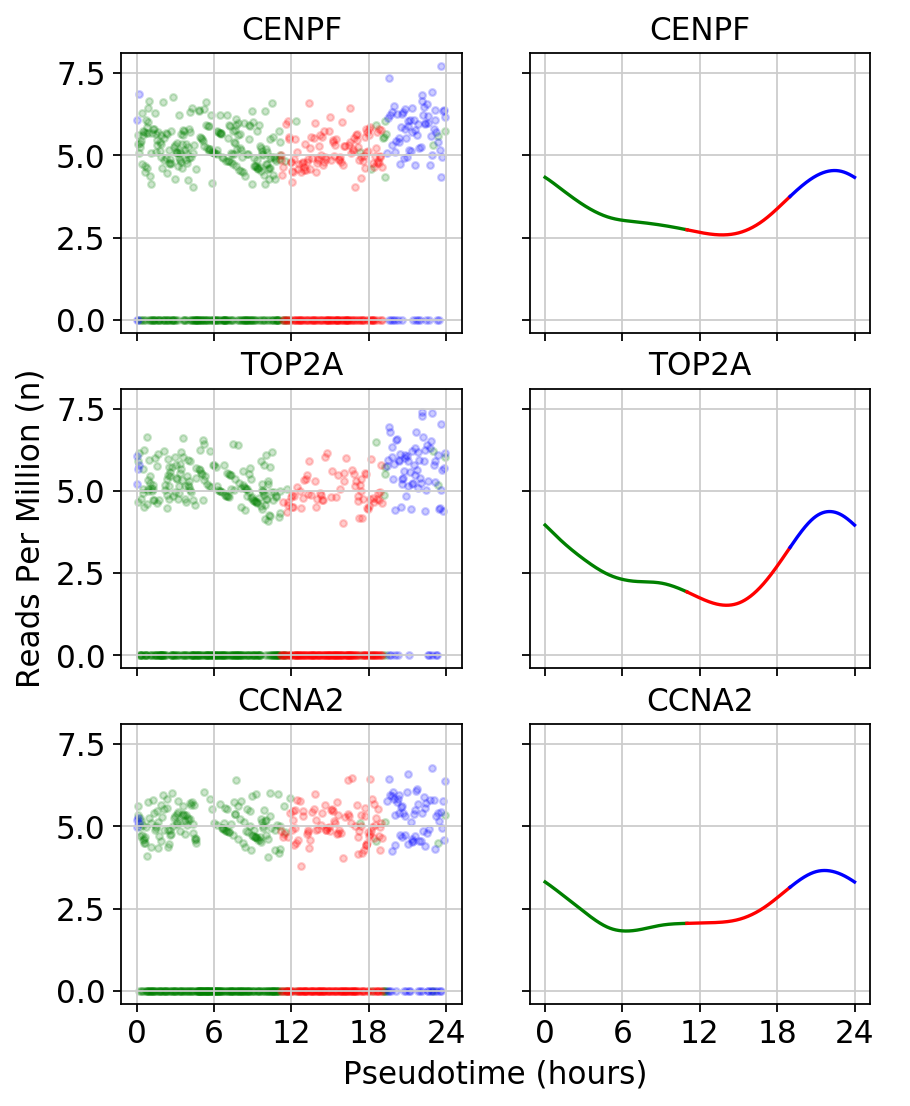

In [69]:
report_df = pd.read_csv("./data/knownGenes_report_plot_293t.txt", sep=" ")
for p in ['G1','S','G2/M','G2']:
    print("Plotting known {} genes".format(p))
    p_df = report_df[report_df['phase'] == p]
    ens_list = list(set(list(p_df['Ensembl'])).intersection(list(data_bb.var.index)))
    mscu.plot_scatter_with_splines(data_bb, ens_list, color_phase=True, csaps_smooth=opt_smooth, plot_ctrl_pts=False, plot_filename='figures/293t/scatter_with_spline_{}.png'.format(p.replace('/','-')))

Plotting known M/G1 genes
Plotting known G1 genes
Plotting known S genes
Plotting known G2/M genes
Plotting known G2 genes


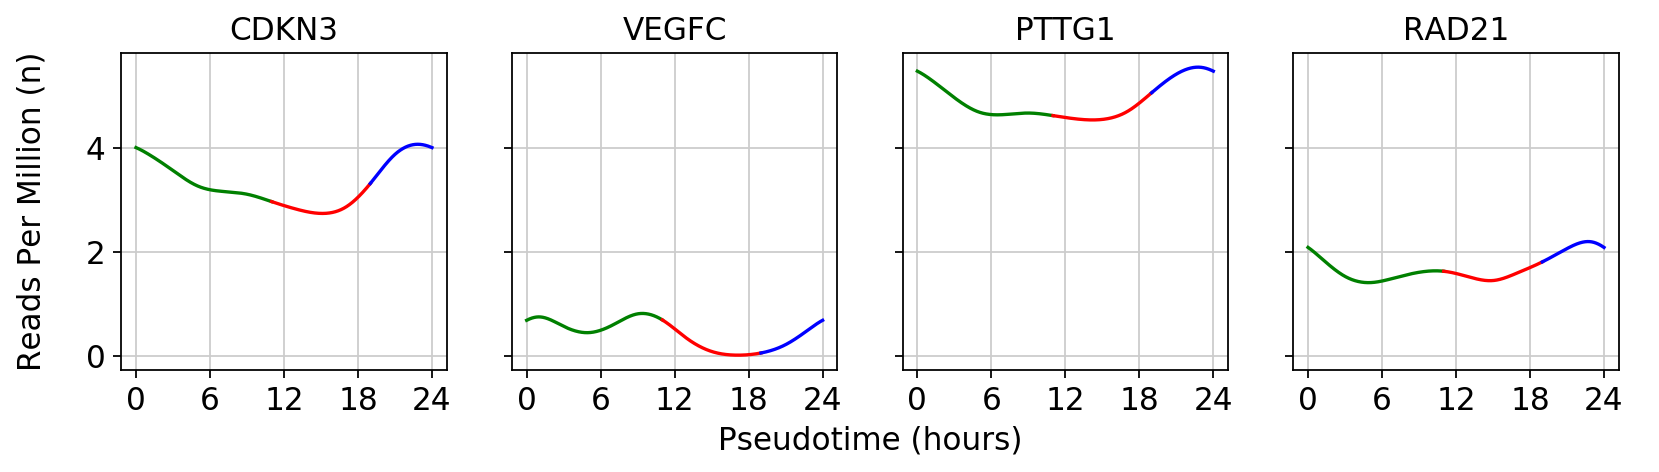

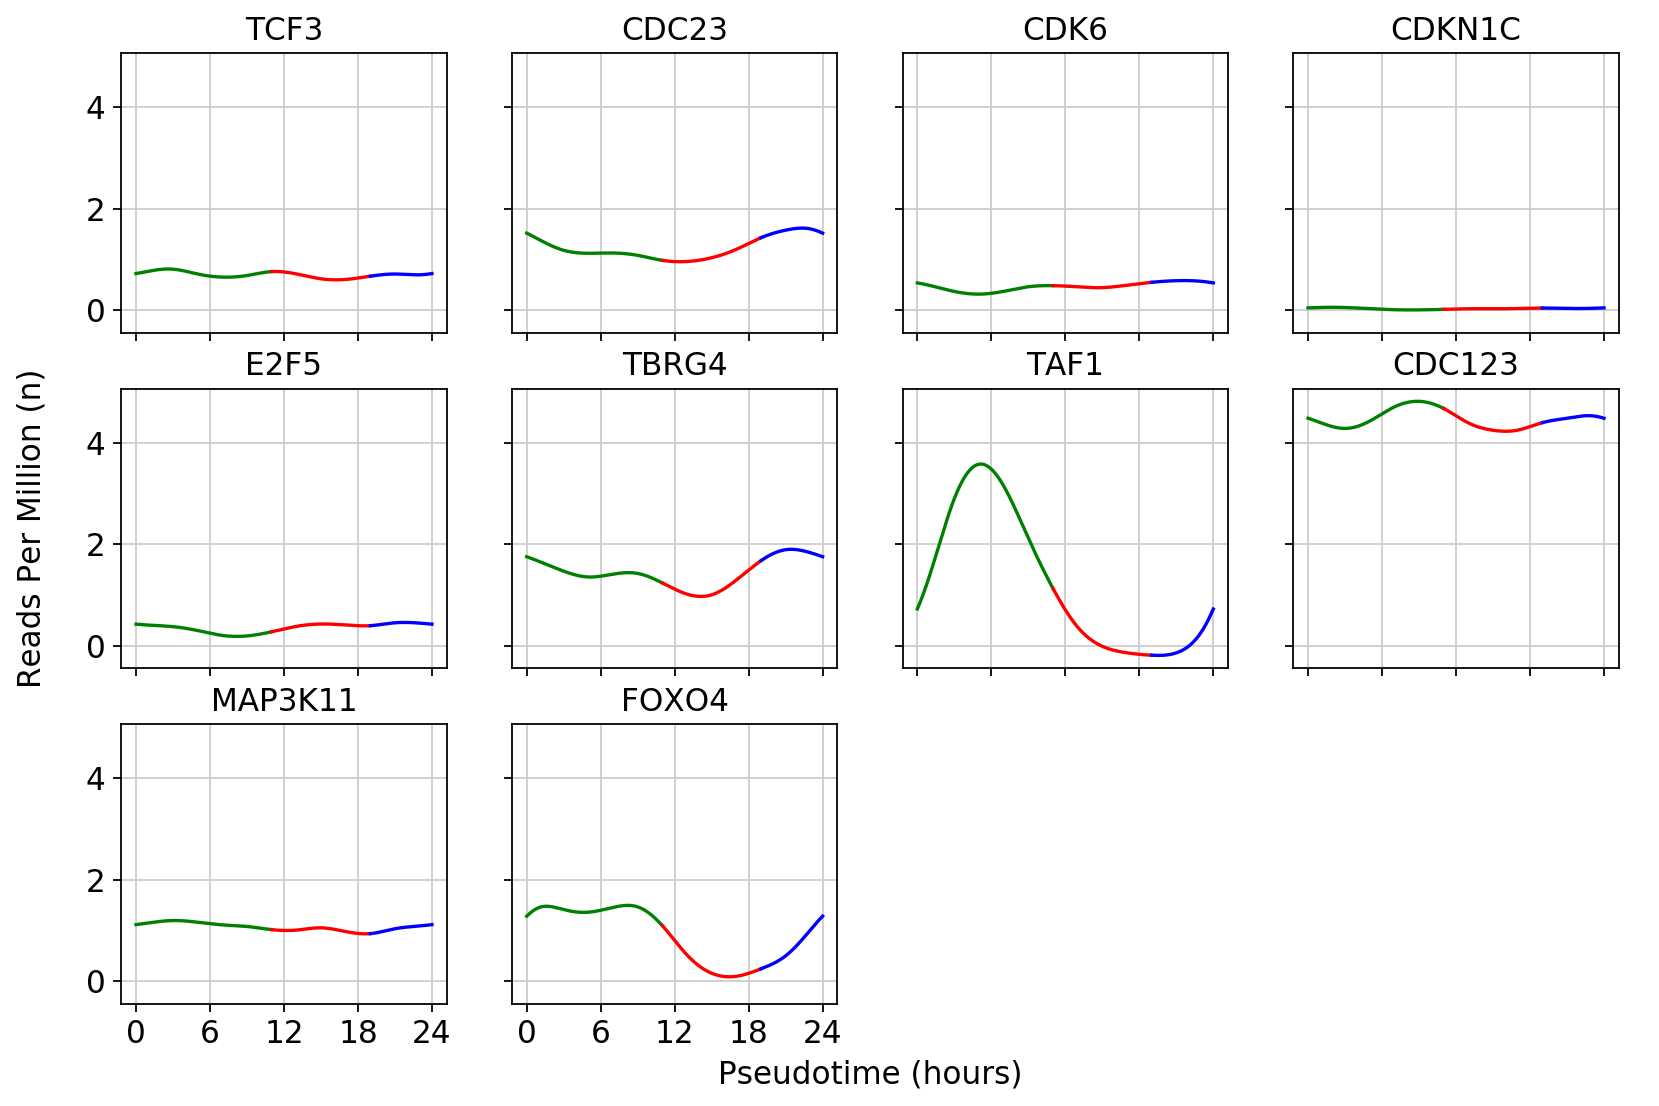

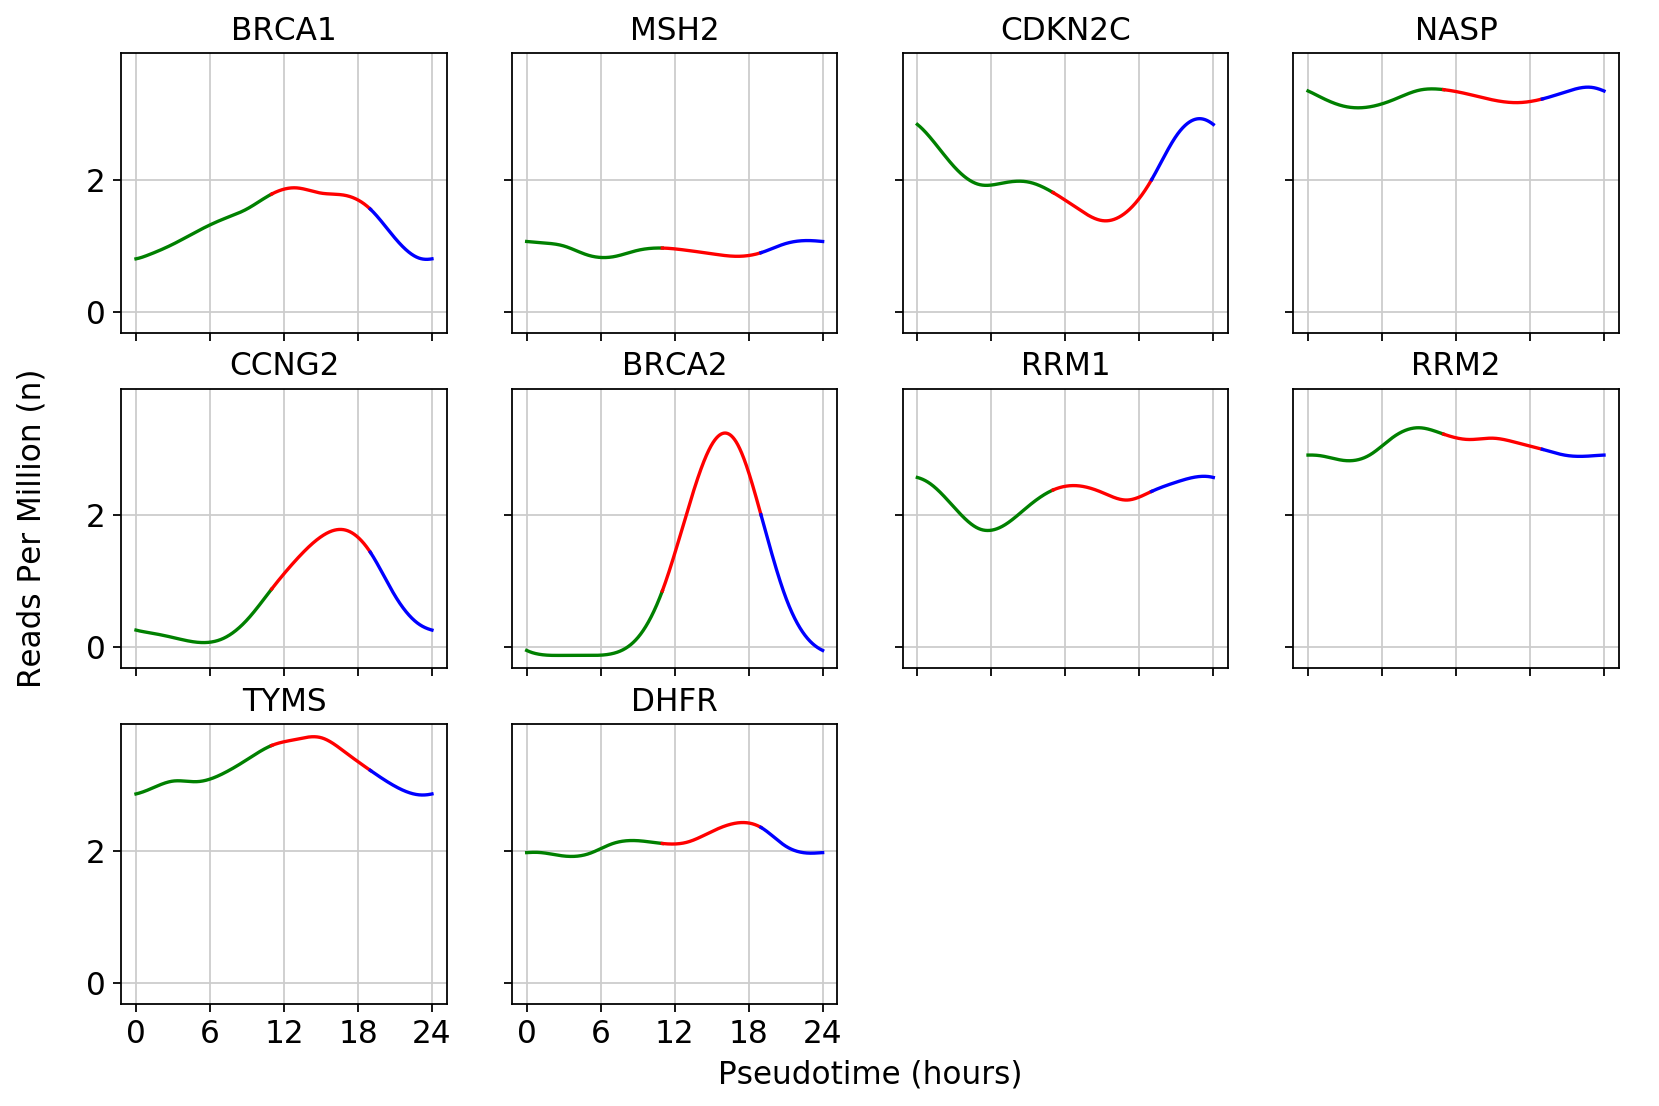

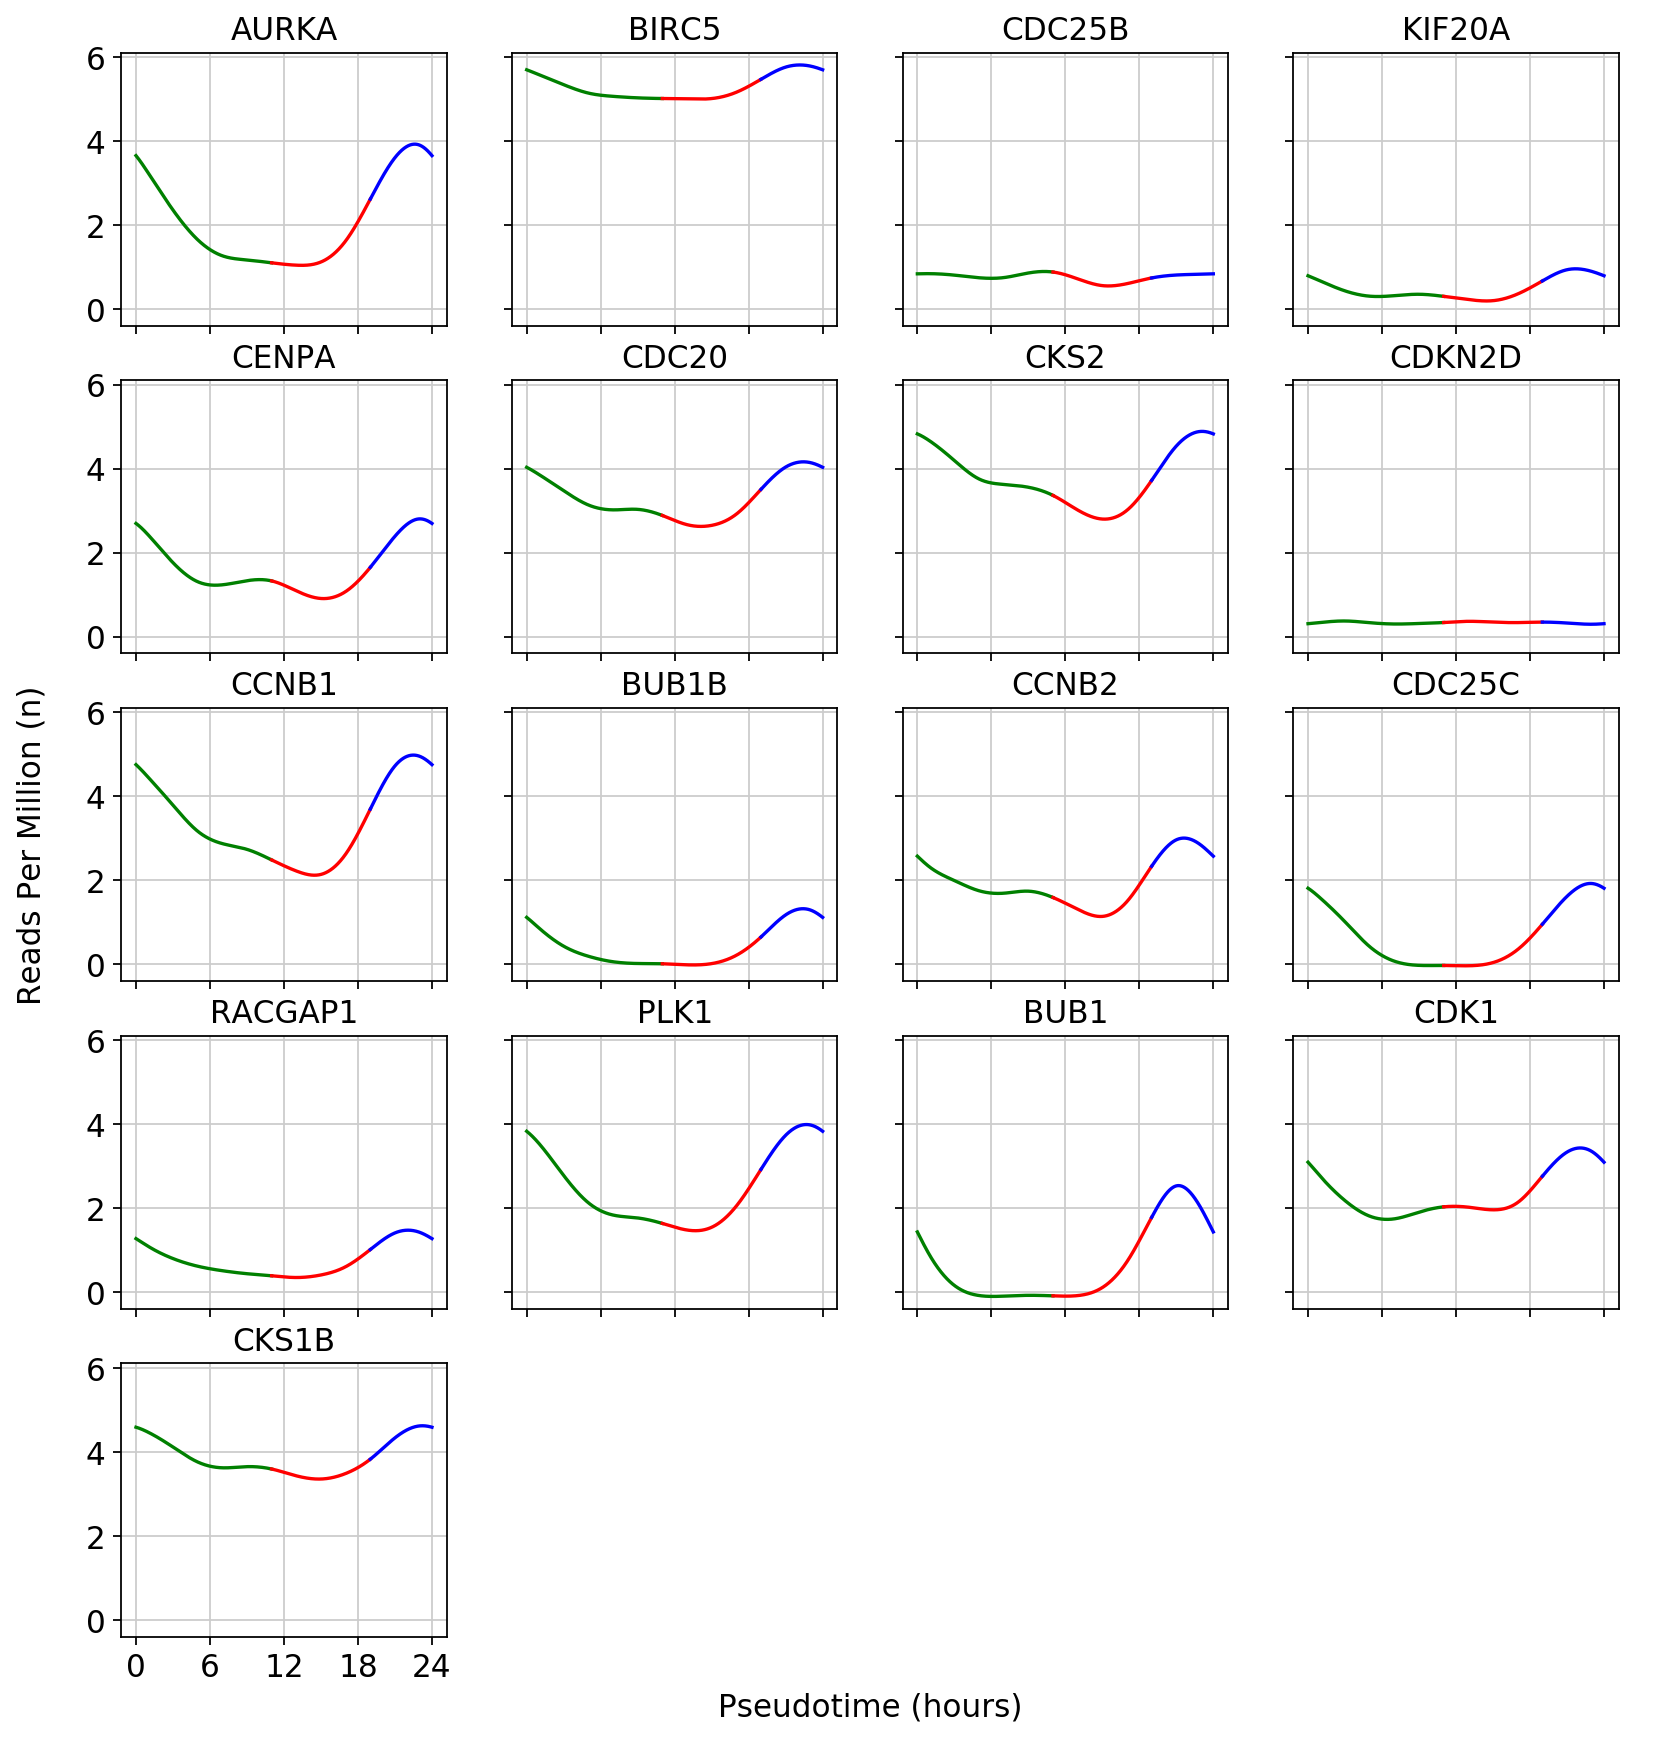

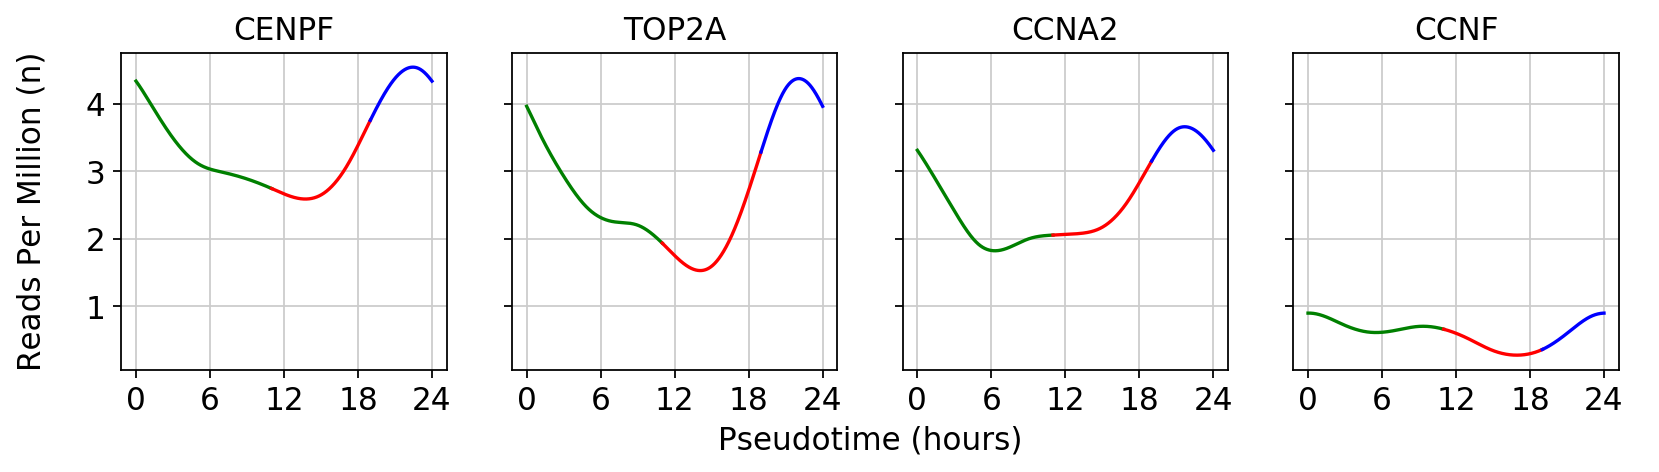

In [68]:
#report_df = pd.read_csv("./data/known_plus_regev.csv", index_col=0)
report_df = pd.read_csv("./data/knownGenes_derived.txt", sep=" ")
residuals = {}
for p in ['M/G1','G1','S','G2/M','G2']:
    print("Plotting known {} genes".format(p))
    p_df = report_df[report_df['phase'] == p]
    ens_list = list(set(list(p_df['Ensembl'])).intersection(list(data_bb.var.index)))
    mscu.plot_splines_from_list(data_bb, ens_list, color_phase=True, csaps_smooth=opt_smooth, subsample_width=2, plot_ctrl_pts=False, plot_filename='figures/293t/spline_{}.png'.format(p.replace('/','-')))
    

In [51]:
stress_df = pd.read_csv("./data/StressGenes-Finn.txt", sep=" ")
genes = list(set(list(stress_df['Ensembl'])).intersection(set(list(data_bb.var.index))))
genes = sorted(genes)
print(len(genes))

155


In [76]:
"""
for i,j in enumerate(range(0,len(genes),25)):
    n = min(j+25,len(genes))
    ens_list = genes[j:n]
    mscu.plot_splines_from_list(data_bb, ens_list, color_phase=True,csaps_smooth=opt_smooth, plot_ctrl_pts=False, plt_col_size=5, plot_filename='data/nice_plots/csaps/stress_plot_{}.png'.format(i+1))
"""    

"\nfor i,j in enumerate(range(0,len(genes),25)):\n    n = min(j+25,len(genes))\n    ens_list = genes[j:n]\n    mscu.plot_splines_from_list(data_bb, ens_list, color_phase=True,csaps_smooth=opt_smooth, plot_ctrl_pts=False, plt_col_size=5, plot_filename='data/nice_plots/csaps/stress_plot_{}.png'.format(i+1))\n"

In [78]:
data_bb.write("./data/final_293t/clean_data_bb.h5ad")

In [146]:
opt_smooth = 0.15

In [63]:
data_bb = sc.read_h5ad("./data/final_293t/clean_data_bb.h5ad")

In [70]:
data_bb

AnnData object with n_obs × n_vars = 629 × 18957 
    obs: 'batch', 'library_id', 'fraction_mito', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'G1_score', 'angles', 'phase', 'order', 'time'
    var: 'gene_symbols', 'gene_ids', 'n_cells', 'n_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'phase_boundaries'

In [147]:
subsampled, peakt_times = mscu.subsample_from_splines(data_bb,25,csaps_smooth=opt_smooth)

In [163]:
peakt_times.to_csv("data/final_293t/subsampled_splines_peaktimes.csv", index=True)

In [164]:
peak_times = peakt_times

In [82]:
subsampled.to_csv("data/final_293t/subsampled_splines.csv", index=True)

In [83]:
subsampled.index.values

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

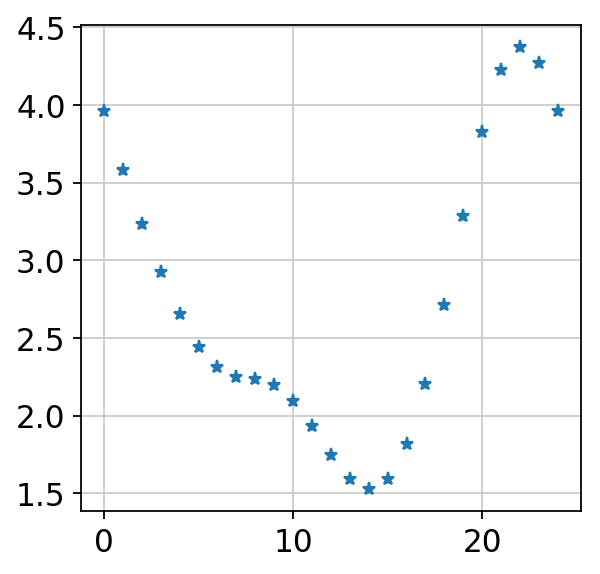

In [84]:
plt.figure()
plt.plot(subsampled.index.values,subsampled['ENSG00000131747'].values,'*')

In [85]:
Y1 = np.sin((2*np.pi/24)*subsampled.index.values)
Y2 = np.cos((2*np.pi/24)*subsampled.index.values)

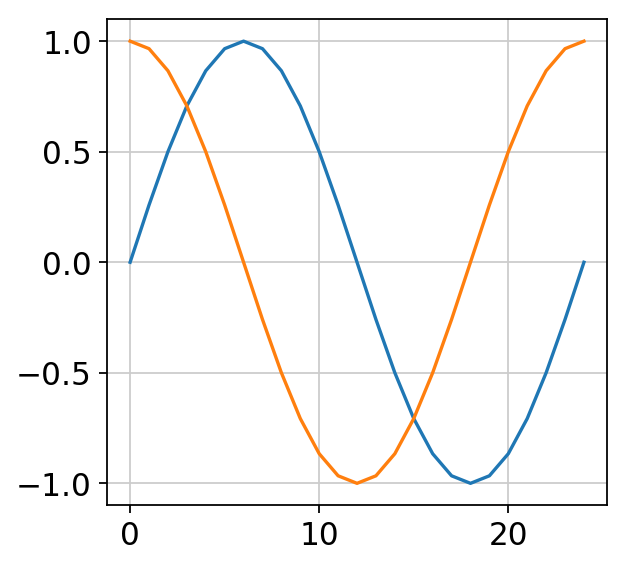

In [86]:
plt.plot(subsampled.index.values,Y1,subsampled.index.values,Y2)

In [87]:
Y = np.append([Y1],[Y2],axis=0).T

In [88]:
Y_df = pd.DataFrame({'sin': Y1, 'cos': Y2}, index=subsampled.index.values)

In [89]:
Y_df.to_csv("data/final_293t/PLS/PLS_Y.csv",index=True)

In [90]:
Y_df.to_csv("data/final_293t/PLS/PLS_Y.csv",index=True)

In [82]:
pls_sigloadings = pd.read_csv("data/final_293t/PLS/model_sigloadings.csv",index_col=0)
pls_loadingweights = pd.read_csv("data/final_293t/PLS/model_loadingweights.csv",index_col=0)
r_cuts = pd.read_csv("data/final_293t/PLS/r_cutoff.csv",index_col=0)

In [83]:
r_cut = r_cuts['x'].mean()

In [162]:
r_cut

0.921583047327074

In [84]:
pls_sigloadings.head()

V1        V2
ENSG00000225972 -0.165877  0.006286
ENSG00000225630 -0.133887  0.015336
ENSG00000237973  0.059267 -0.148021
ENSG00000229344  0.000000  0.000000
ENSG00000248527 -0.165627  0.506144

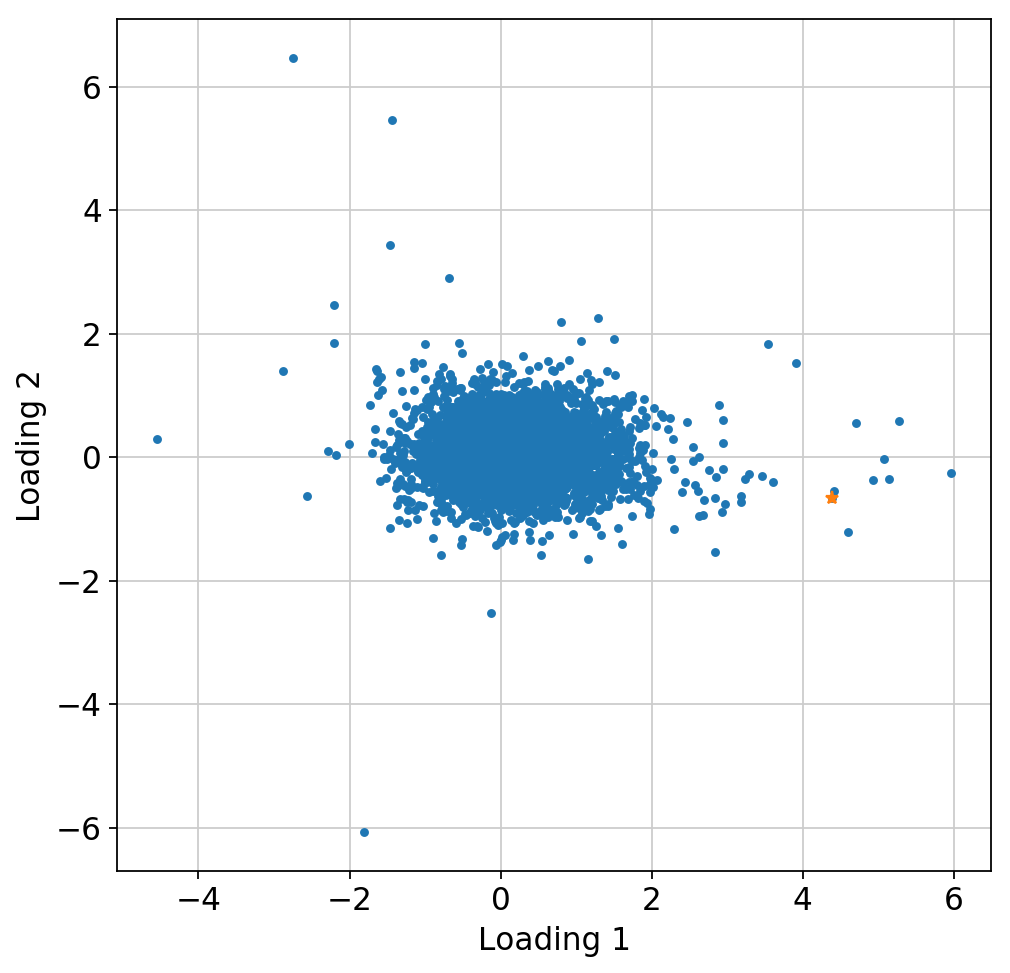

In [86]:
mscu.plot_pls_loadings(pls_sigloadings,gene_list=['ENSG00000131747'],plot_path="figures/293t/PLS/293t_pls_raw.png")

In [87]:
pls_sigloadings['angles'] = mscu.compute_angles(np.append([pls_sigloadings['V1']],[pls_sigloadings['V2']],axis=0).T)
print(sum(pls_sigloadings['angles']>=0))
pls_sigloadings.dropna(inplace=True)
pls_sigloadings['r'] = mscu.compute_pls_loading_lengths(pls_sigloadings)

18957


In [88]:
pls_sigload_cutoff = pls_sigloadings[pls_sigloadings['r']>r_cut]
print(pls_sigload_cutoff.index.value_counts().sum())


1295


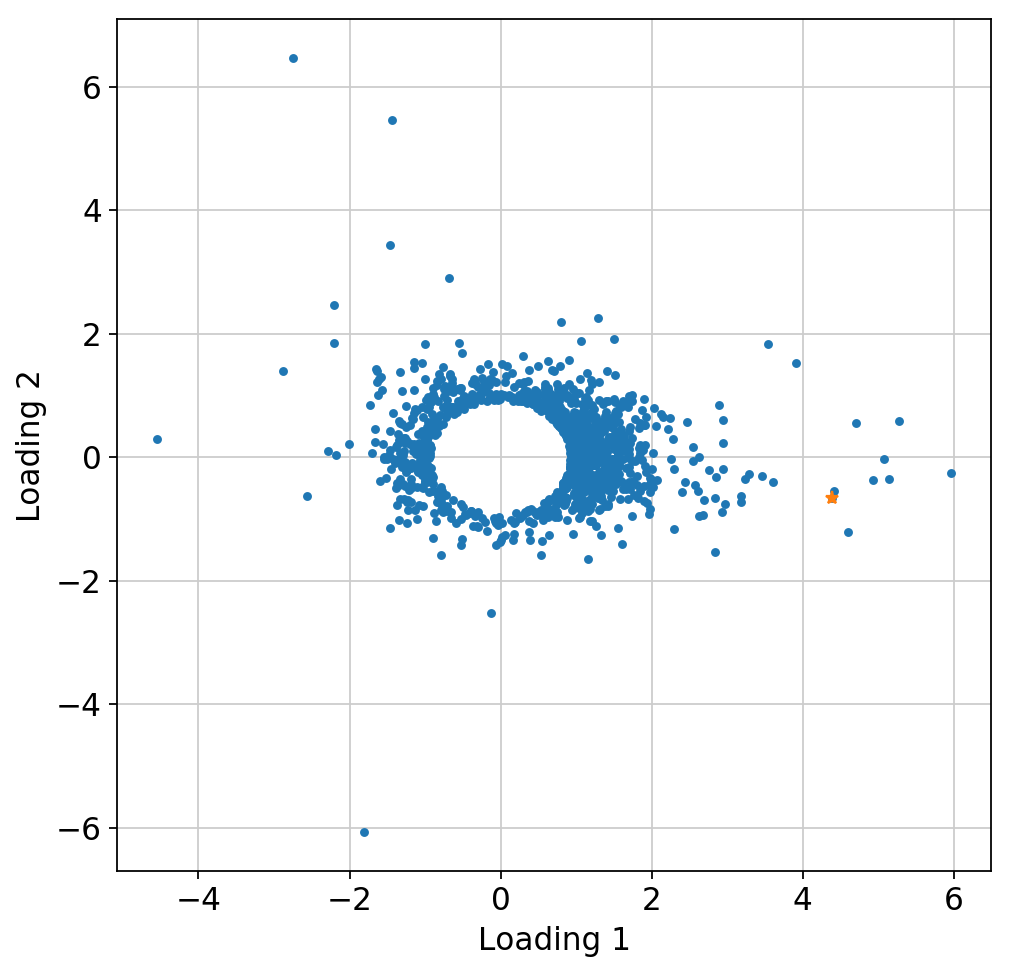

In [89]:
mscu.plot_pls_loadings(pls_sigload_cutoff,gene_list=['ENSG00000131747'],plot_path="figures/293t/PLS/293t_pls_filter.png")

In [119]:
angle_dist_df = mscu.compute_angle_phase_distribution_with_resampling(pls_sigload_cutoff)

In [120]:
angle_dist_df

mean  variance     n
S           5.105401  0.816093  26.0
G2          1.700165  0.000823   3.0
G2/M        1.534180  0.092850  50.0
G1          2.810498  0.767992   4.0
M/G1        2.220208  0.930288   4.0
G1/S        5.303731  0.066268   7.0
S-shift    -1.177784  0.816093  26.0
M/G1-shift  8.503393  0.930288   4.0

In [121]:
angle_dist_df['mean'].sort_values()

S-shift      -1.177784
G2/M          1.534180
G2            1.700165
M/G1          2.220208
G1            2.810498
S             5.105401
G1/S          5.303731
M/G1-shift    8.503393
Name: mean, dtype: float64

In [176]:
import importlib
import myscutils.myscutils as mscu
importlib.reload(mscu)


Running Scanpy 1.3.7 on 2019-09-06 09:23.
Dependencies: anndata==0.6.17 numpy==1.15.4 scipy==1.2.0 pandas==0.23.4 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


<module 'myscutils.myscutils' from '/mnt/work/geiramh/part2-single-cell/notebooks/myscutils/myscutils.py'>

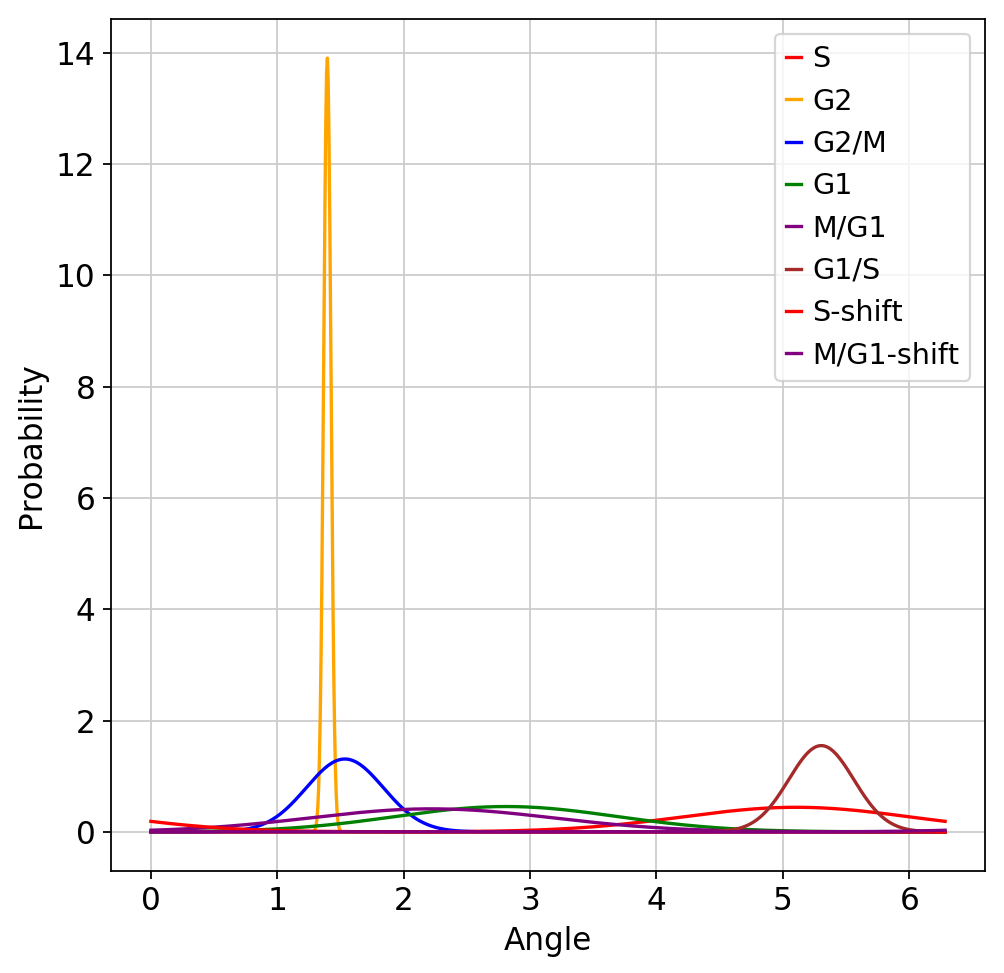

In [125]:
mscu.plot_phase_angle_distribution(angle_dist_df,plot_path="figures/293t/PLS/293t_pls_phase_dist_raw.png")

In [126]:
mscu.assign_phase(pls_sigload_cutoff,angle_dist_df)

/mnt/work/geiramh/part2-single-cell/notebooks/myscutils/myscutils.py:1497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pls_sigload_cutoff['assigned_phase'] = assigned_phase


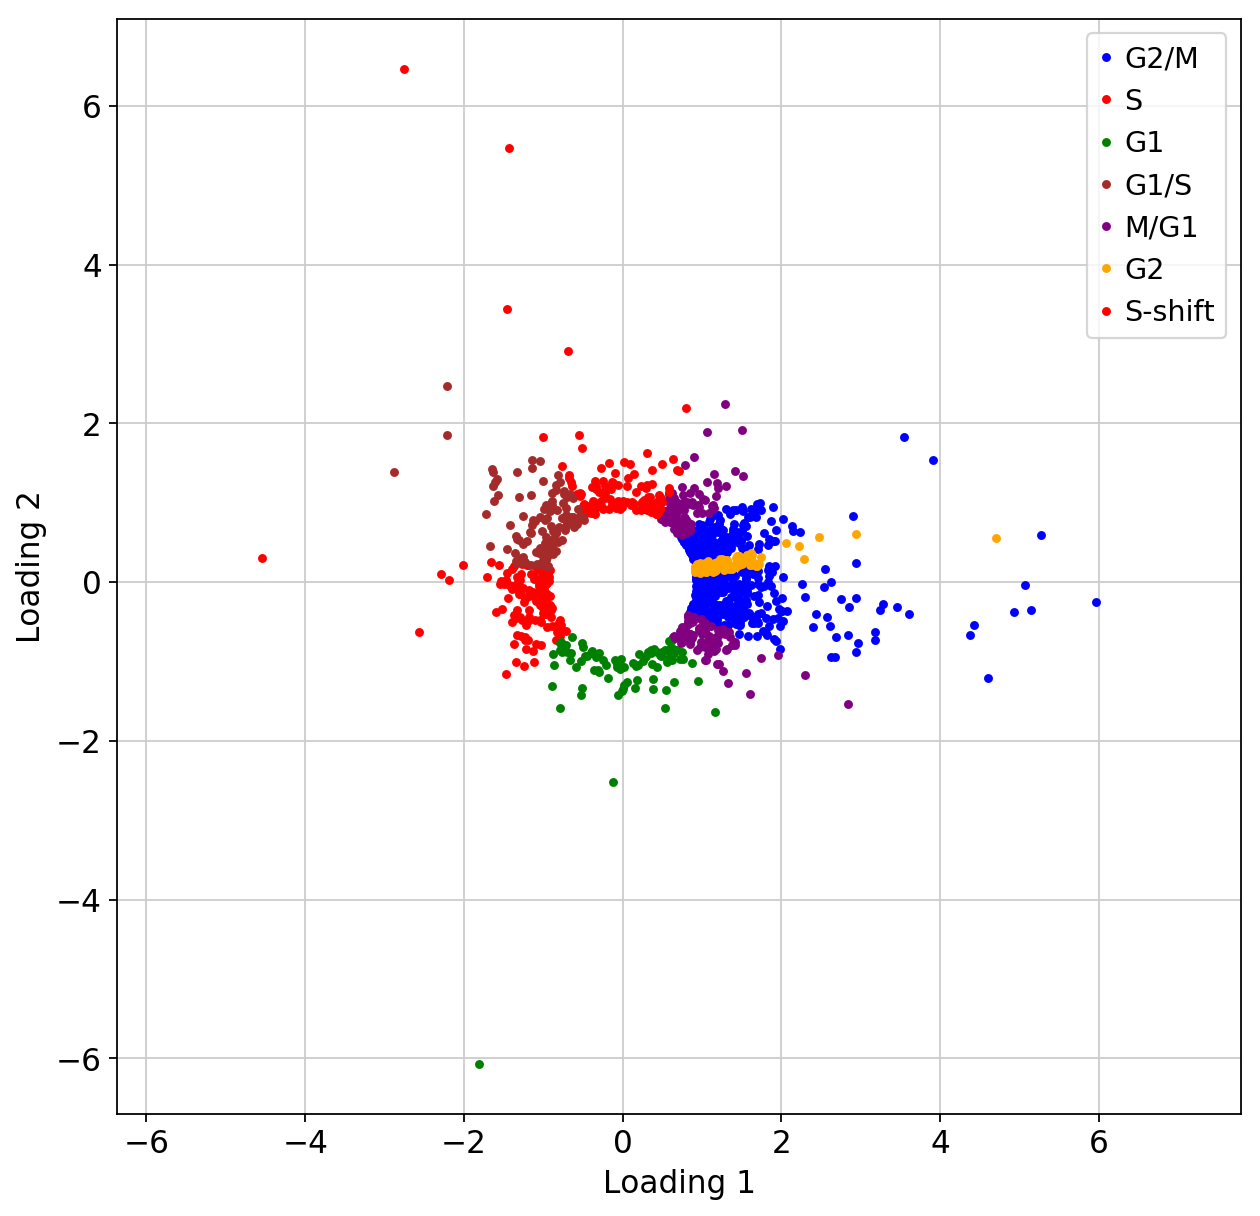

In [127]:
mscu.plot_pls_assigned_phases(pls_sigload_cutoff,plot_path="figures/293t/PLS/293t_pls_assigned_raw.png")

In [176]:
pls_sigload_cutoff.head()

V1        V2    angles         r assigned_phase
ENSG00000160087  0.896243  0.583169  0.993942  1.069270           M/G1
ENSG00000169972 -1.299649 -0.106522  4.630610  1.304007              S
ENSG00000221978  1.062352 -0.361773  1.899018  1.122262           G2/M
ENSG00000242485 -0.478197 -0.927071  3.617812  1.043137             G1
ENSG00000157916  1.170531  0.641571  1.069411  1.334825           M/G1

In [ ]:
#out of order G2 - G2/M and M/G1

In [128]:
its = 0
while (pls_sigload_cutoff.loc[pls_sigload_cutoff['assigned_phase'] == 'M/G1', 'angles'].min() < pls_sigload_cutoff.loc[pls_sigload_cutoff['assigned_phase'] == 'G2', 'angles'].min()):
    angle_dist_df.loc['G2','variance'] *= 1.25
    mscu.assign_phase(pls_sigload_cutoff,angle_dist_df)
    its += 1
    if its == 1000:
        break
print(its)

24


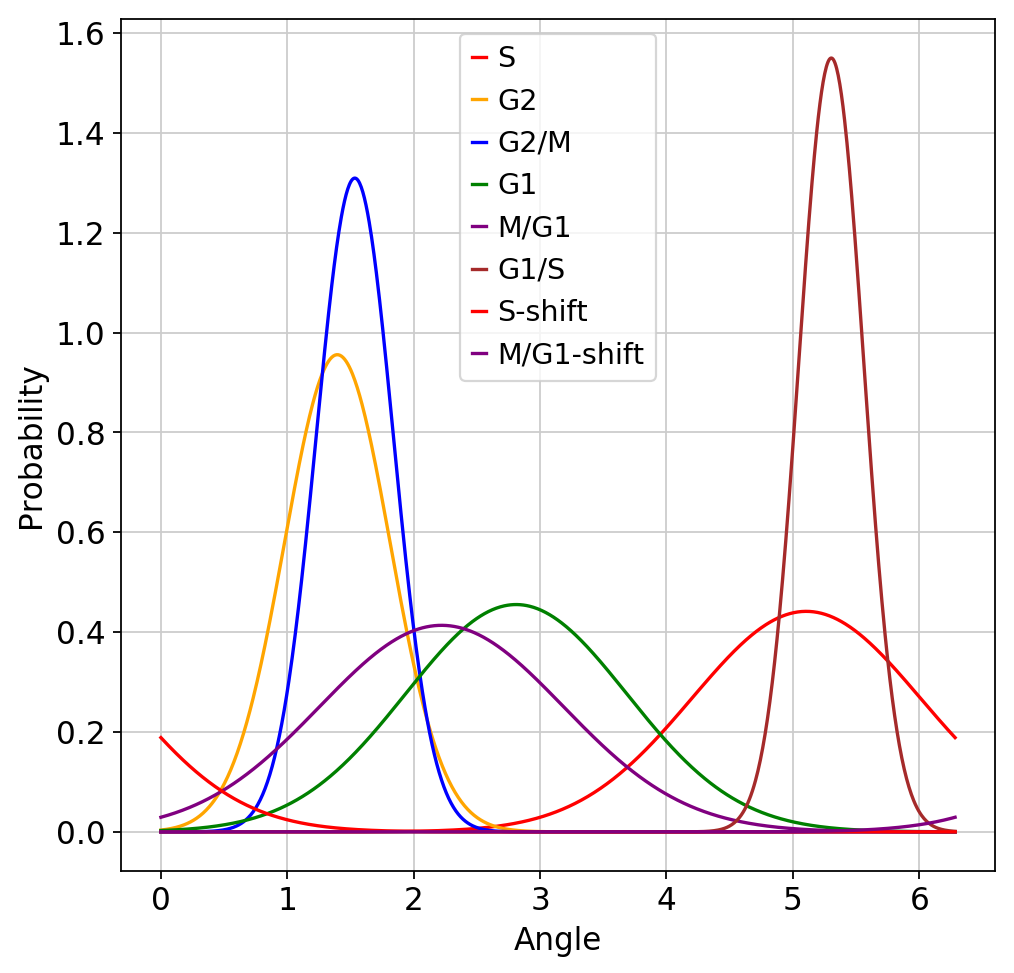

In [130]:
mscu.plot_phase_angle_distribution(angle_dist_df,plot_path="figures/293t/PLS/293t_pls_phase_dist_tweak.png")

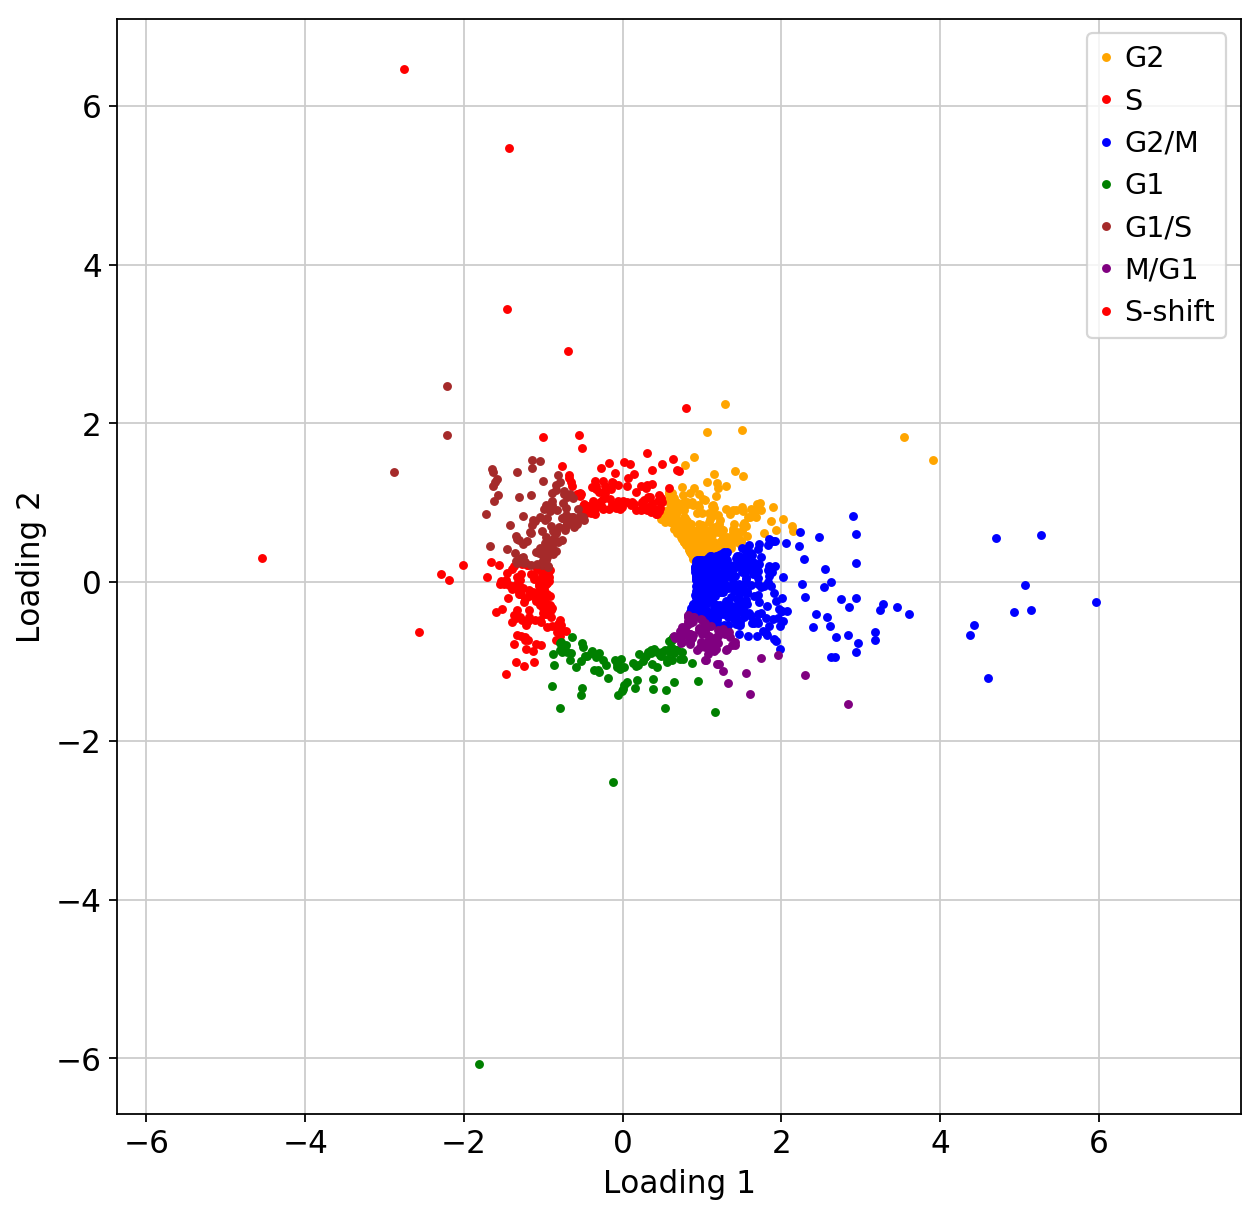

In [131]:
mscu.plot_pls_assigned_phases(pls_sigload_cutoff,plot_path="figures/293t/PLS/293t_pls_assigned_tweaked.png")

In [132]:
pls_sigload_cutoff['assigned_phase'].value_counts()

G2/M       461
G2         288
S          201
G1/S       117
G1          94
M/G1        88
S-shift     46
Name: assigned_phase, dtype: int64

In [183]:
pls_sigload_cutoff.to_csv("data/final_293t/PLS/assigned_genes_raw.csv")

In [133]:
pls_clean = pls_sigload_cutoff.copy()

In [134]:
#We are unable to separate G2 and G2/M -> merge all to G2/M
pls_clean.loc[pls_clean['assigned_phase'] == 'G1/S','assigned_phase'] = 'S'

In [135]:
pls_clean.loc[pls_clean['assigned_phase'] == 'S-shift','assigned_phase'] = 'S'

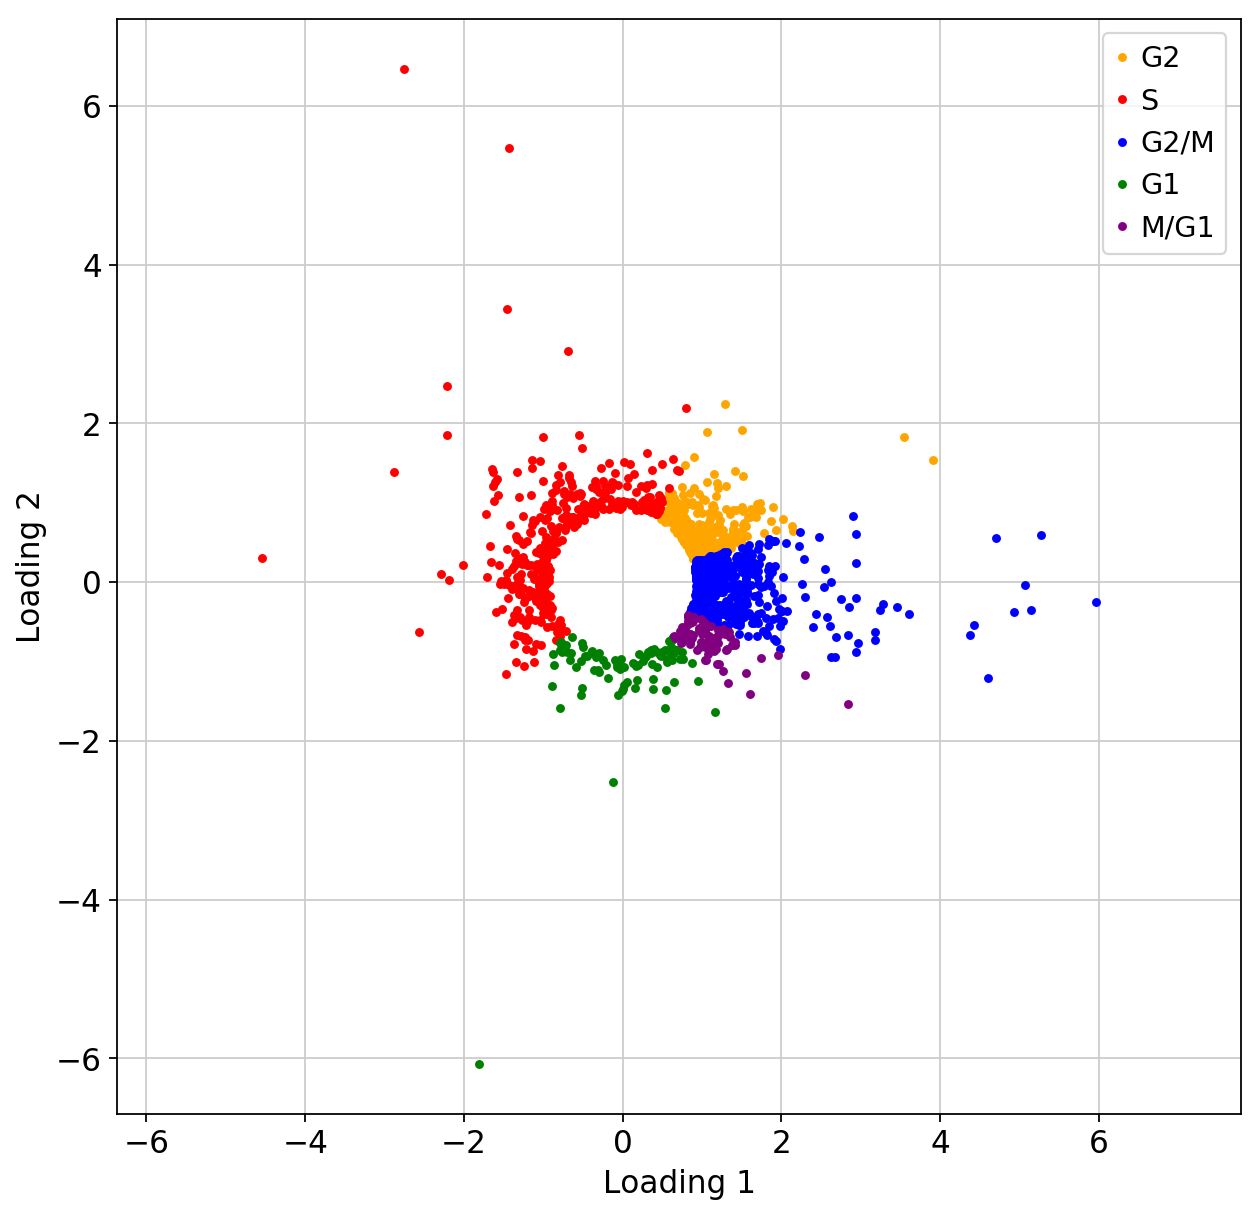

In [136]:
mscu.plot_pls_assigned_phases(pls_clean,plot_path="figures/293t/PLS/293t_pls_angle_phase_distr_finale.png")

In [137]:
#mscu.plot_pls_all_genes(data_bb,pls_clean,csaps_smooth=opt_smooth, plot_base_path='data/final_293t/plots/PLS/clean')

In [138]:
#mscu.plot_pls_all_genes(data_bb,pls_sigload_cutoff,csaps_smooth=opt_smooth, plot_base_path='data/final_293t/plots/PLS/raw')

In [169]:
print(pls_clean['assigned_phase'].value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &  assigned\_phase \\
\midrule
G2/M &             461 \\
S    &             364 \\
G2   &             288 \\
G1   &              94 \\
M/G1 &              88 \\
\bottomrule
\end{tabular}



In [140]:
gene_biotypes = pd.read_csv("data/gene_biotypes.csv")
gene_biotypes = gene_biotypes.set_index('gene_id')
gene_biotypes.index.names = ['index']
pls_clean = pls_clean.join(gene_biotypes,how='left')

In [141]:
pls_clean['gene_biotype'].value_counts()

protein_coding                        1269
lincRNA                                  9
antisense                                9
processed_transcript                     3
transcribed_unprocessed_pseudogene       2
processed_pseudogene                     2
sense_overlapping                        1
Name: gene_biotype, dtype: int64

In [166]:
len(set(genes_df.index.values).intersection(set(pls_clean.index.values)))

94

In [165]:
genes_df = pd.read_csv("data/known_plus_regev.csv",index_col=0)

In [167]:
correct = 0
for g in list(set(genes_df.index.values).intersection(set(pls_clean.index.values))):
    #print(g)
    if genes_df.loc[g,'phase'] == pls_clean.loc[g,'assigned_phase']:
        correct += 1
correct

65

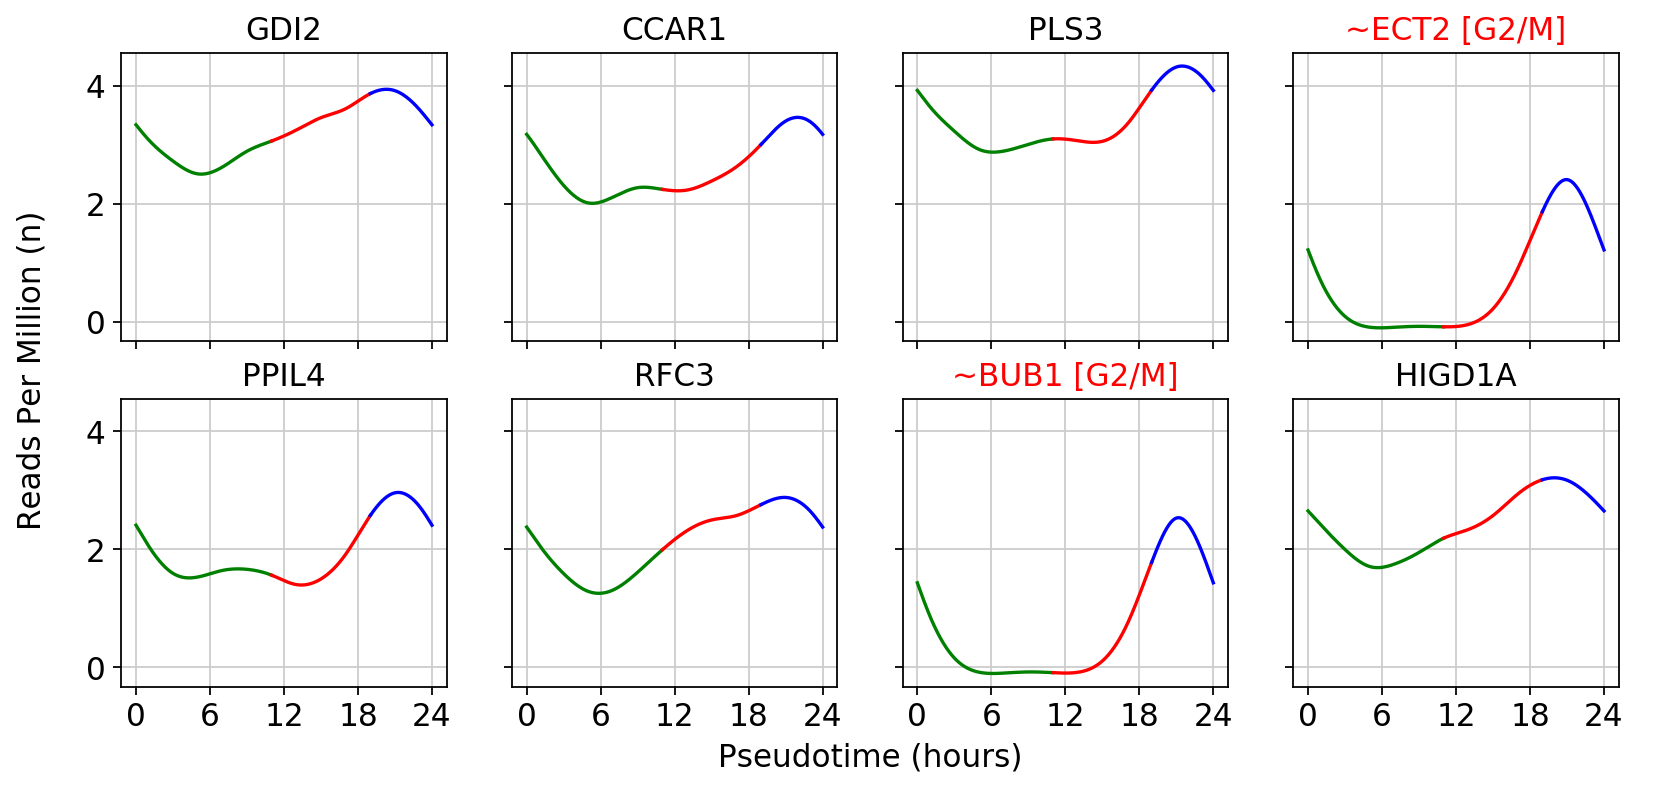

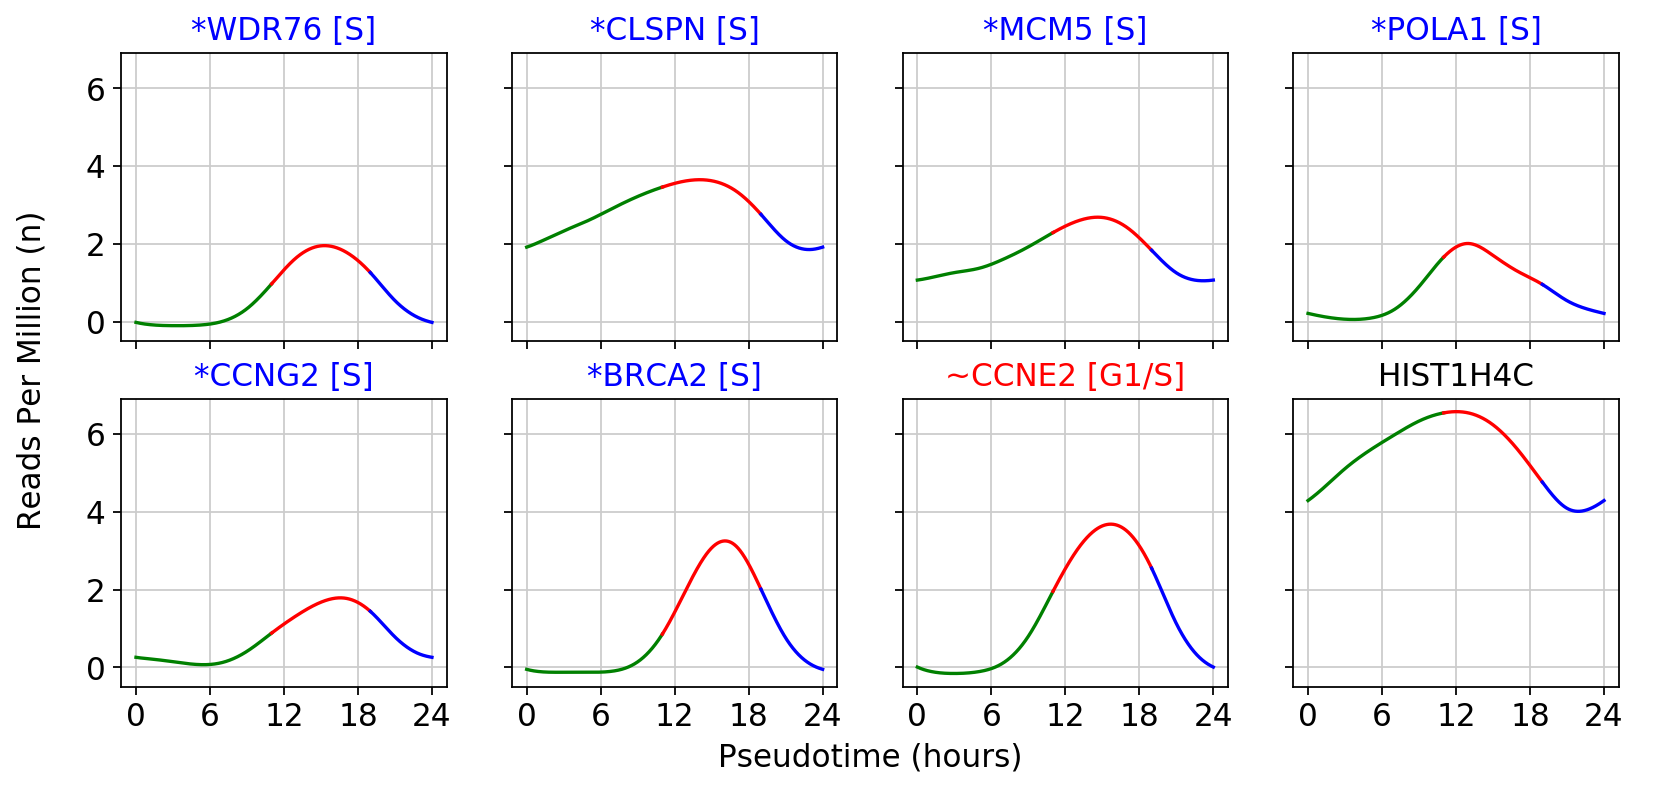

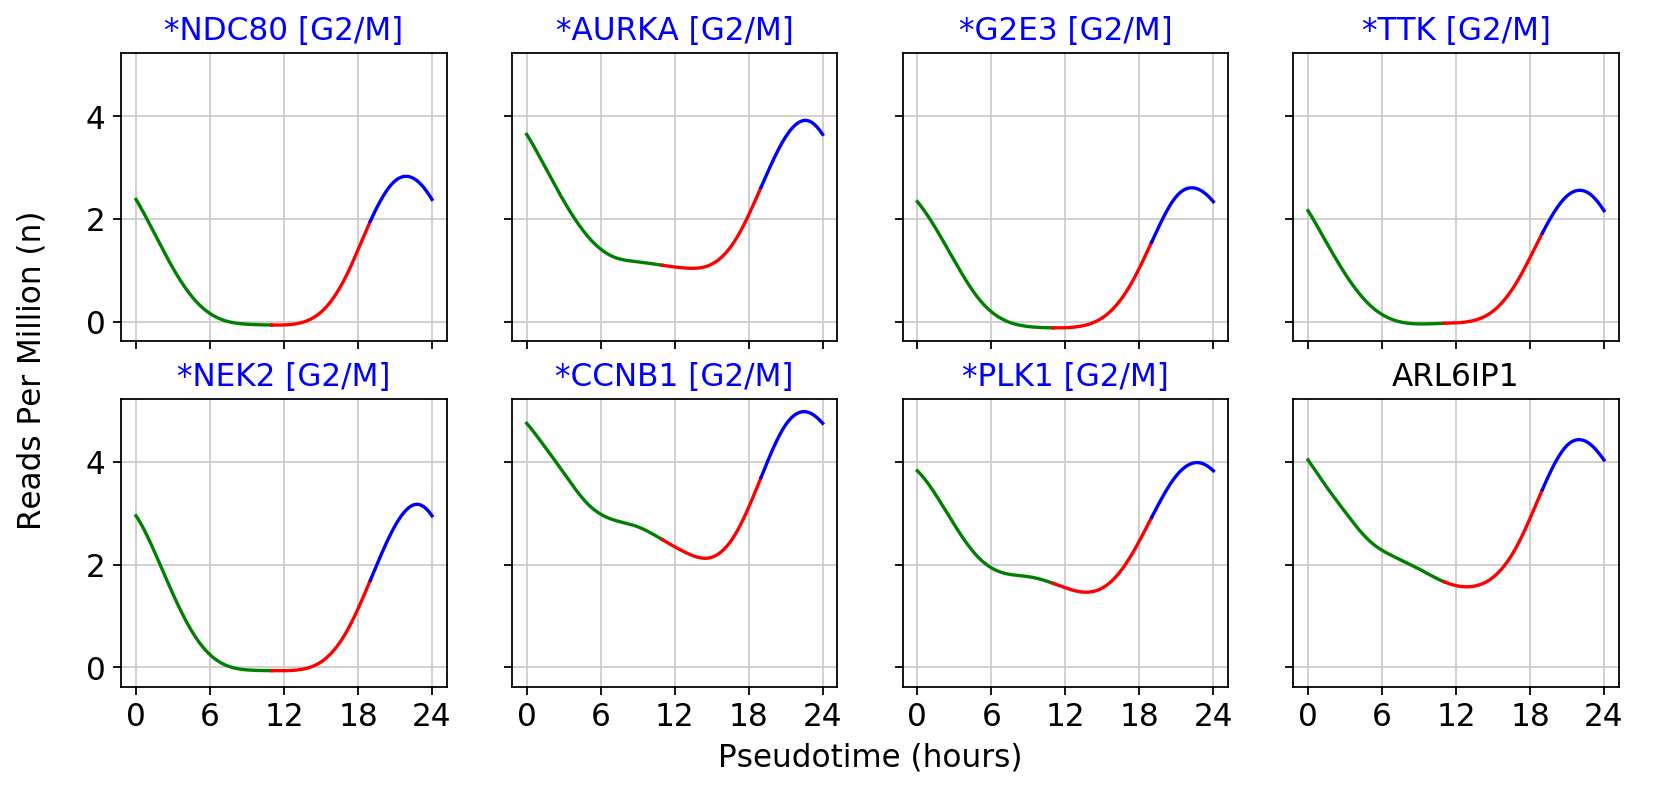

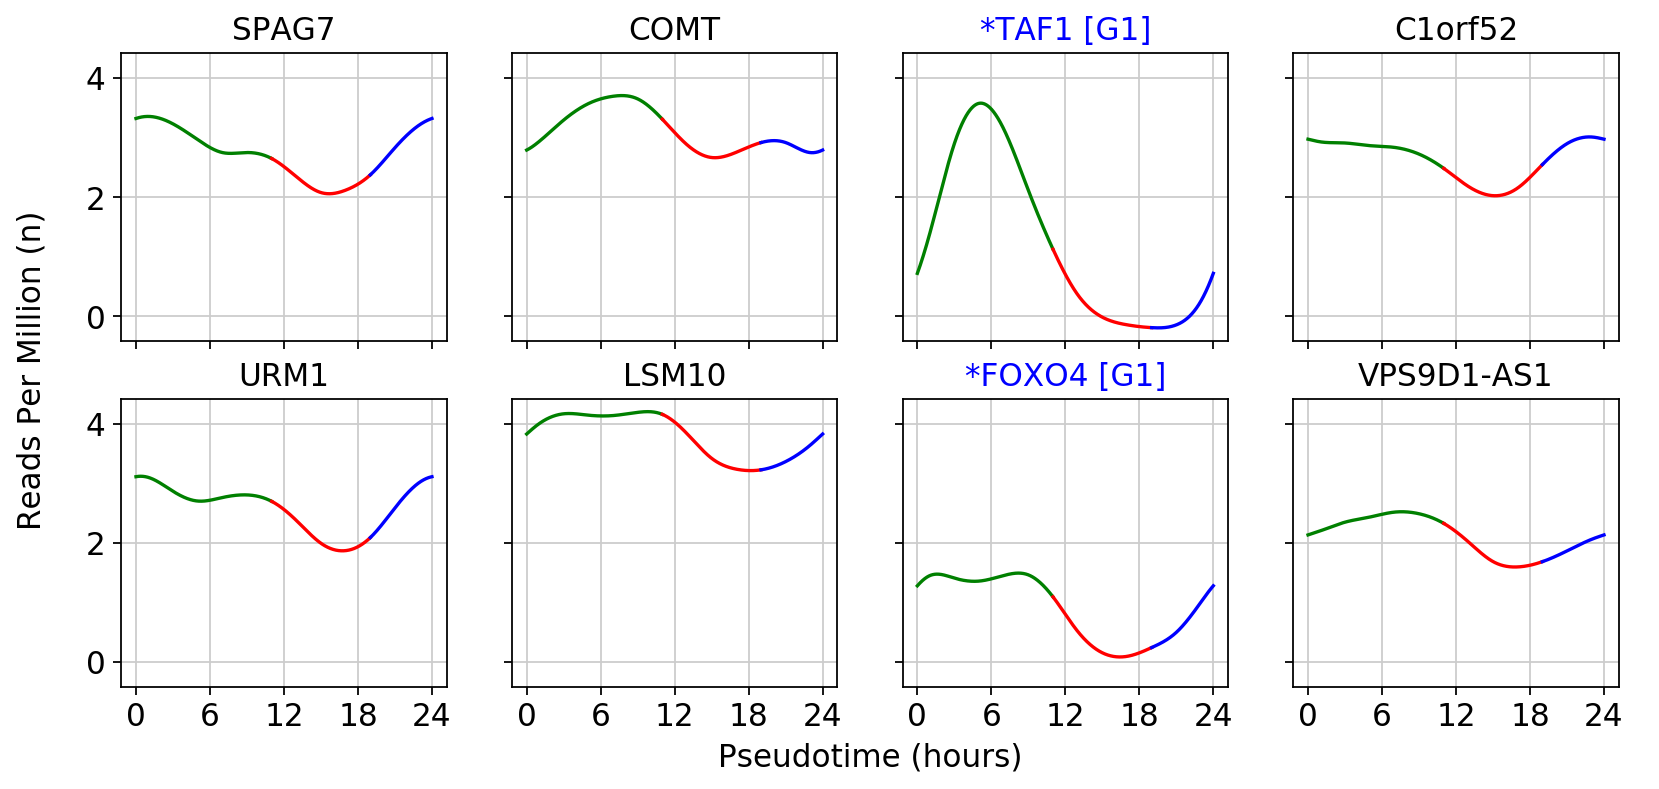

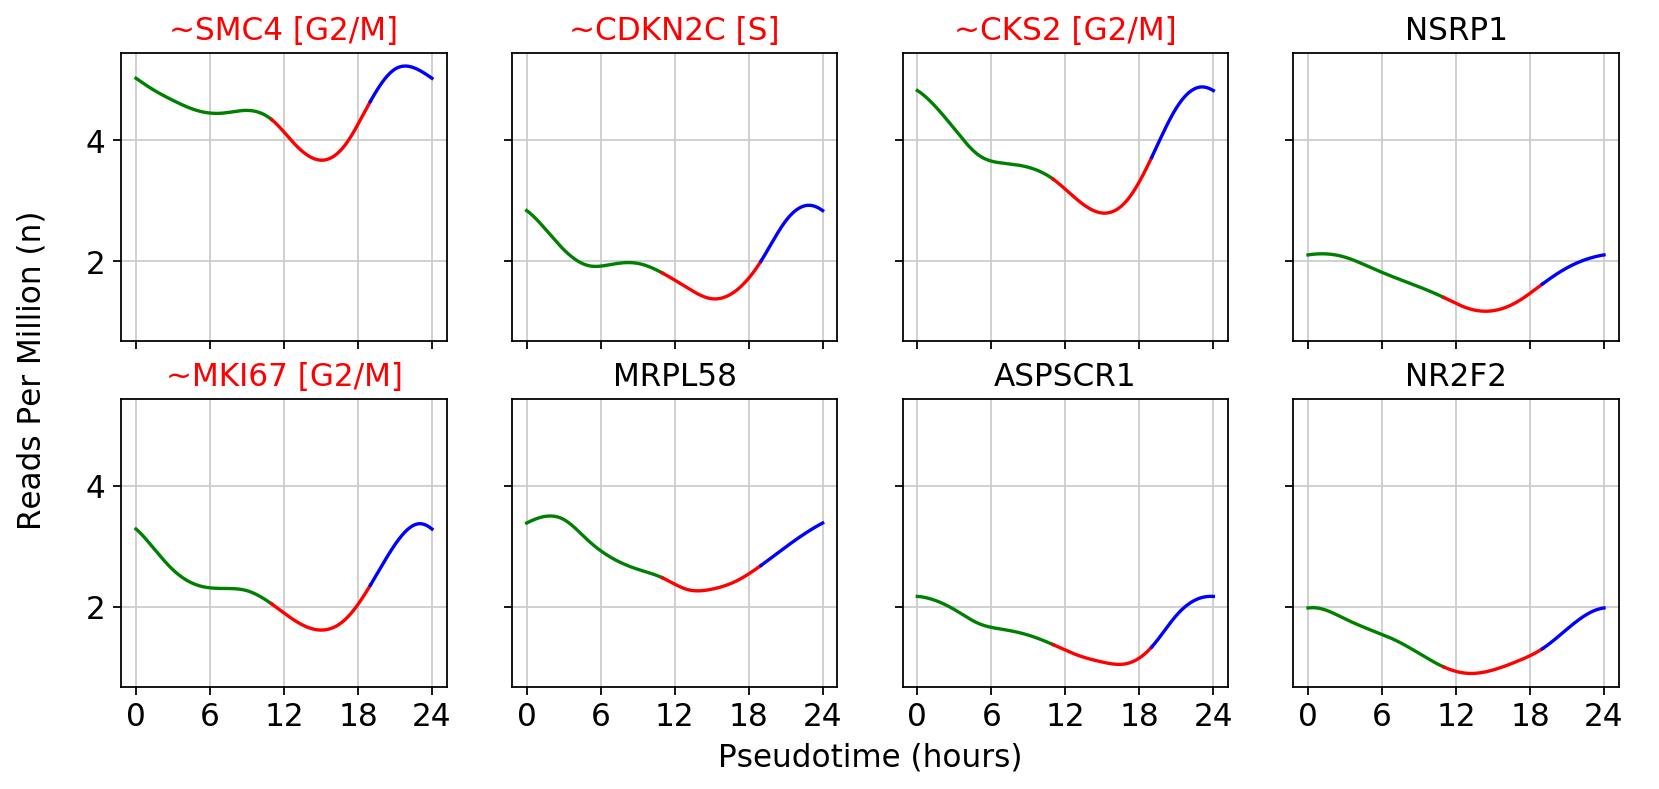

In [177]:
for p in pls_clean['assigned_phase'].unique():
    phase_df = pls_clean[pls_clean['assigned_phase'] == p].copy()
    top = phase_df.sort_values(by=['r'],ascending=False)[:8]
    mscu.plot_splines_from_list_color_title(data_bb, top.index.values, genes_df, pls_clean, color_phase=True, plt_col_size=4, csaps_smooth=0.15, subsample_width=2, plot_ctrl_pts=False, plot_filename='data/final_293t/plots/PLS/top8_{}.png'.format(p.replace('/','-')))

In [171]:
pls_clean = pls_clean.join(peak_times,how='left')

In [173]:
#pls_clean

In [142]:
data_bb

AnnData object with n_obs × n_vars = 629 × 18957 
    obs: 'batch', 'library_id', 'fraction_mito', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'G1_score', 'angles', 'phase', 'order', 'time'
    var: 'gene_symbols', 'gene_ids', 'n_cells', 'n_reads', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'phase_boundaries'

In [174]:
pls_clean['gene_symbols'] = data_bb.var.loc[pls_clean.index.values,'gene_symbols']
pls_clean.to_csv("data/final_293t/PLS/assigned_genes_clean_report.csv")

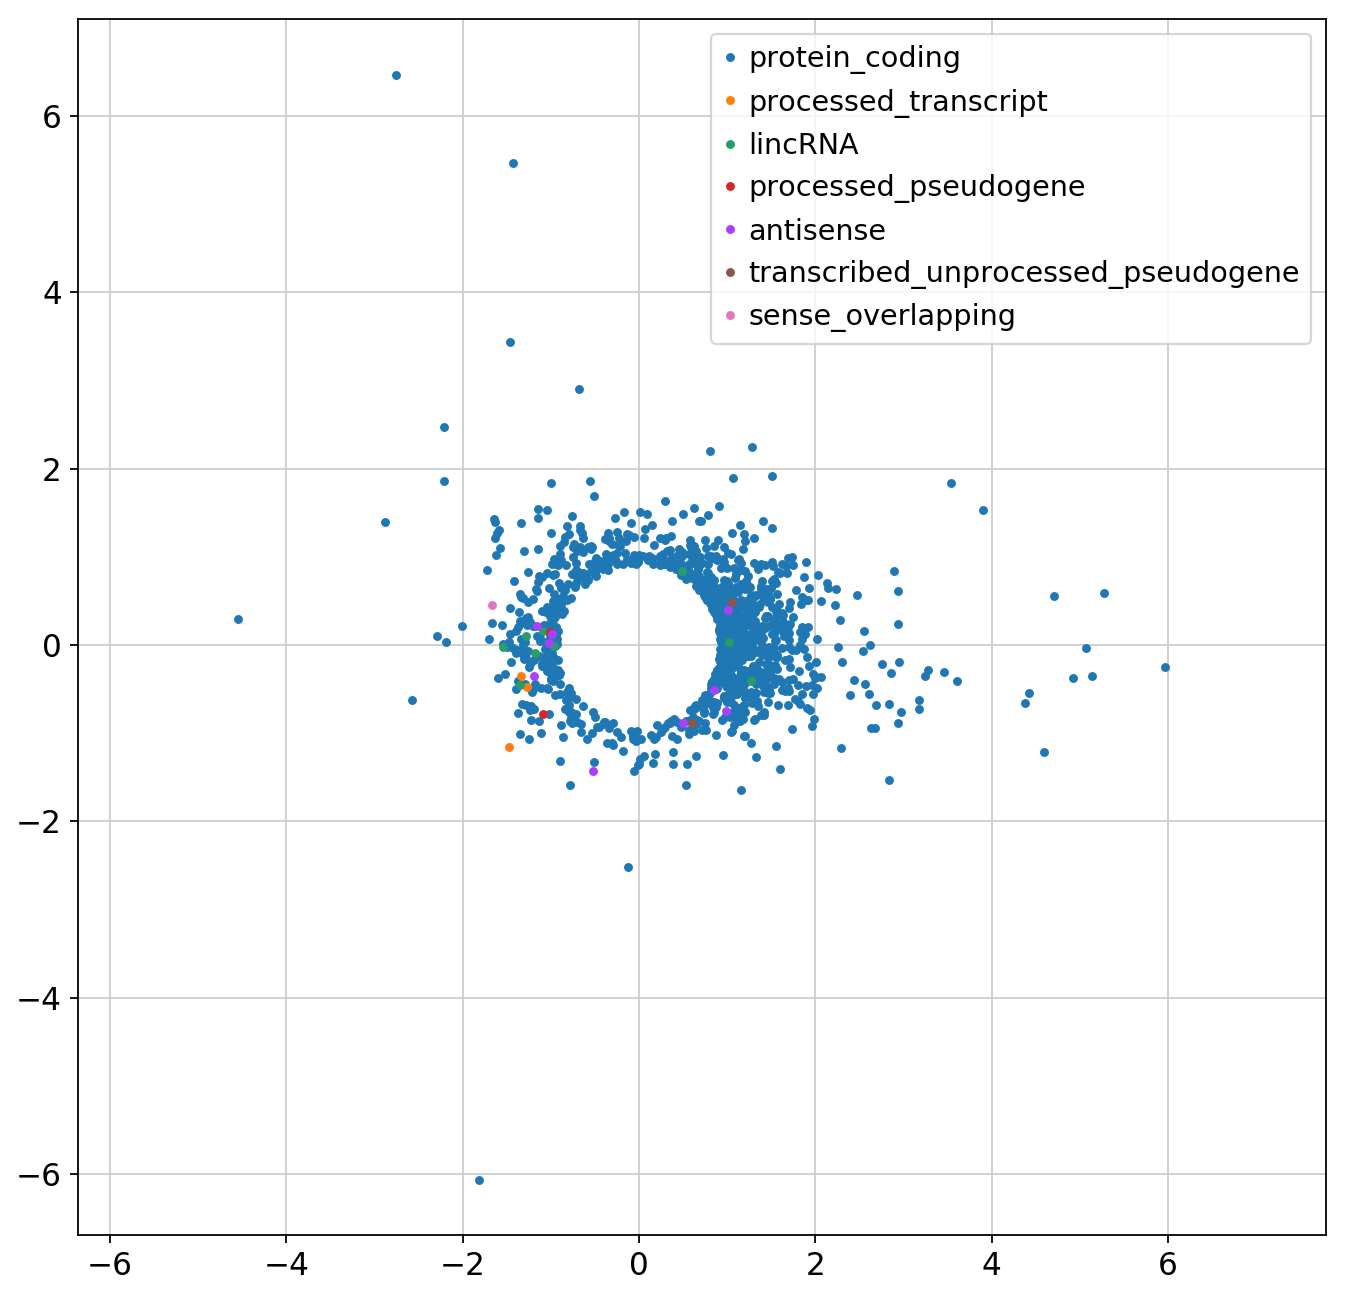

In [144]:
mscu.plot_pls_biotypes(pls_clean)

In [196]:
pls_clean.groupby(['gene_biotype'])['assigned_phase'].value_counts()

gene_biotype                        assigned_phase
antisense                           S                   4
                                    G1                  2
                                    M/G1                2
                                    G2                  1
lincRNA                             S                   7
                                    G2/M                2
processed_pseudogene                S                   2
processed_transcript                S                   2
                                    G1                  1
protein_coding                      G2/M              404
                                    S                 365
                                    G2                333
                                    M/G1               87
                                    G1                 80
sense_overlapping                   S                   1
transcribed_unprocessed_pseudogene  G1                  1
                     